# Which feature is the biggest driver of error in the zestimate?

## Import Libraries

In [285]:
#Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for processing data
import pandas as pd
import numpy as np

#Import libraries for graphing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

#Libraries for obtaining data from SQL databse
import env
import os

#Library for statistical testing
from scipy import stats

#Import libaries to acquire and prepare the data
from acquire import zillow_data
from prepare import prepare_data
from prepare import data_no_outliers
from prepare import split_data

# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


## Acquire Data

In [44]:
df = zillow_data()

### Head of the DataFrame

In [45]:
df.head()

,index,typeconstructiontypeid,storytypeid,propertylandusetypeid,id,heatingorsystemtypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,basementsqft,...,censustractandblock,airconditioningdesc,architecturalstyledesc,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc
0,0,NaN,NaN,269.0,0,NaN,NaN,NaN,10754147,NaN,...,NaN,None,None,None,0.025595,2017-01-01,2017-01-01,Planned Unit Development,None,None
1,1,NaN,NaN,261.0,1,NaN,NaN,NaN,10759547,NaN,...,NaN,None,None,None,0.055619,2017-01-01,2017-01-01,Single Family Residential,None,None
2,8,NaN,NaN,269.0,8,NaN,NaN,NaN,10954547,NaN,...,NaN,None,None,None,-0.040966,2017-01-02,2017-01-02,Planned Unit Development,None,None
3,10,NaN,NaN,269.0,10,2.0,NaN,1.0,11070347,NaN,...,NaN,Central,None,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development,None,None
4,12,NaN,NaN,269.0,12,NaN,NaN,NaN,11114347,NaN,...,NaN,None,None,None,-0.028835,2017-01-02,2017-01-02,Planned Unit Development,None,None


### DataFrame Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71905 entries, 0 to 71904
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         71905 non-null  int64  
 1   typeconstructiontypeid        166 non-null    float64
 2   storytypeid                   44 non-null     float64
 3   propertylandusetypeid         71905 non-null  float64
 4   id                            71905 non-null  int64  
 5   heatingorsystemtypeid         46872 non-null  float64
 6   architecturalstyletypeid      151 non-null    float64
 7   airconditioningtypeid         21038 non-null  float64
 8   parcelid                      71905 non-null  int64  
 9   basementsqft                  44 non-null     float64
 10  bathroomcnt                   71905 non-null  float64
 11  bedroomcnt                    71905 non-null  float64
 12  buildingqualitytypeid         45974 non-null  float64
 13  c

### DataFrame Description

In [5]:
df.describe()

,index,typeconstructiontypeid,storytypeid,propertylandusetypeid,id,heatingorsystemtypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,basementsqft,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,71905.000000,166.000000,44.0,71905.000000,71905.000000,46872.000000,151.000000,21038.000000,7.190500e+04,44.000000,...,17115.000000,125.0,7.069500e+04,7.098400e+04,71905.000000,7.029800e+04,7.143200e+04,1337.000000,7.031600e+04,71905.000000
mean,38964.639983,5.987952,7.0,262.101537,38964.639983,3.969150,7.430464,1.896806,1.339018e+07,591.818182,...,1.398247,1.0,1.770277e+05,4.372976e+05,2015.998540,2.635375e+05,5.305732e+03,13.928197,6.049259e+13,0.016803
std,22418.834023,0.155230,0.0,2.179844,22418.834023,3.242331,2.629347,3.094992,8.187726e+06,466.160182,...,0.534841,0.0,3.316174e+05,6.089168e+05,0.047002,3.911209e+05,7.783105e+03,1.550330,2.098868e+11,0.170355
min,0.000000,4.000000,7.0,261.000000,0.000000,1.000000,2.000000,1.000000,1.071174e+07,63.000000,...,1.000000,1.0,5.000000e+00,8.000000e+00,2014.000000,4.000000e+00,2.540000e+00,6.000000,6.037101e+13,-4.655420
25%,19387.000000,6.000000,7.0,261.000000,19387.000000,2.000000,7.000000,1.000000,1.155702e+07,219.000000,...,1.000000,1.0,7.853700e+04,1.867118e+05,2016.000000,7.785350e+04,2.433780e+03,14.000000,6.037400e+13,-0.024353
50%,39130.000000,6.000000,7.0,261.000000,39130.000000,2.000000,7.000000,1.000000,1.260406e+07,528.000000,...,1.000000,1.0,1.279000e+05,3.216660e+05,2016.000000,1.758635e+05,3.981640e+03,14.000000,6.037575e+13,0.006682
75%,58297.000000,6.000000,7.0,261.000000,58297.000000,7.000000,7.000000,1.000000,1.415278e+07,744.500000,...,2.000000,1.0,2.057115e+05,5.147542e+05,2016.000000,3.263590e+05,6.179182e+03,15.000000,6.059052e+13,0.039261
max,77613.000000,6.000000,7.0,275.000000,77613.000000,24.000000,21.000000,13.000000,1.696019e+08,2443.000000,...,3.000000,1.0,6.640493e+07,6.750649e+07,2016.000000,1.976448e+07,1.195296e+06,15.000000,6.111009e+13,5.262999


### Visualizing the Distributions

In [3]:
sns.set_palette("bright")

In [7]:
def numeric_values_low_value_count(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) < 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.countplot(data = df, x=df[col])
            # Set labels 
            labels = a.set(title = "Value Counts", ylabel = "Number of Values")
    return a

In [8]:
def numeric_values_high_value_count(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) >= 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.histplot(x=df[col], data=df)
            #Set labels 
            labels = a.set(title = "Distribution", ylabel = "Number of Values")
    return a

In [9]:
def object_values_low_value_count(df):
    for col in df.columns:
        if df[col].dtype == object and len(df[col].unique()) < 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.countplot(x=df[col], data=df)
            #Set labels 
            labels = a.set(title = "Value Counts", ylabel = "Number of Values")
            a.tick_params(axis='x', labelrotation = 45)
    return a

<AxesSubplot:title={'center':'Value Counts'}, xlabel='assessmentyear', ylabel='Number of Values'>

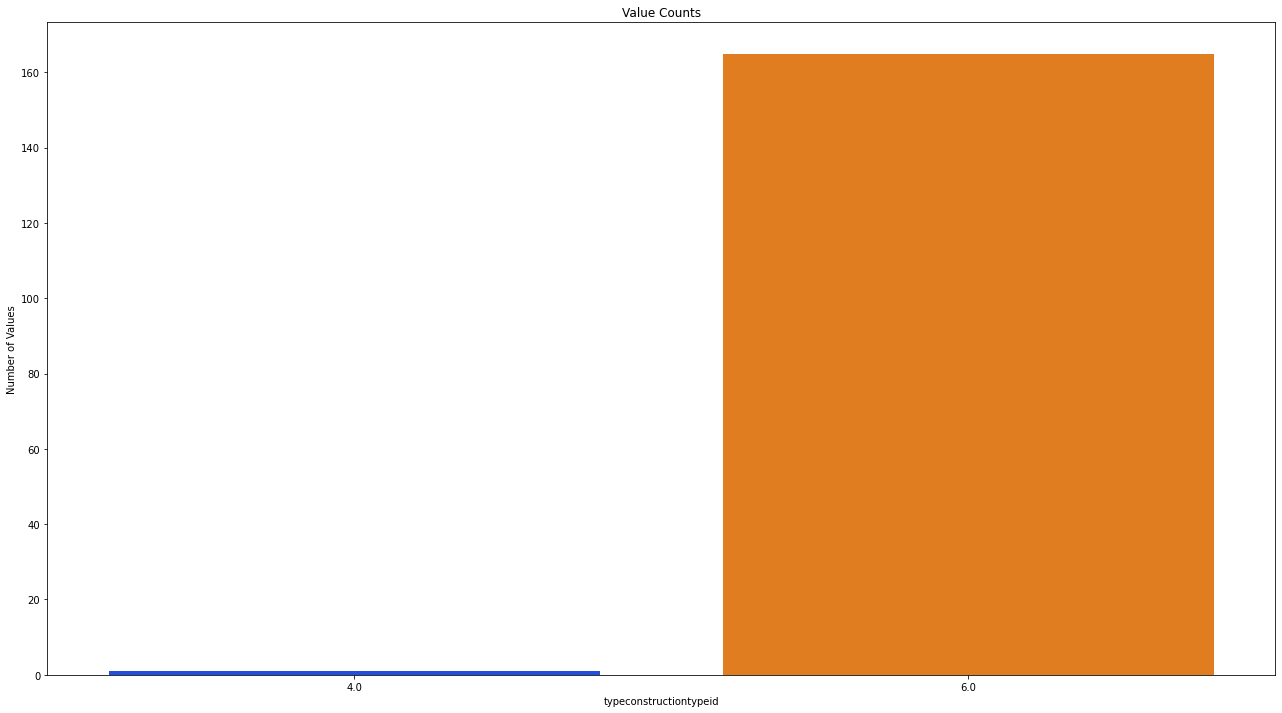

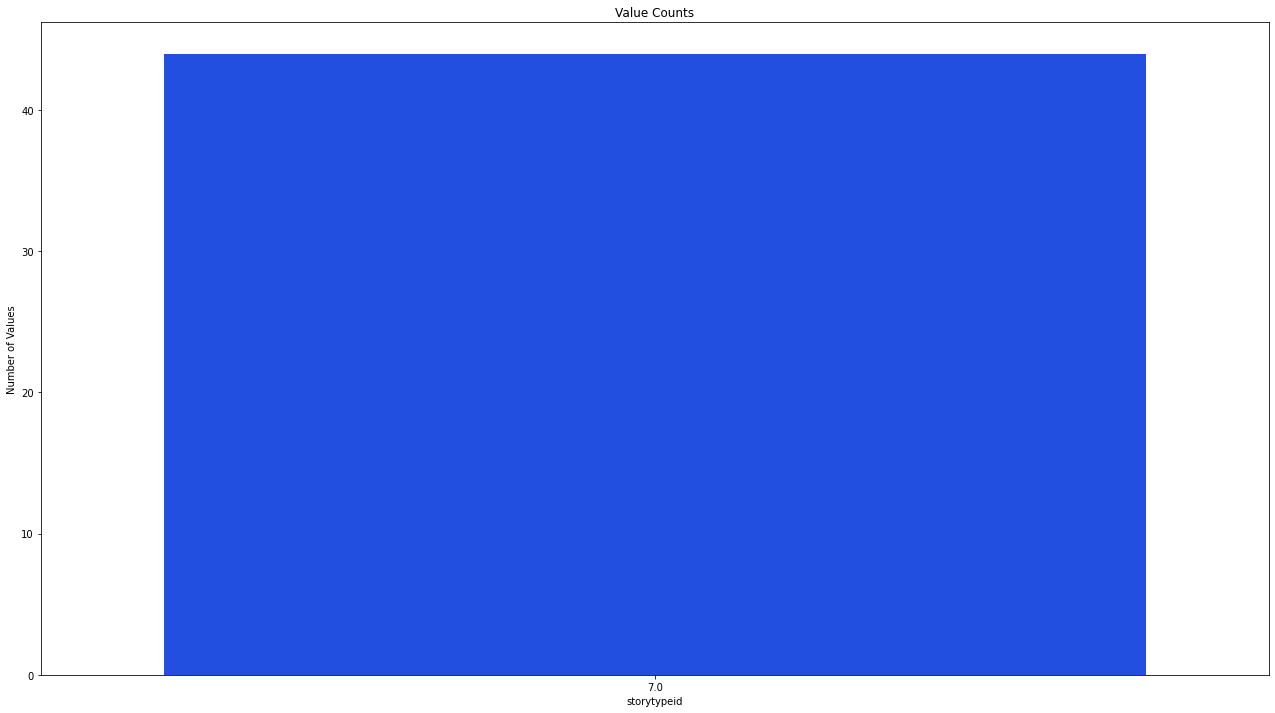

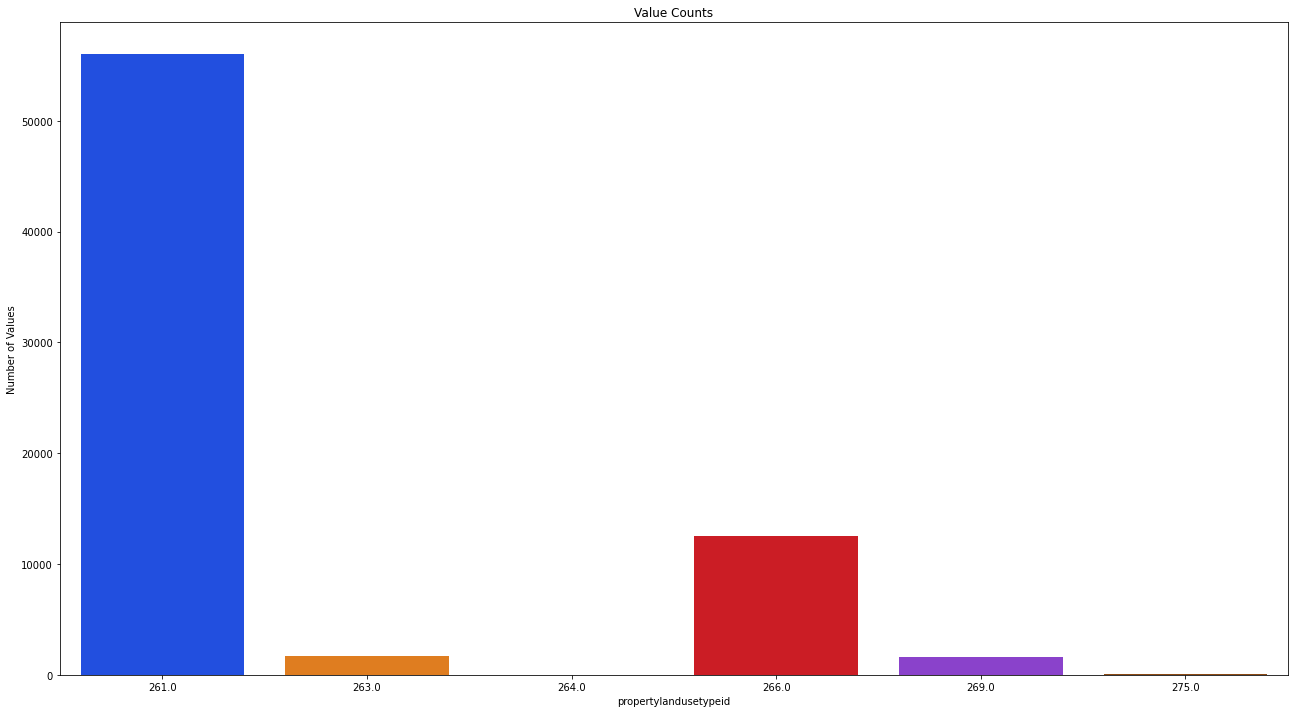

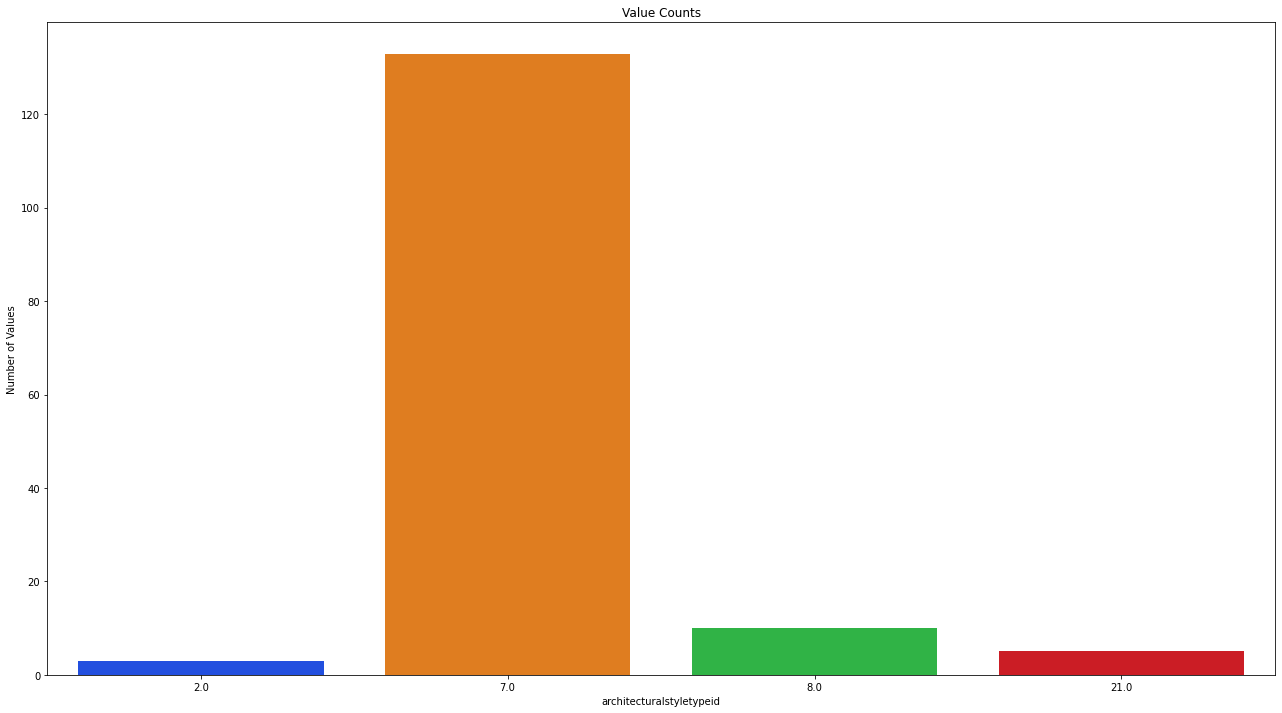

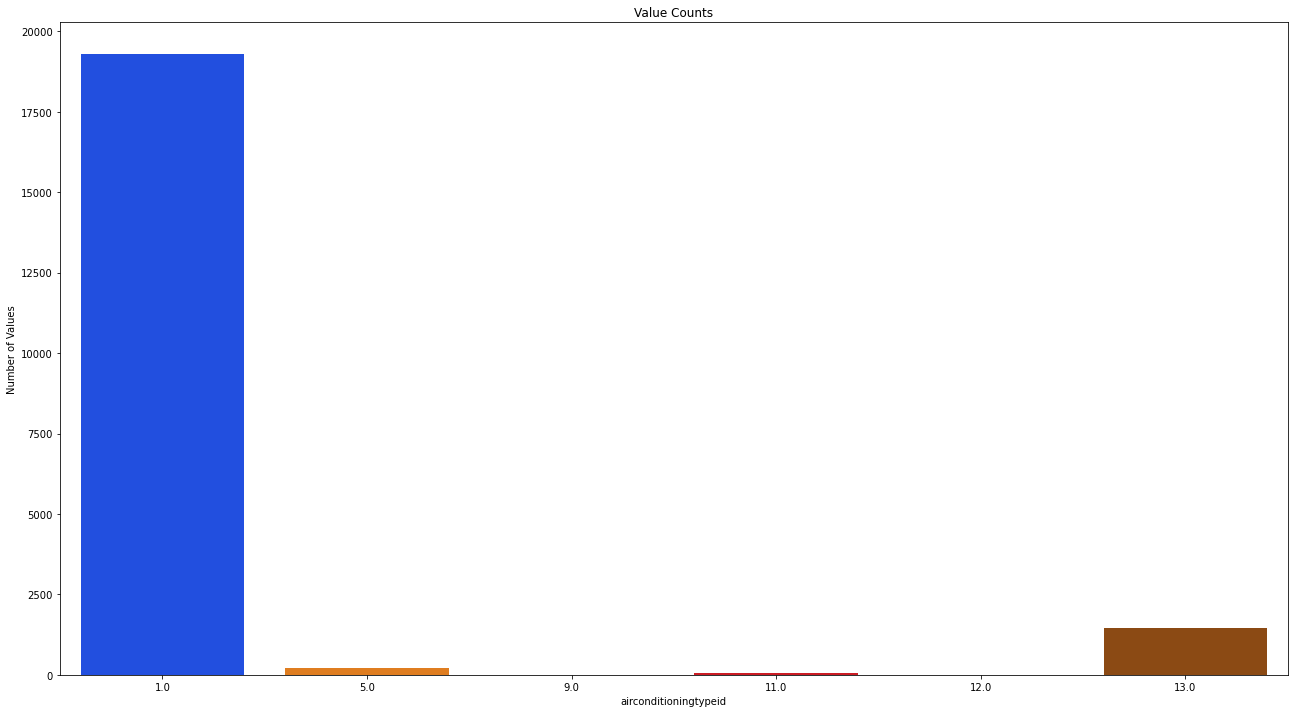

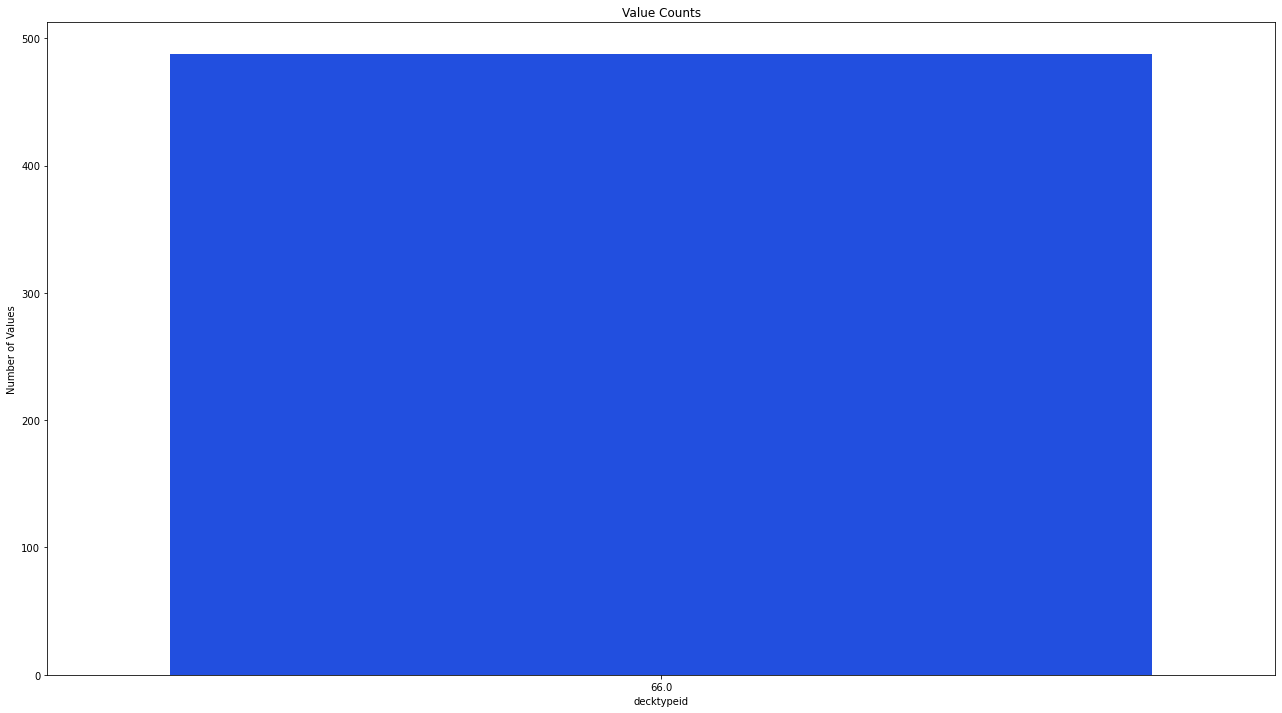

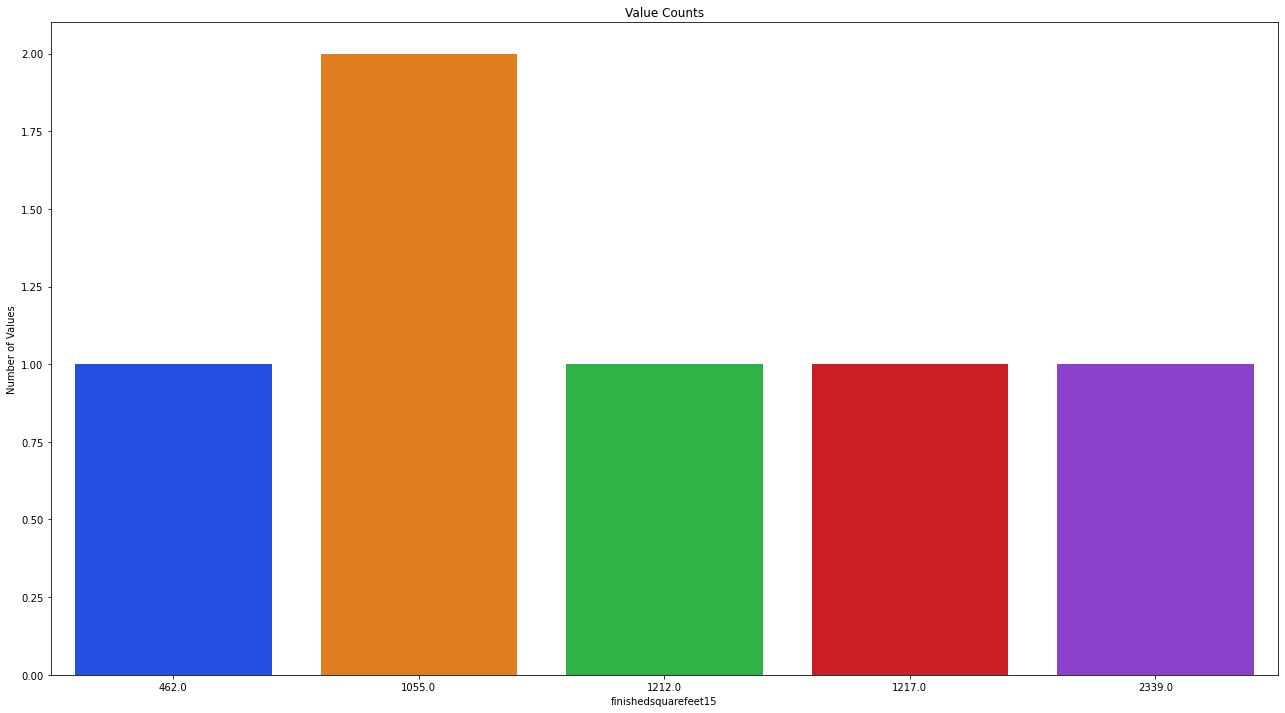

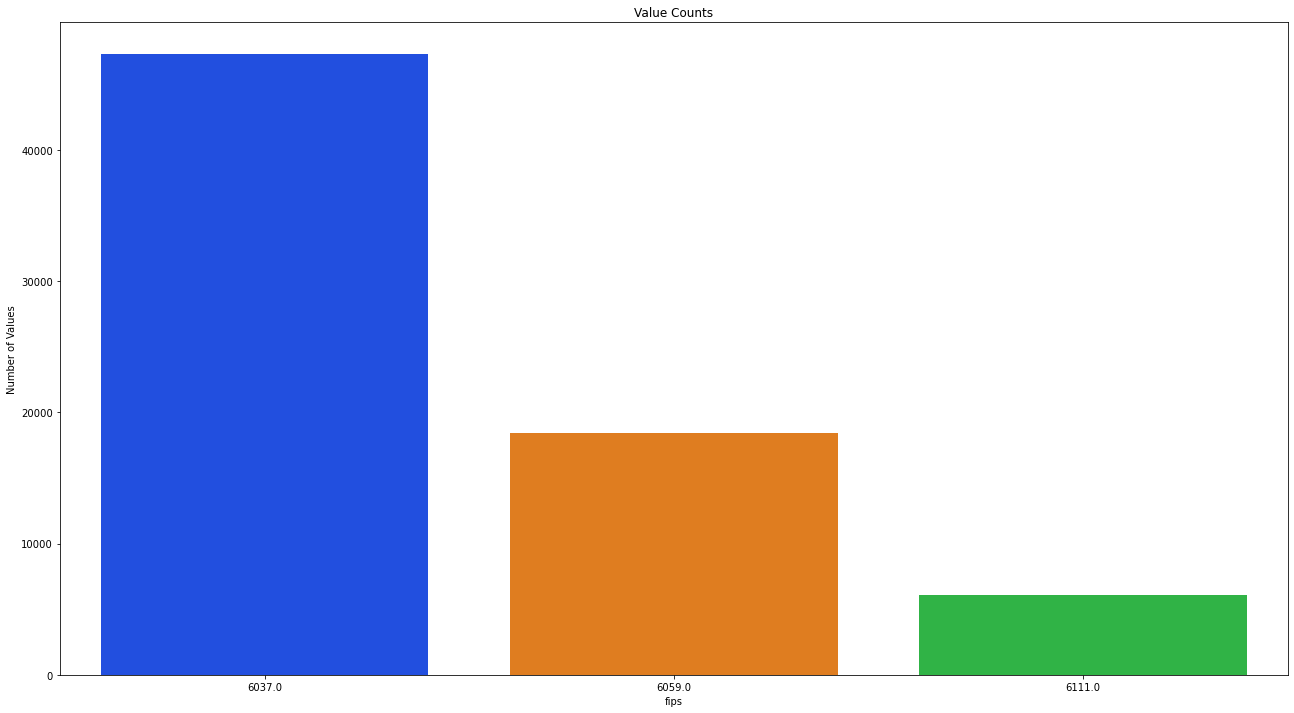

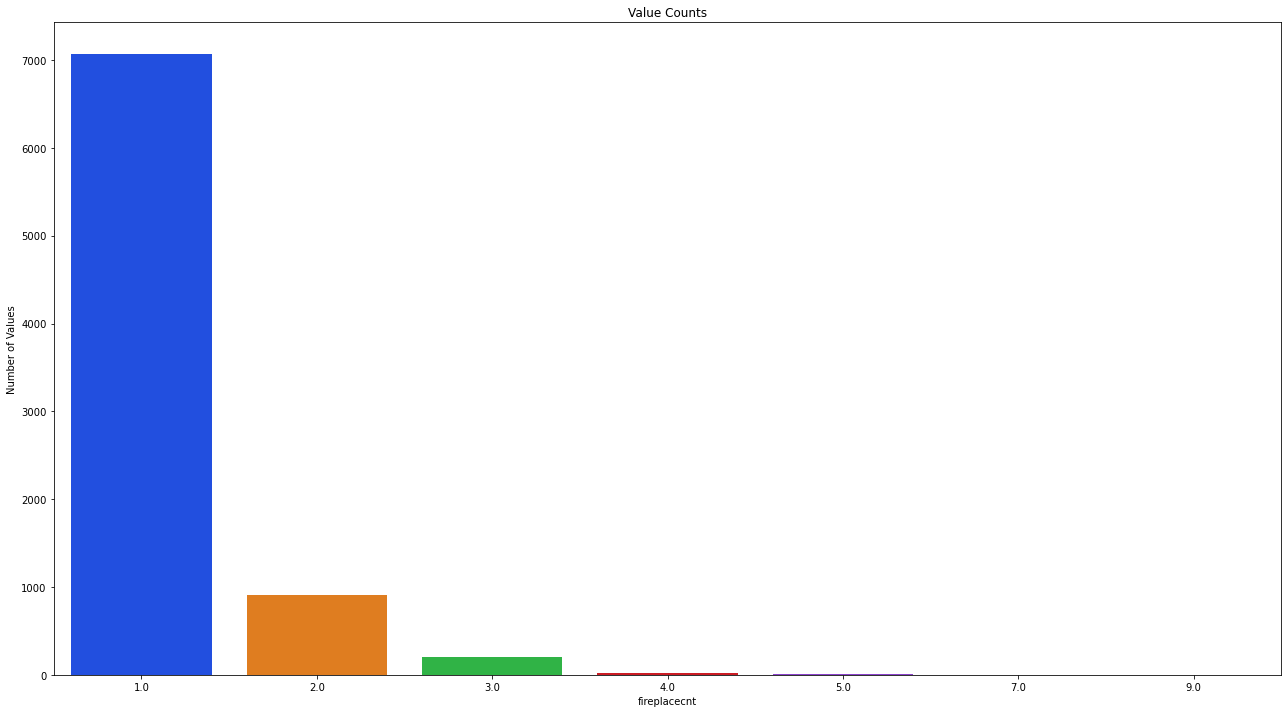

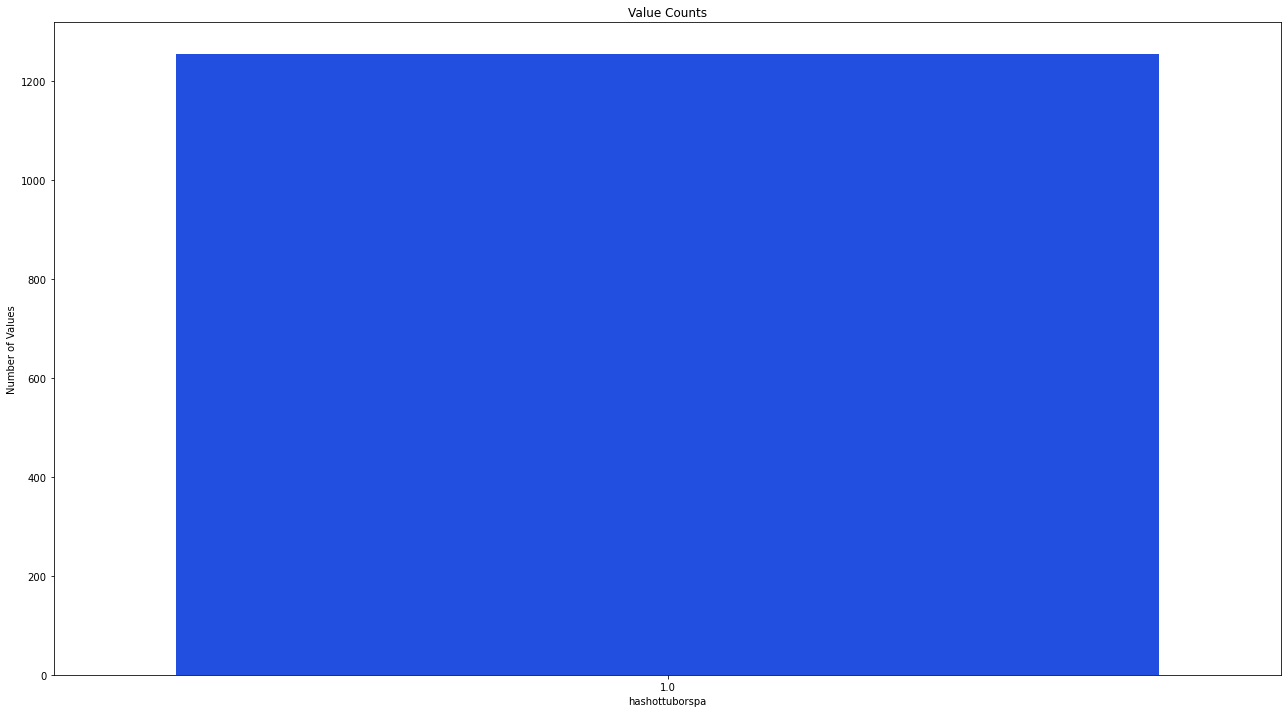

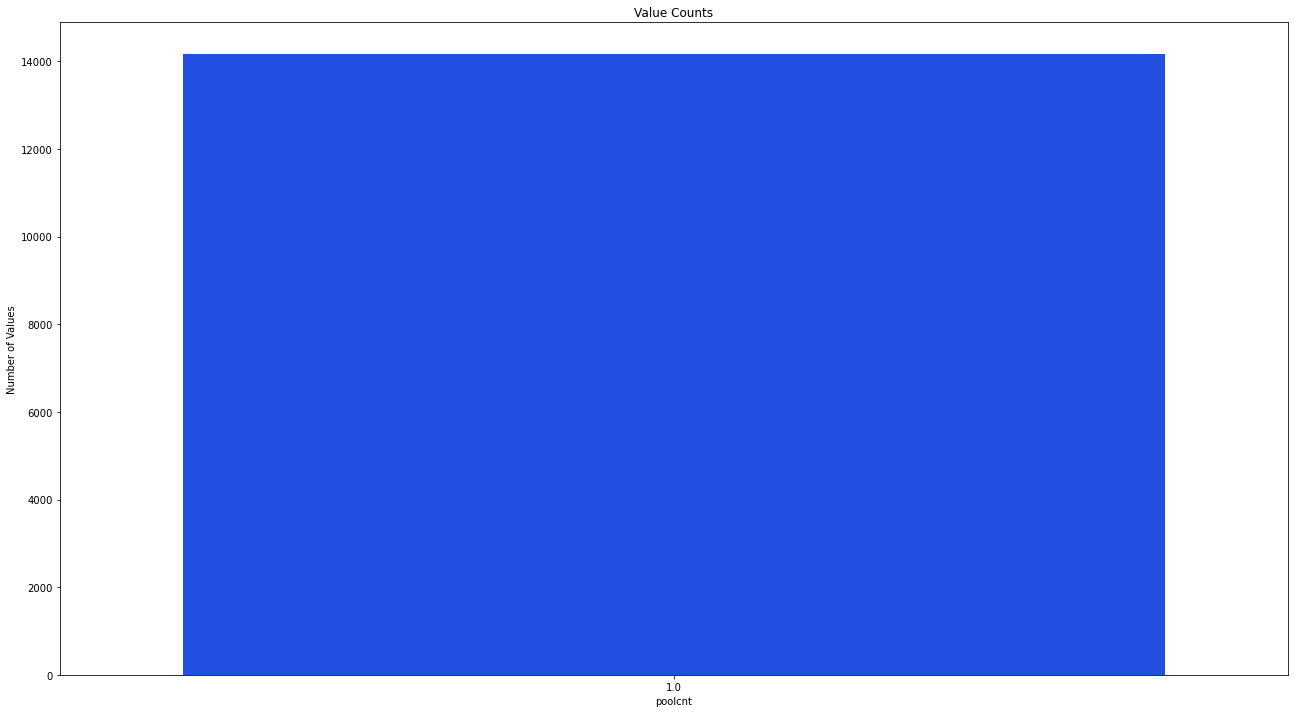

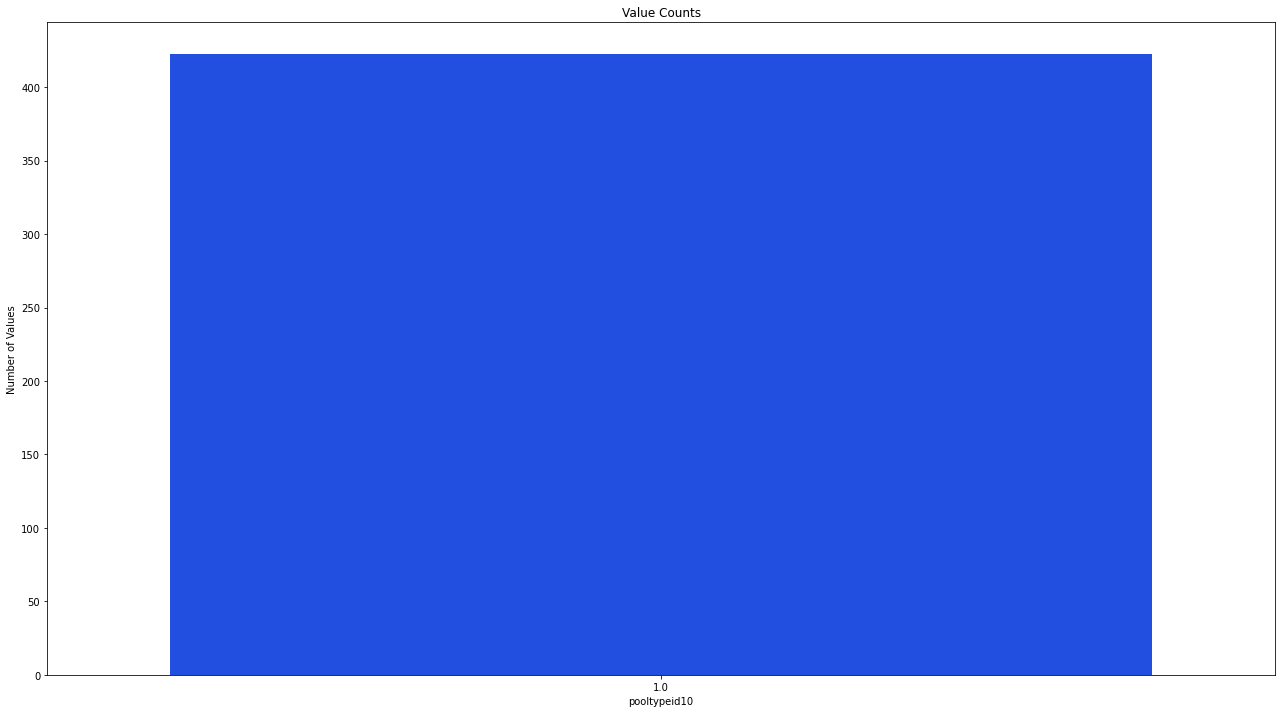

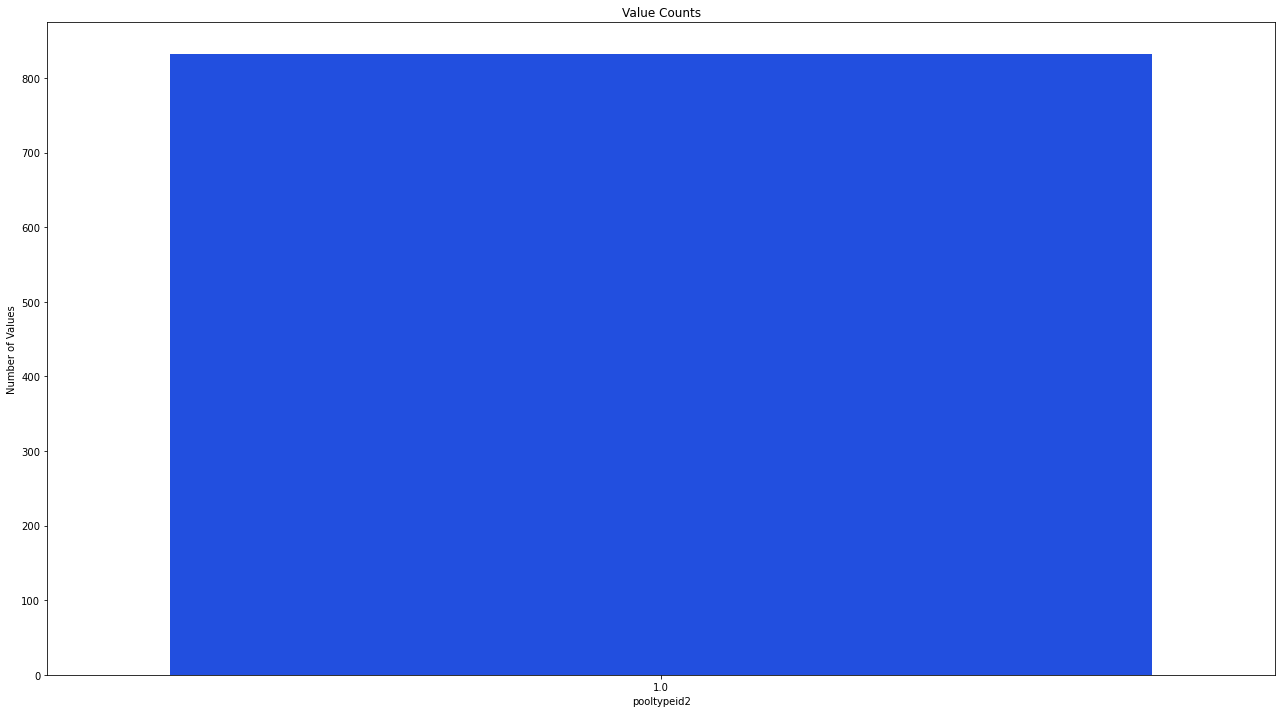

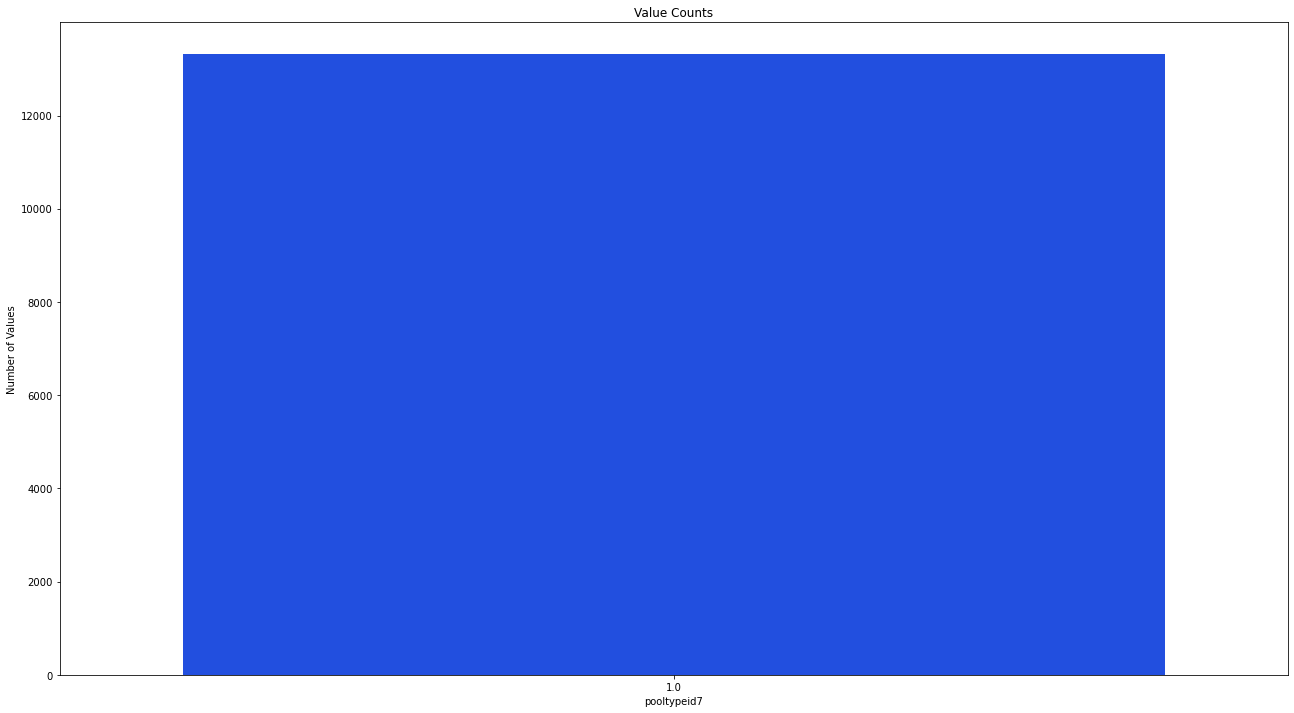

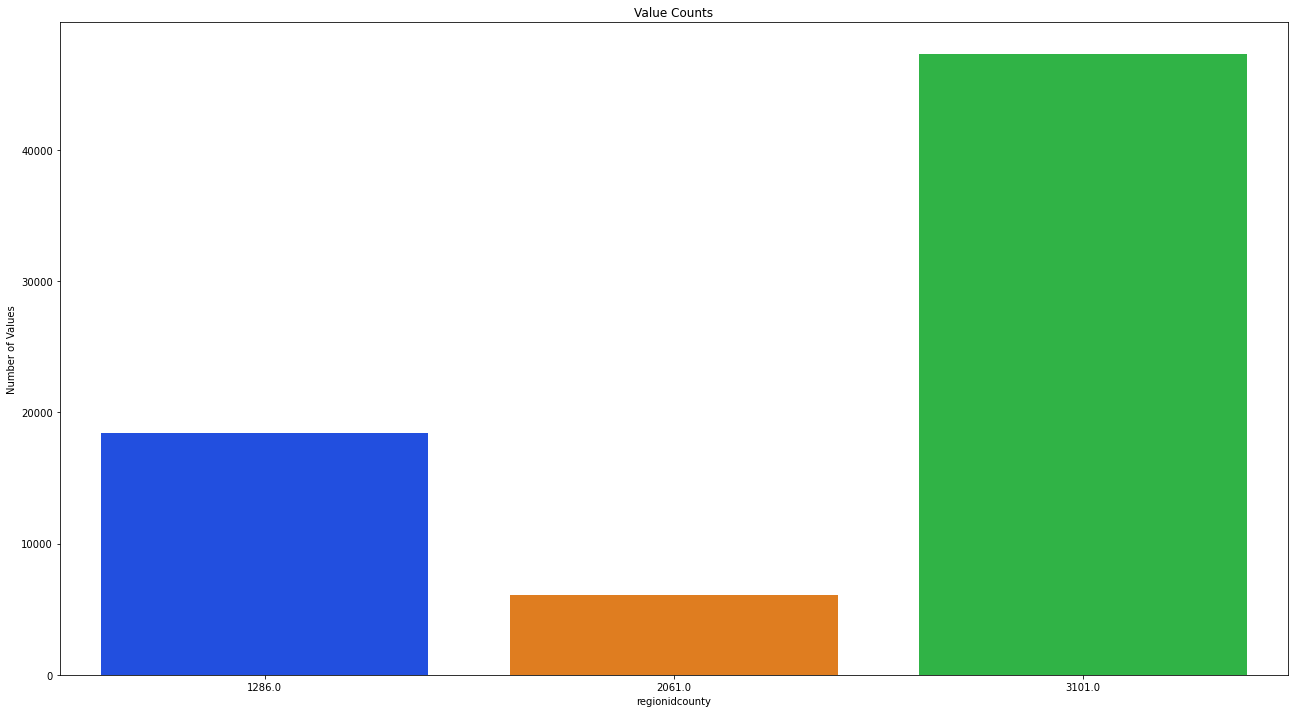

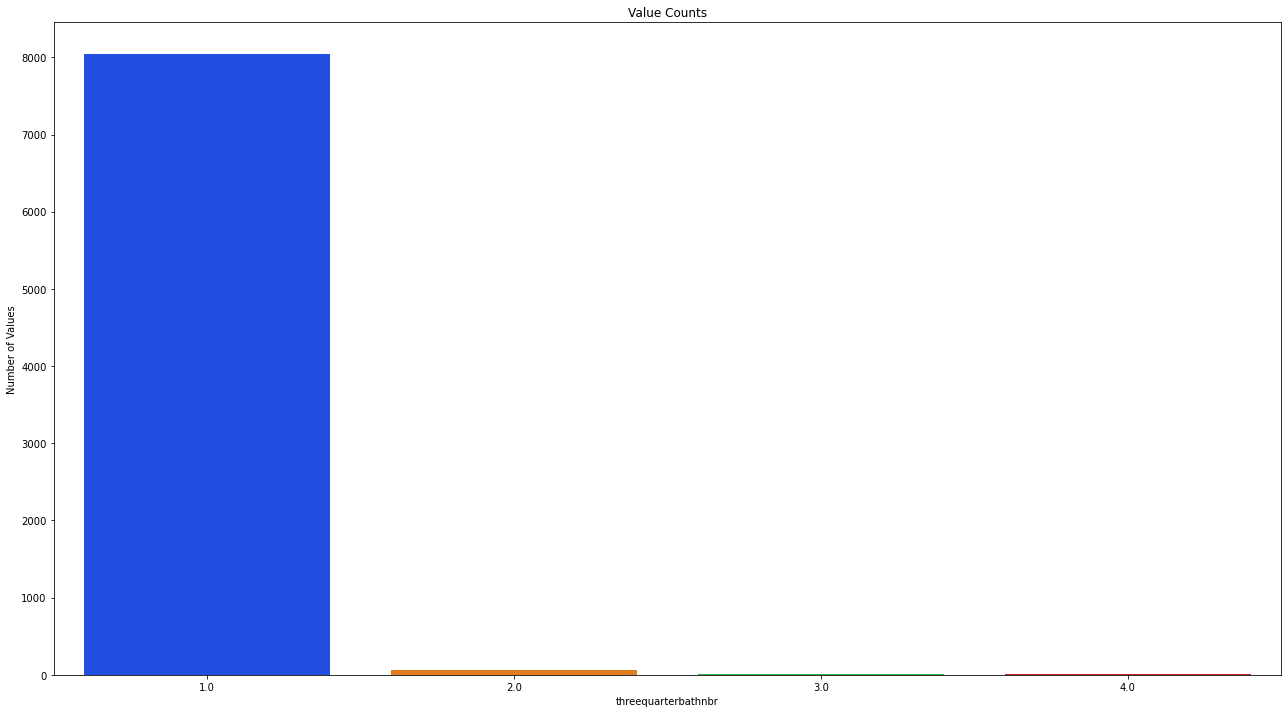

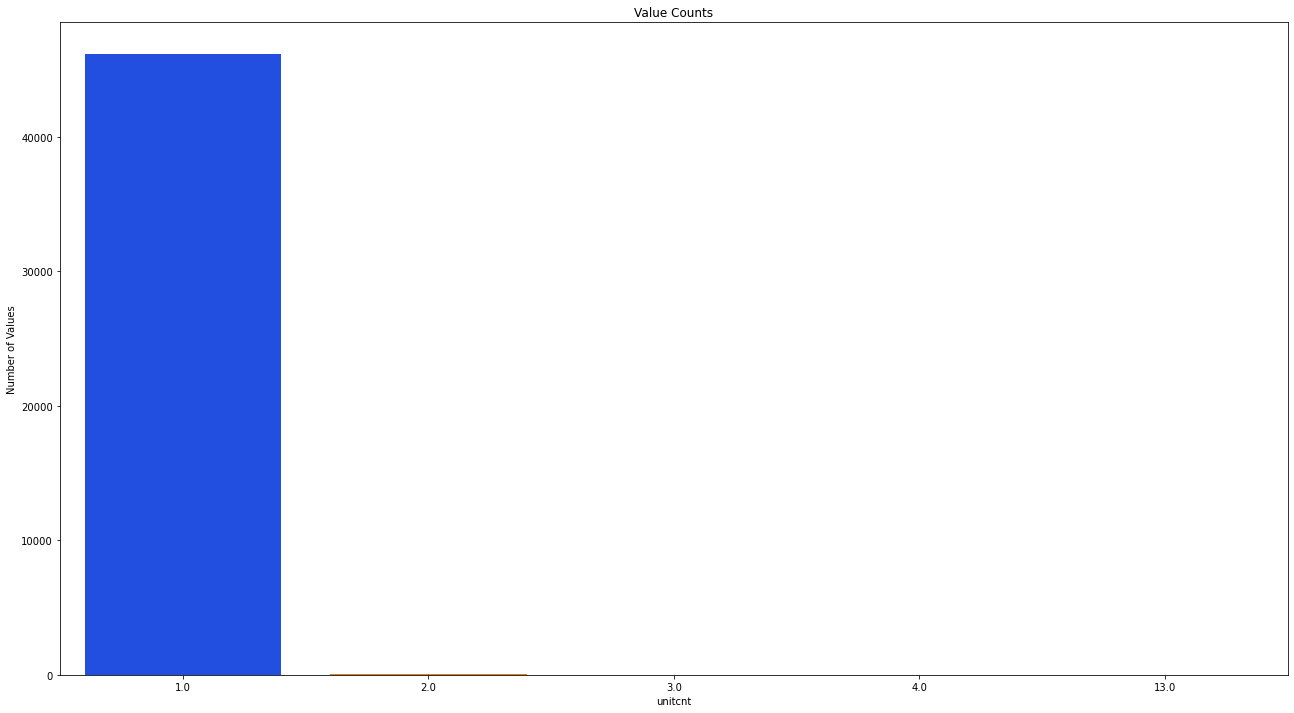

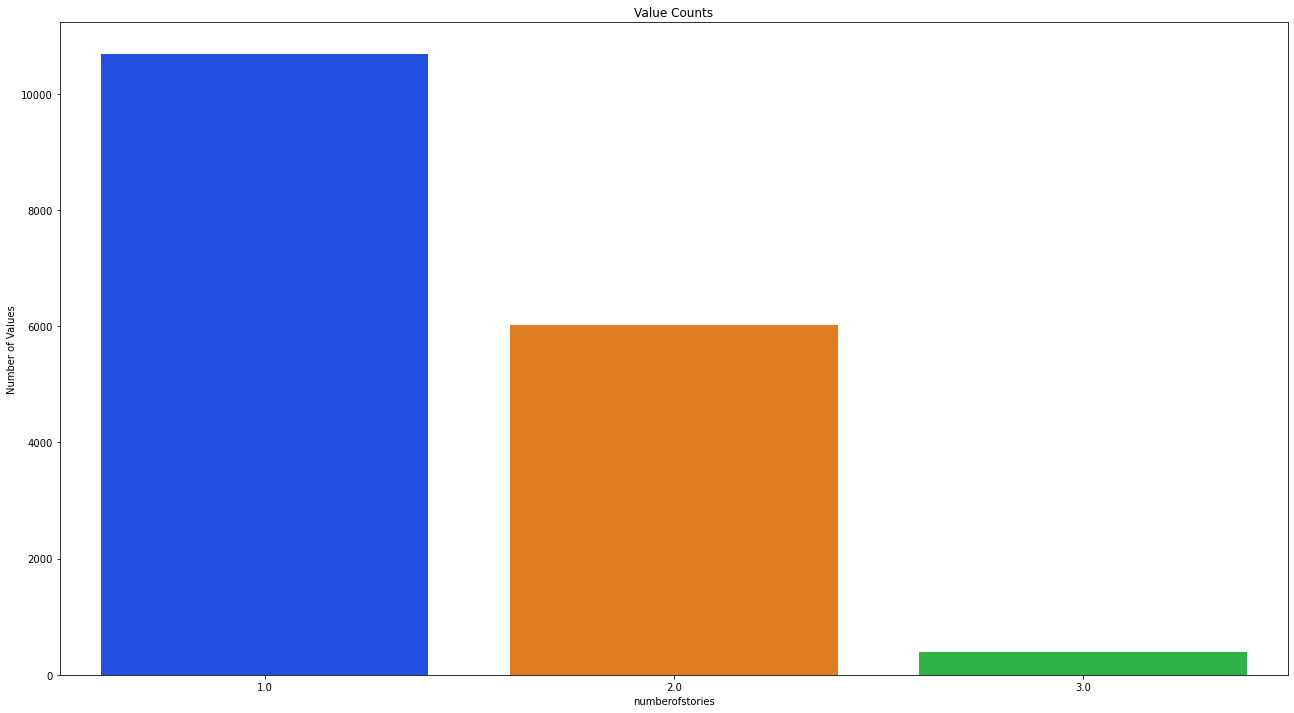

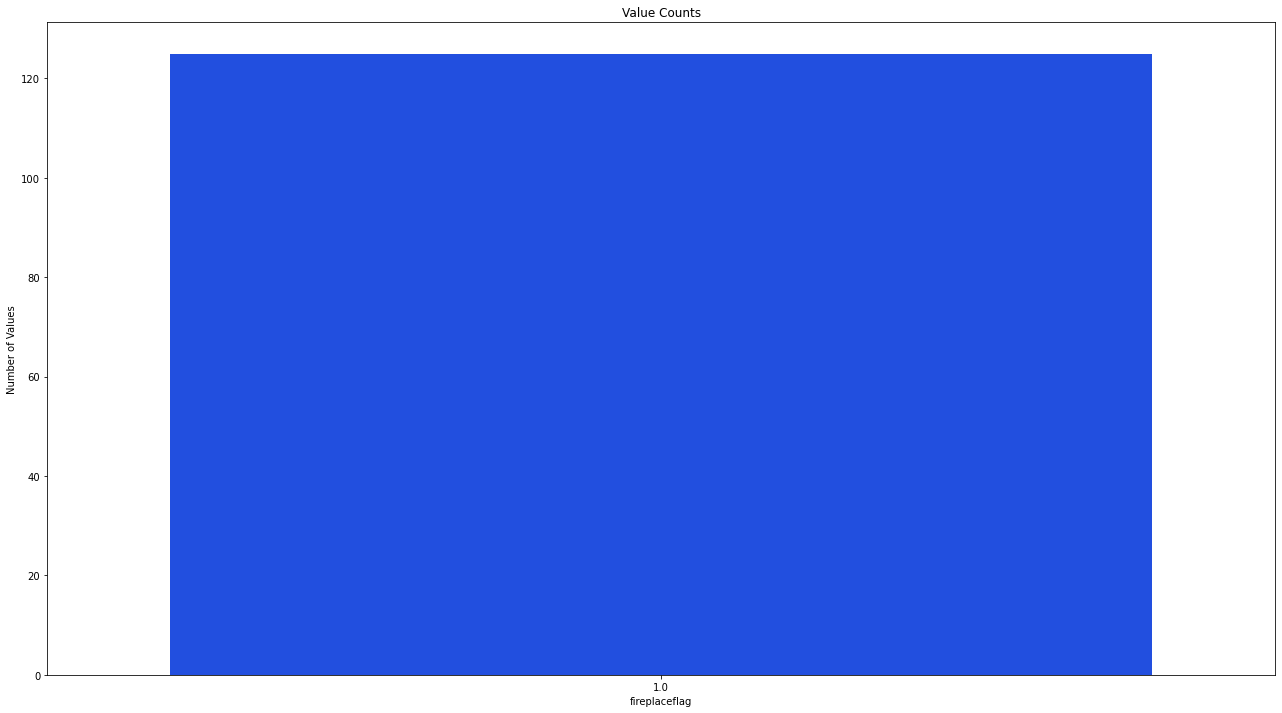

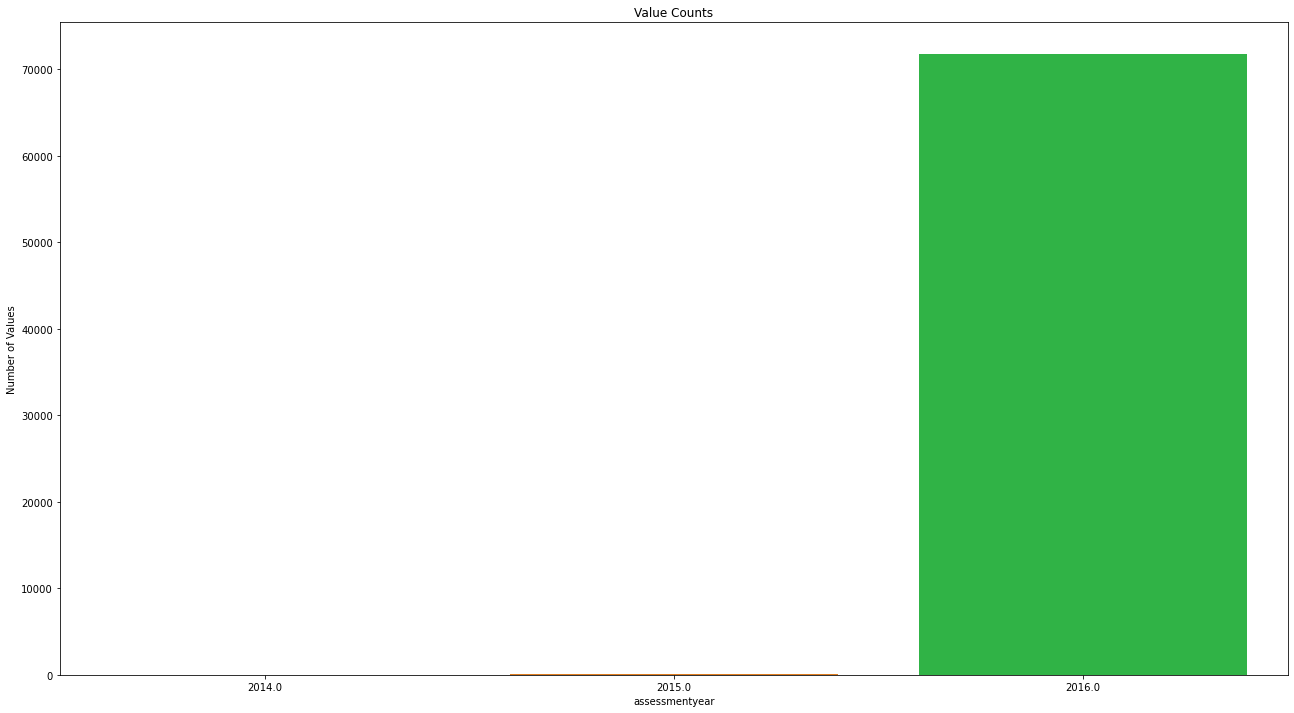

In [10]:
numeric_values_low_value_count(df)

<AxesSubplot:title={'center':'Distribution'}, xlabel='logerror', ylabel='Number of Values'>

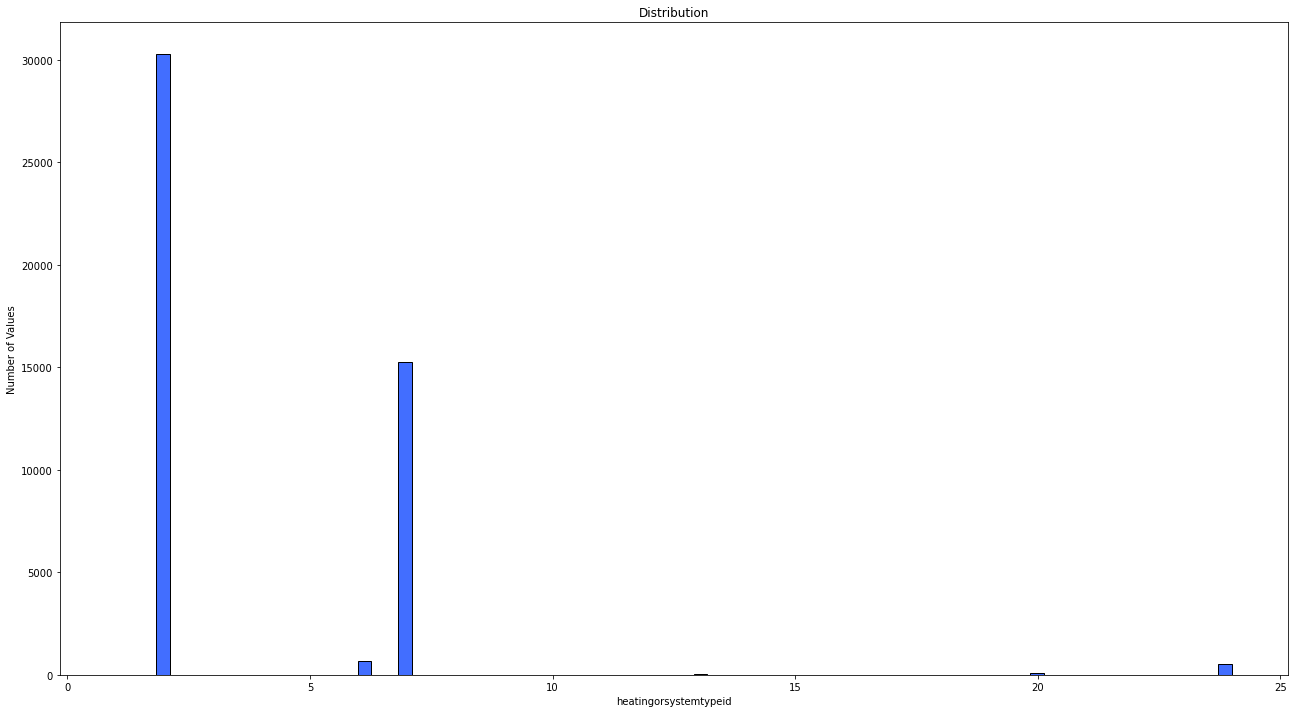

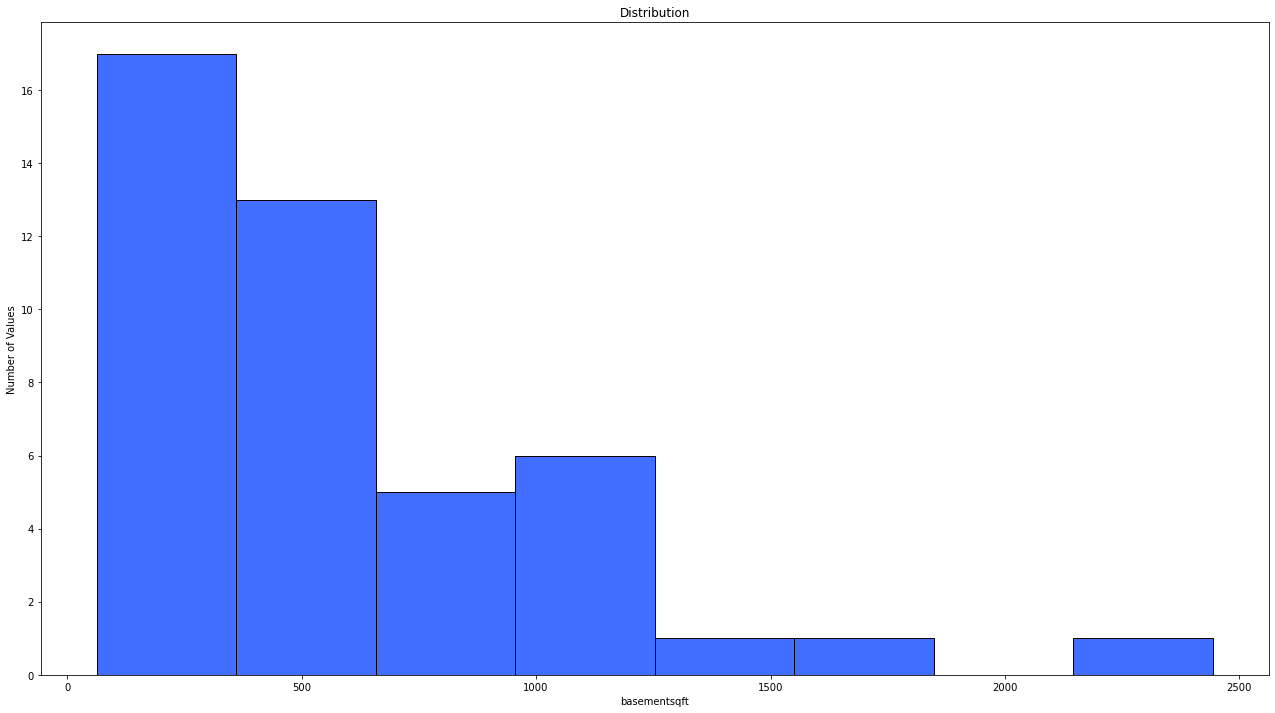

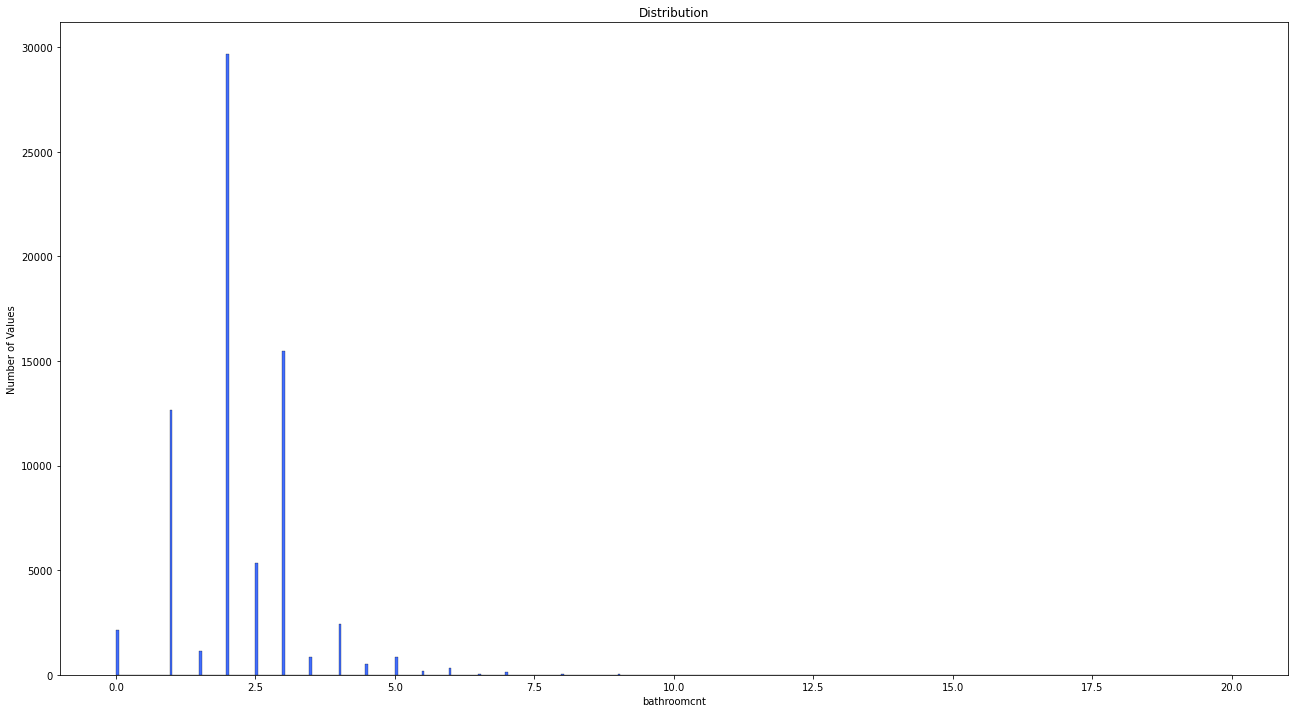

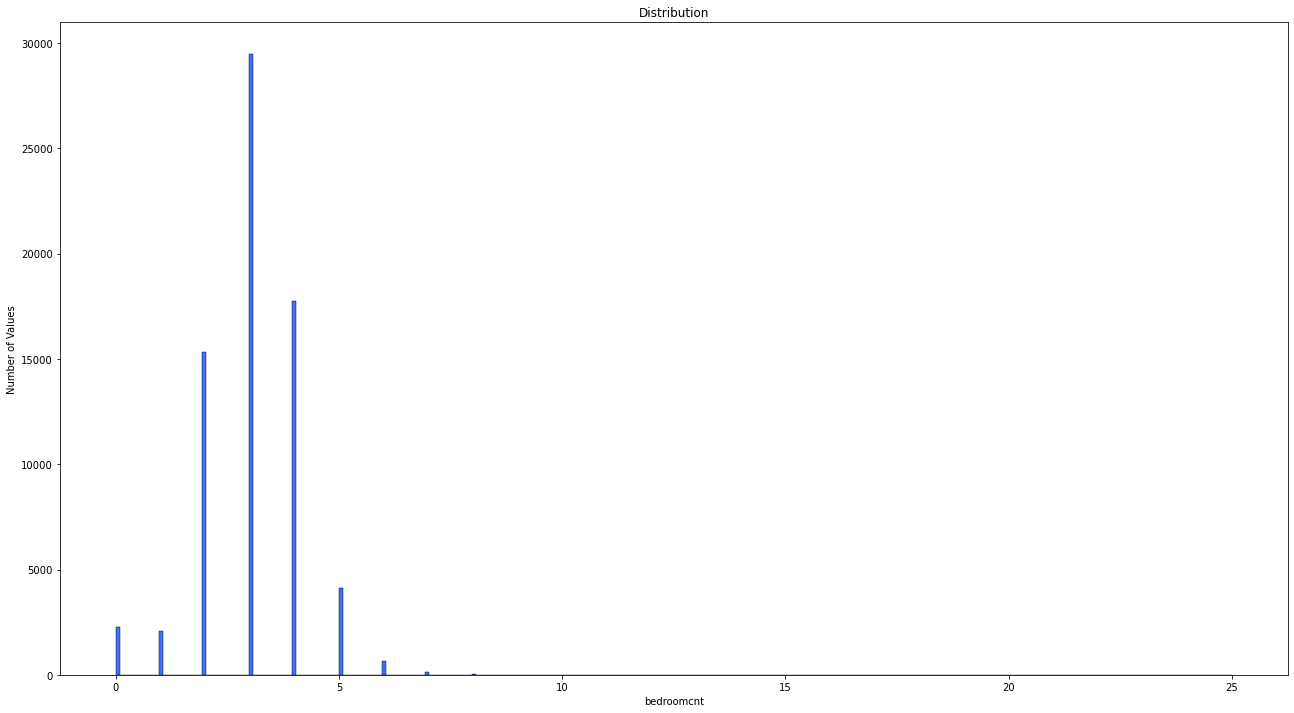

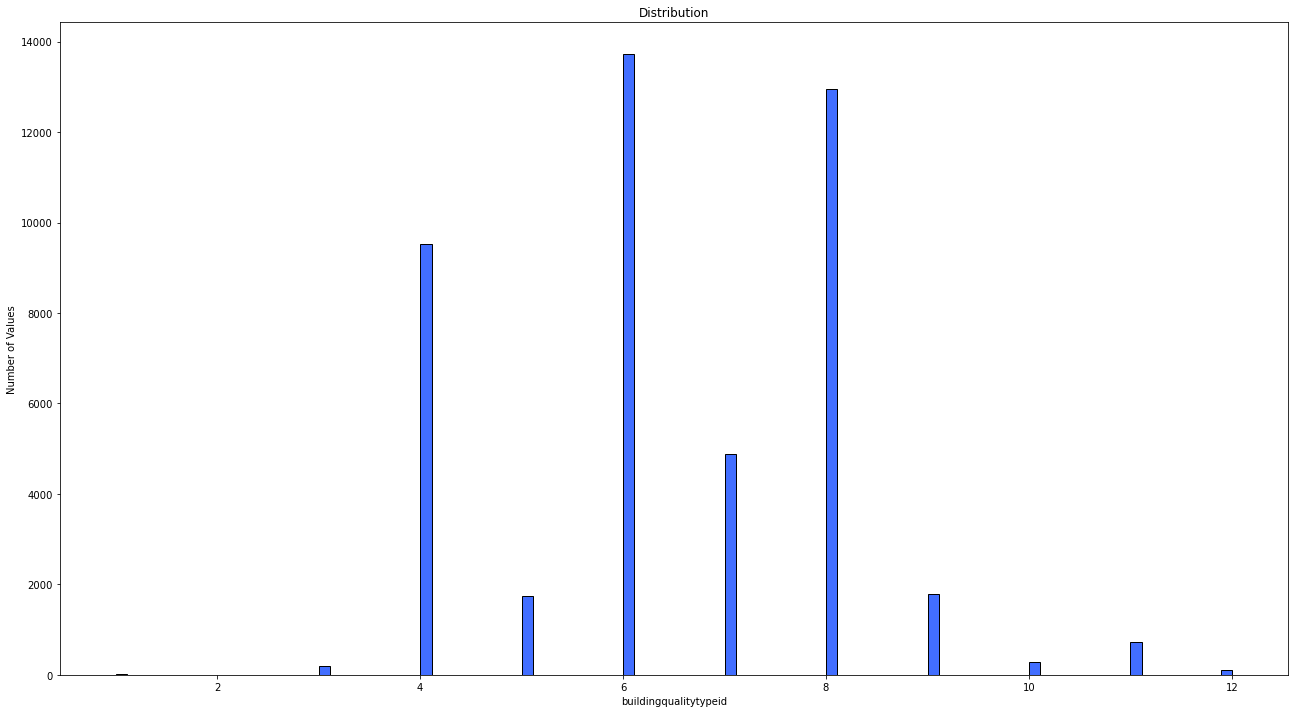

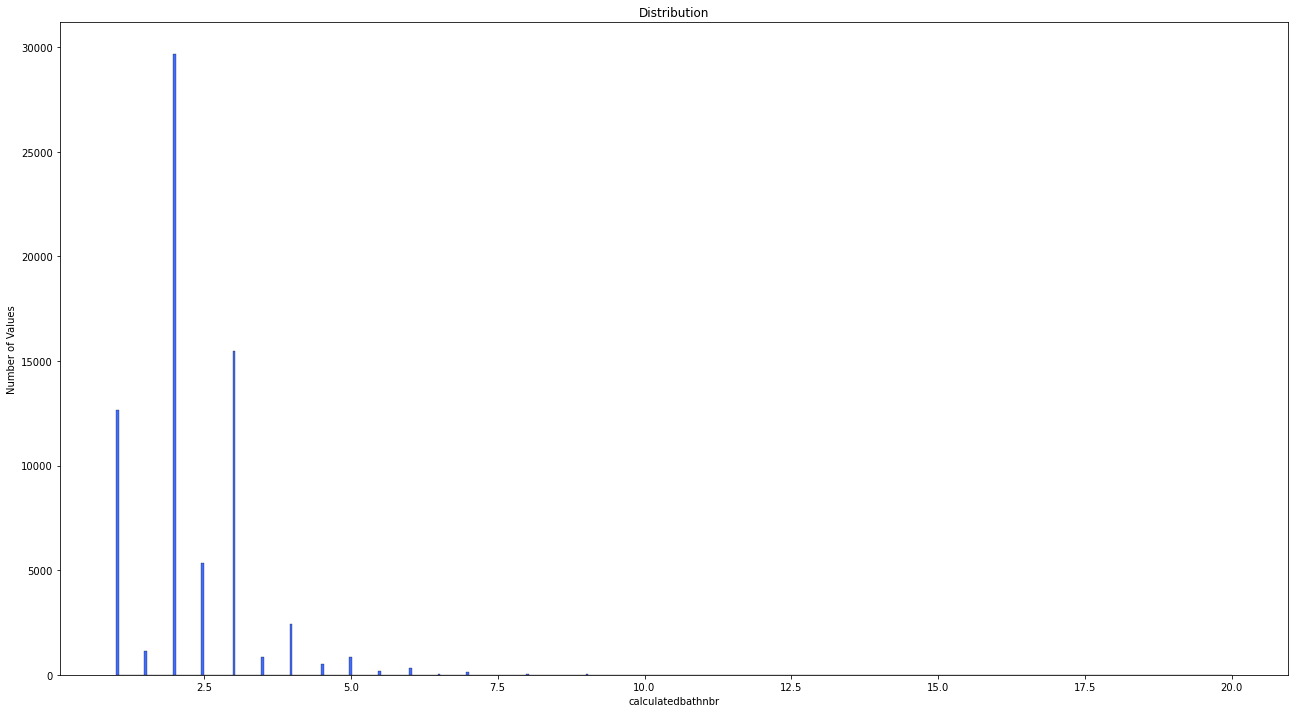

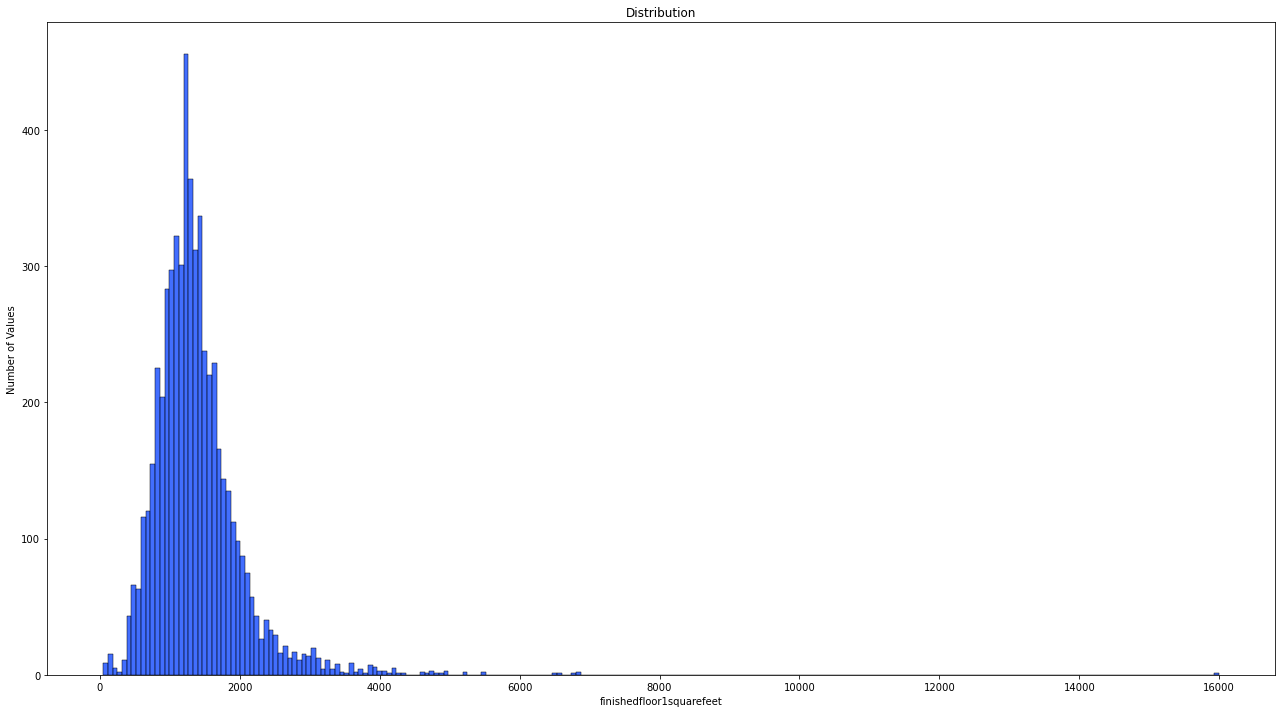

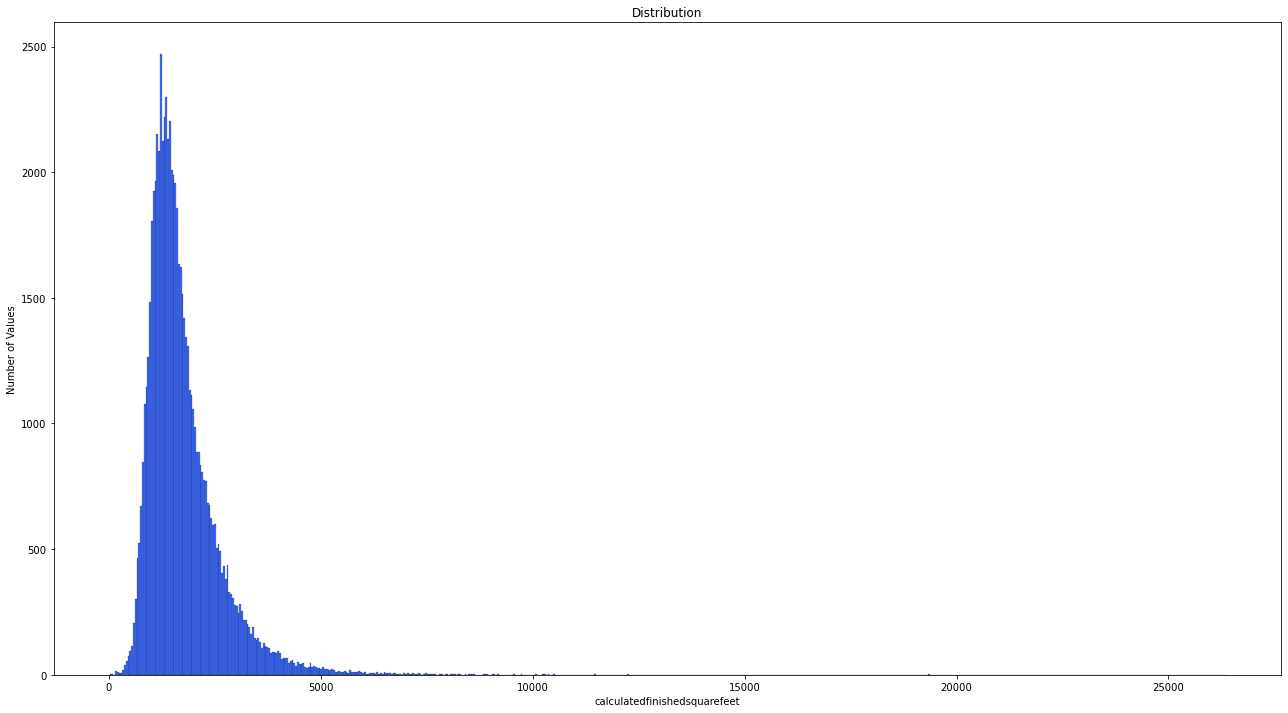

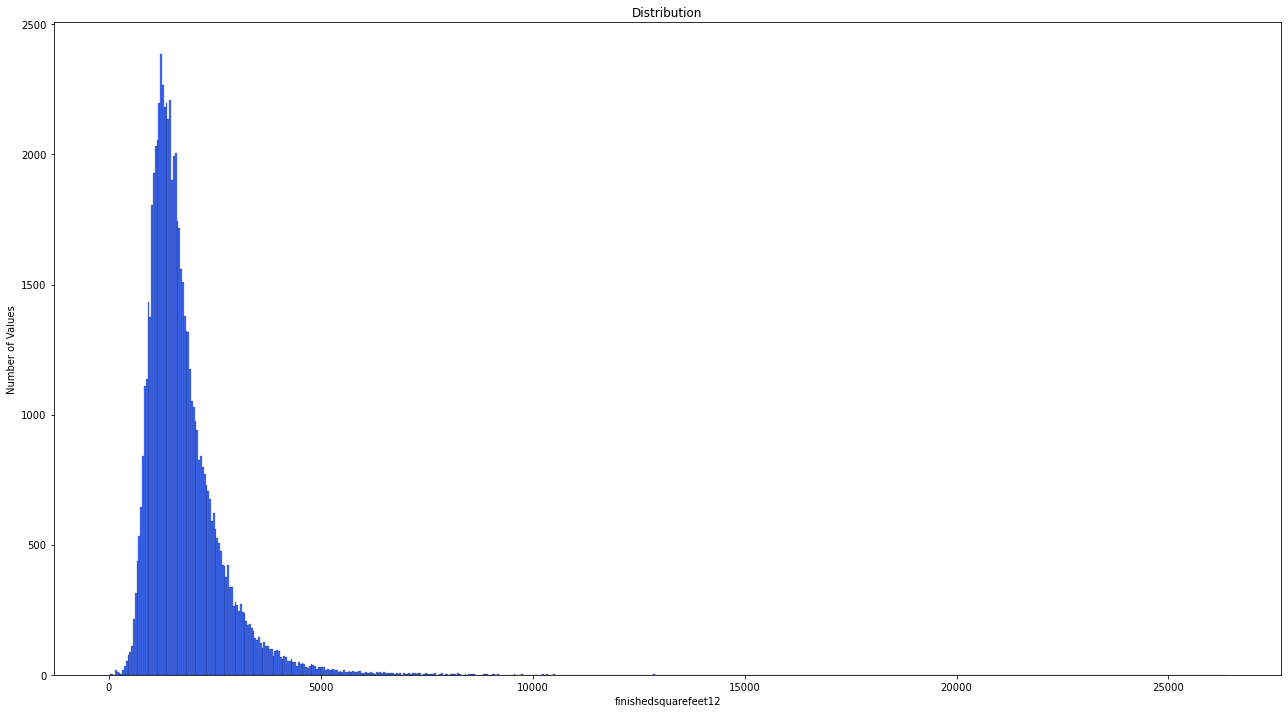

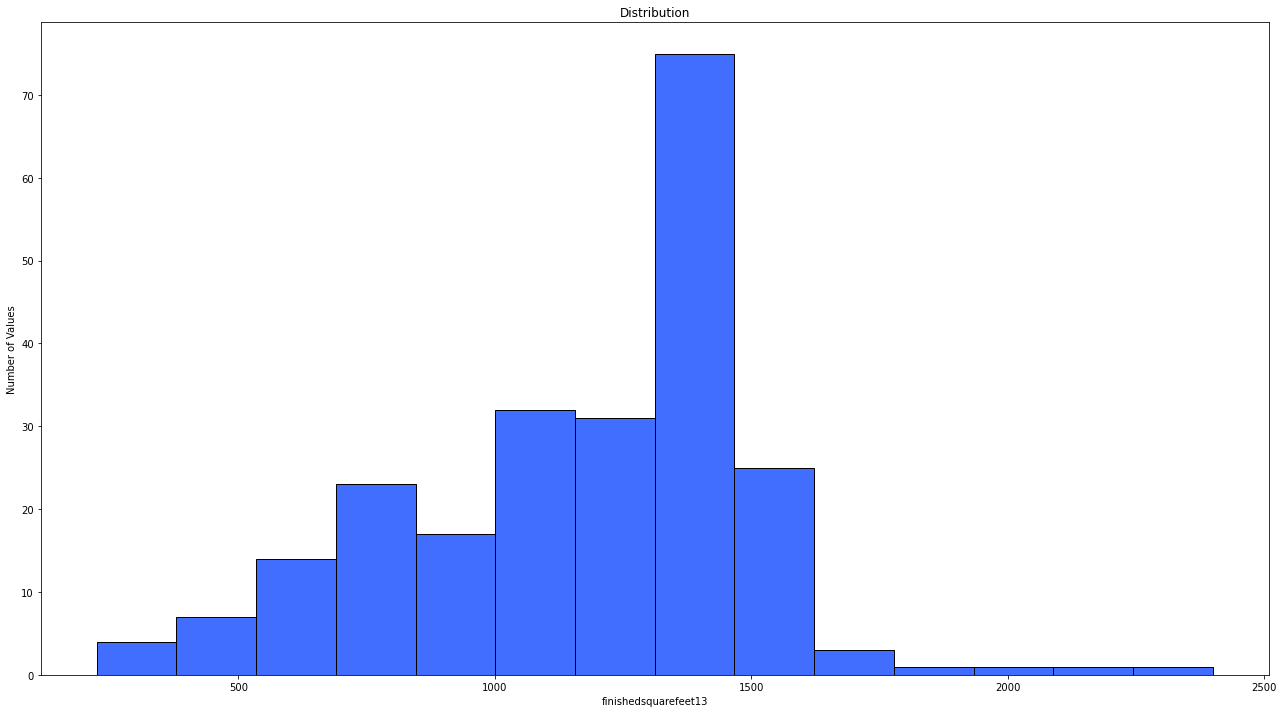

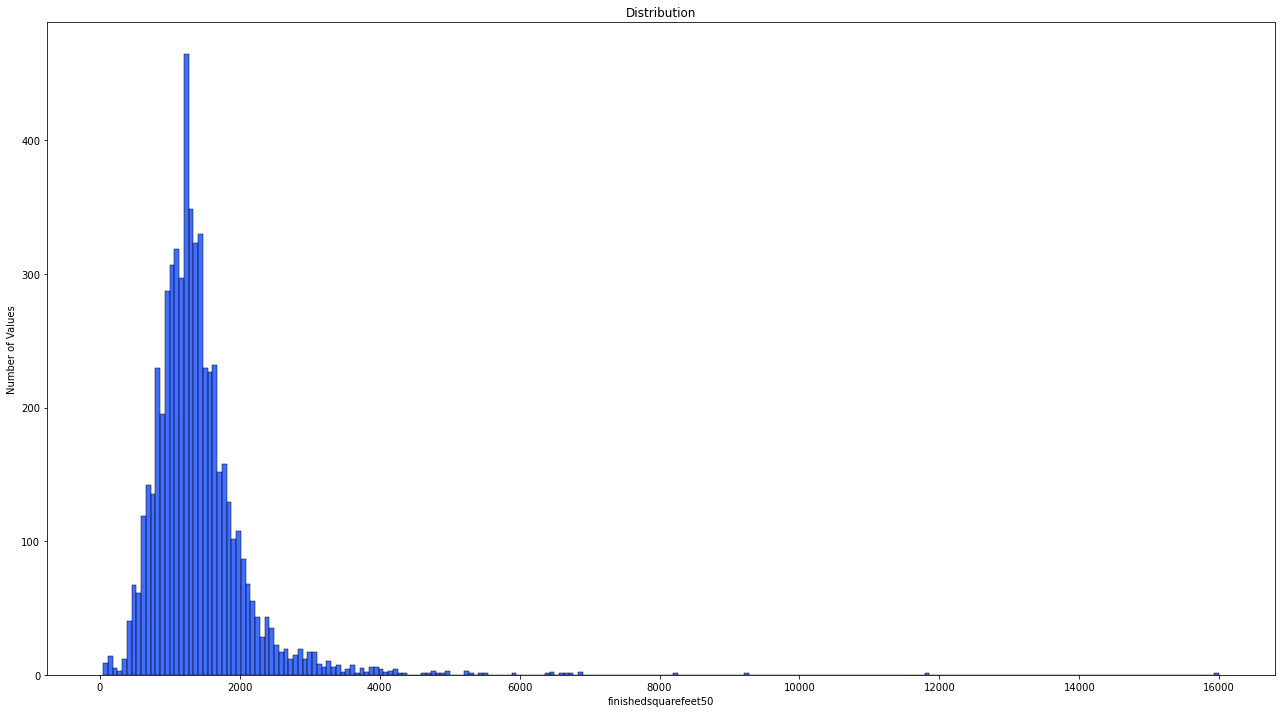

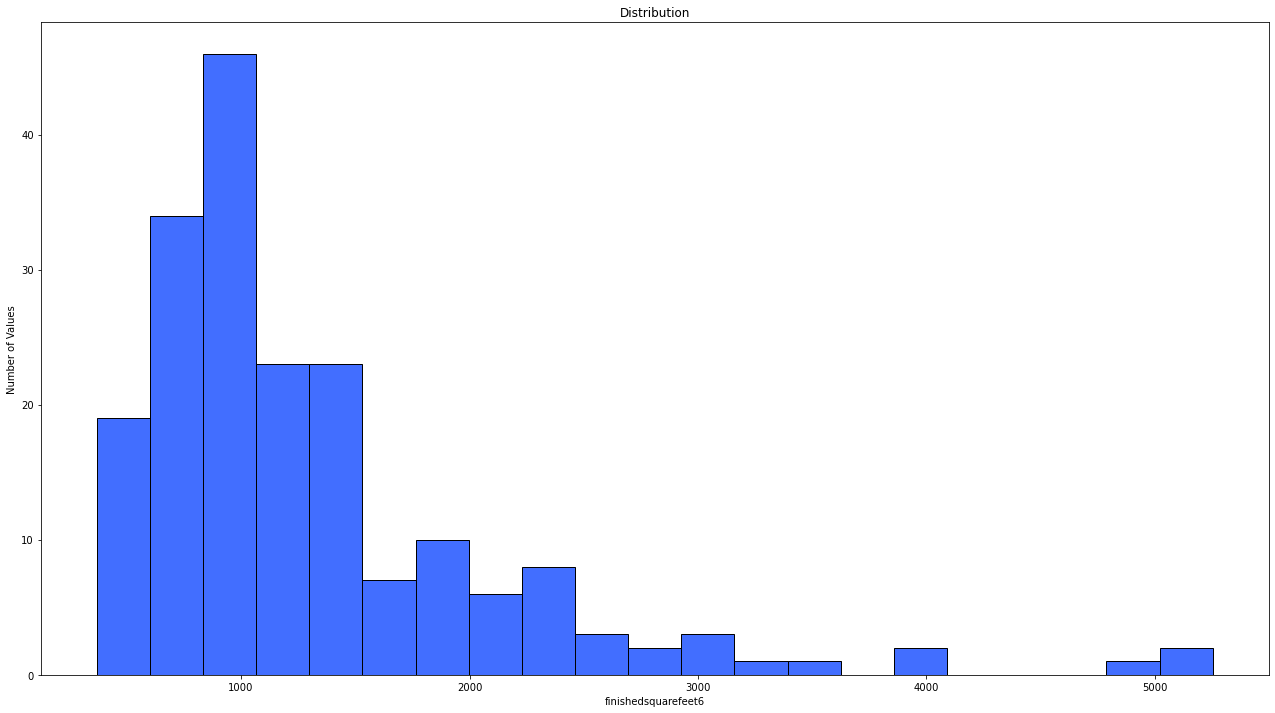

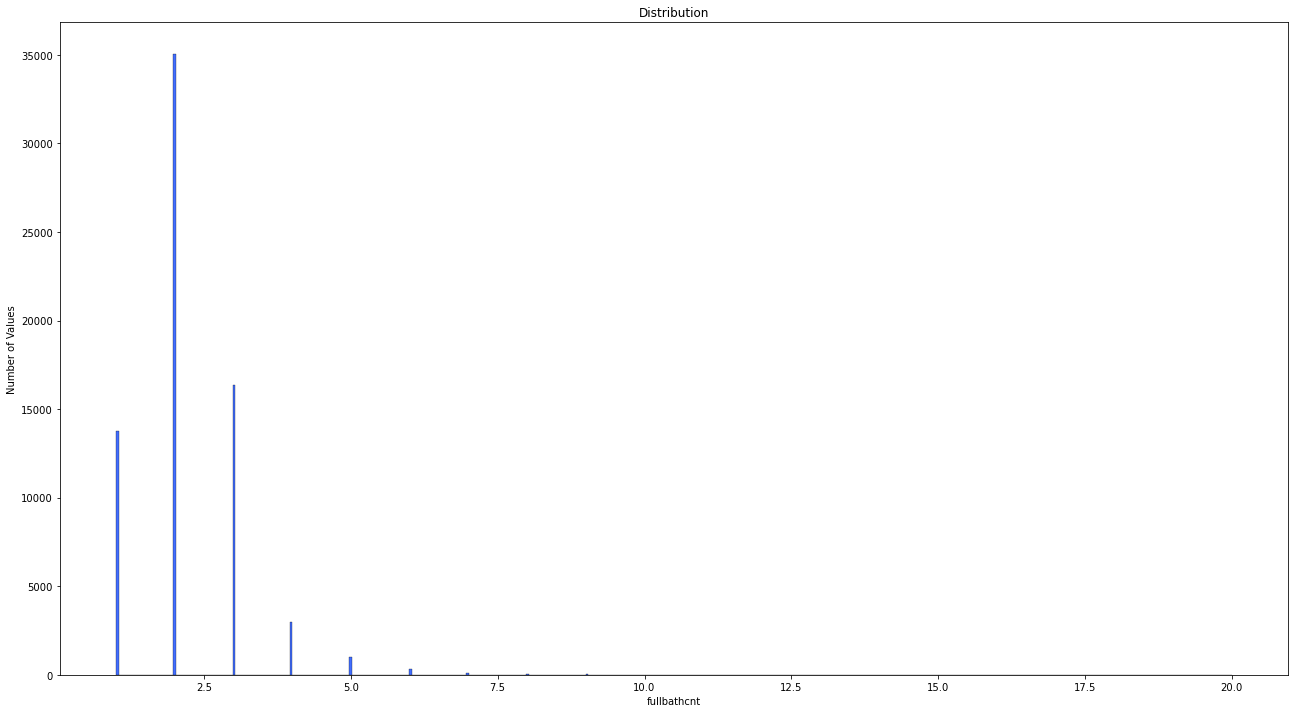

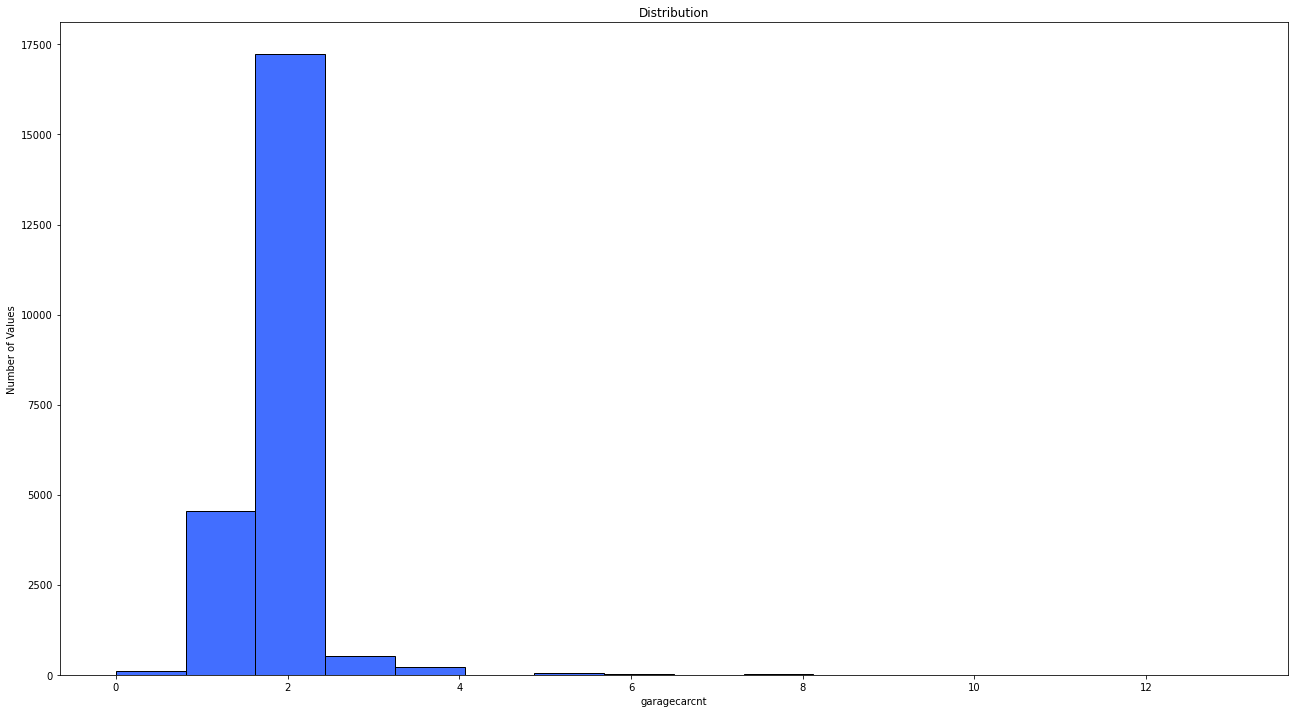

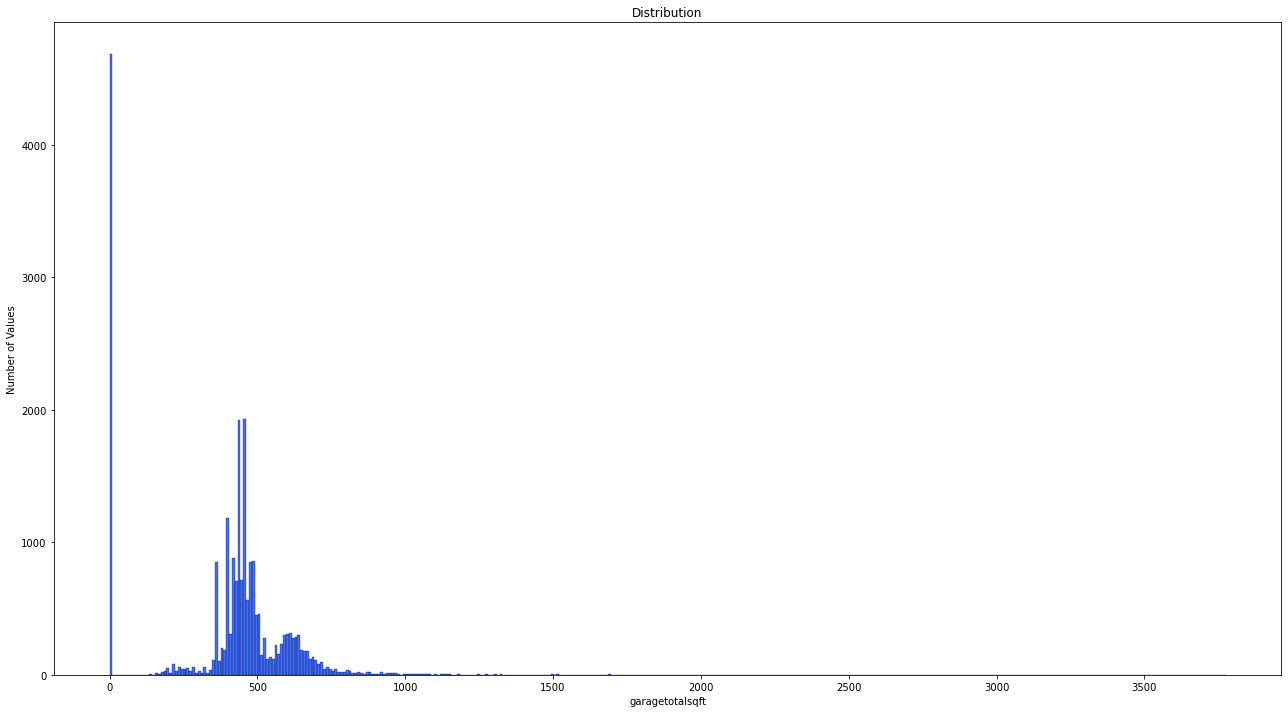

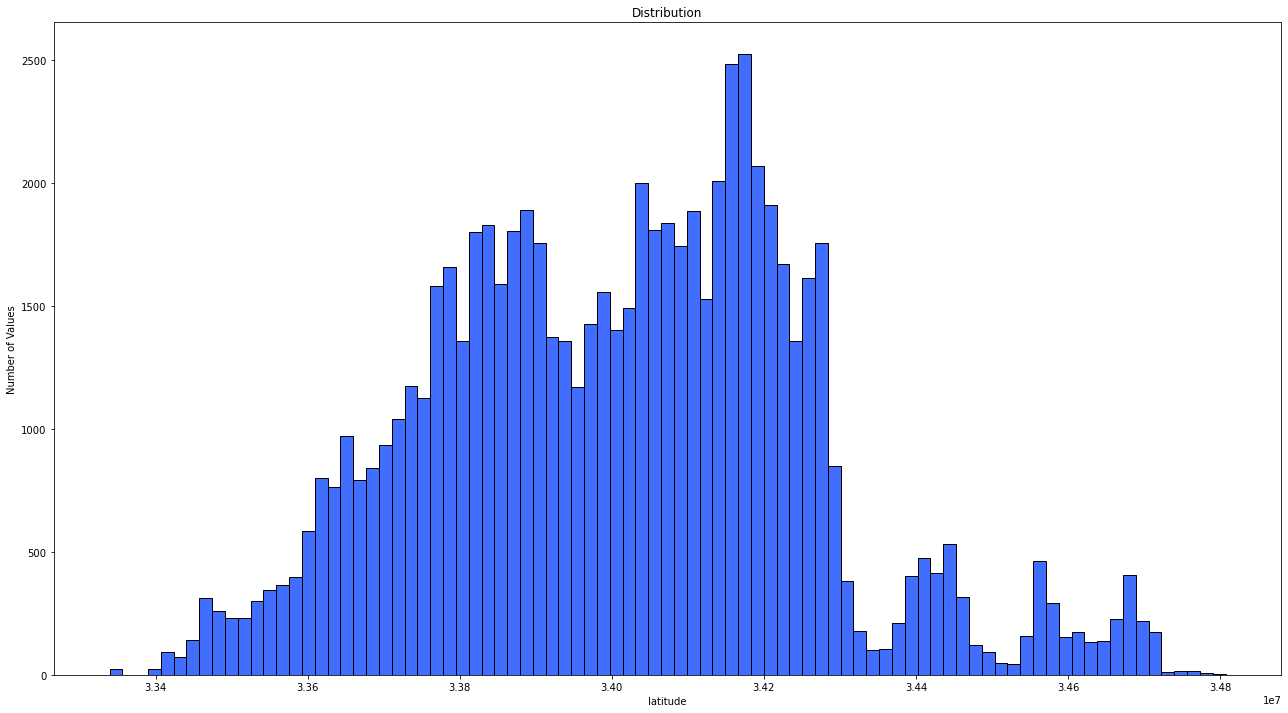

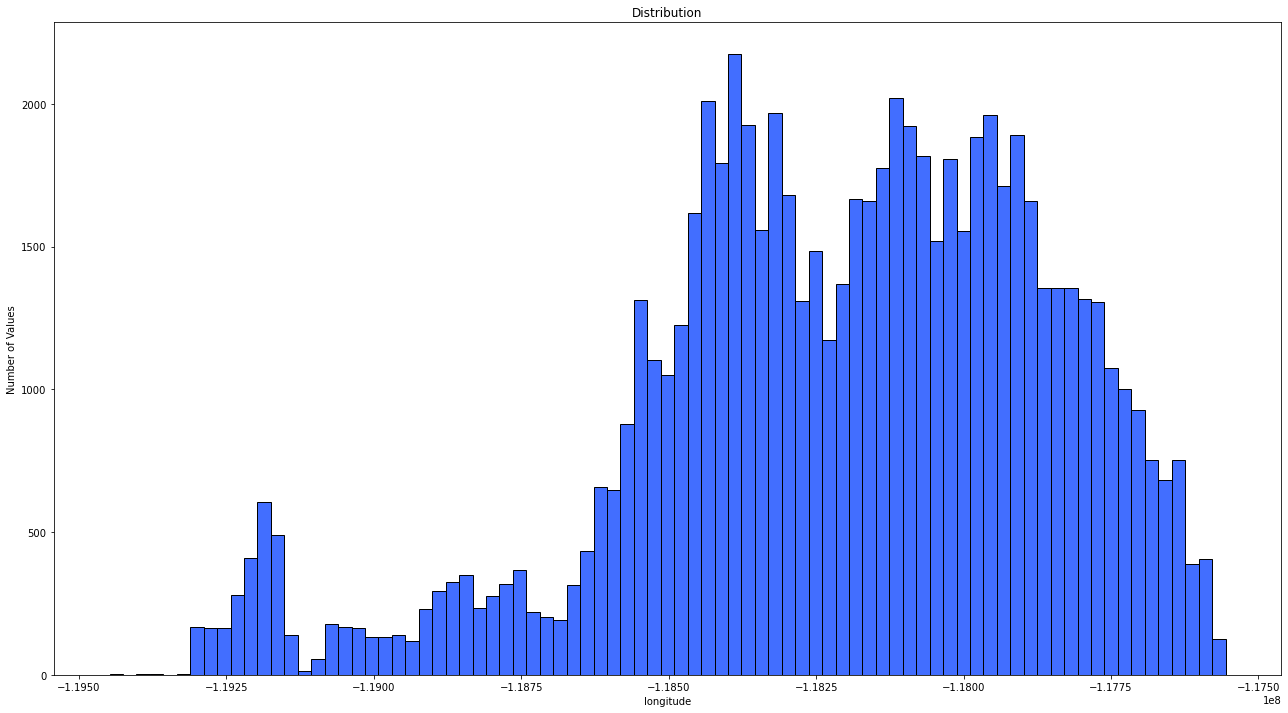

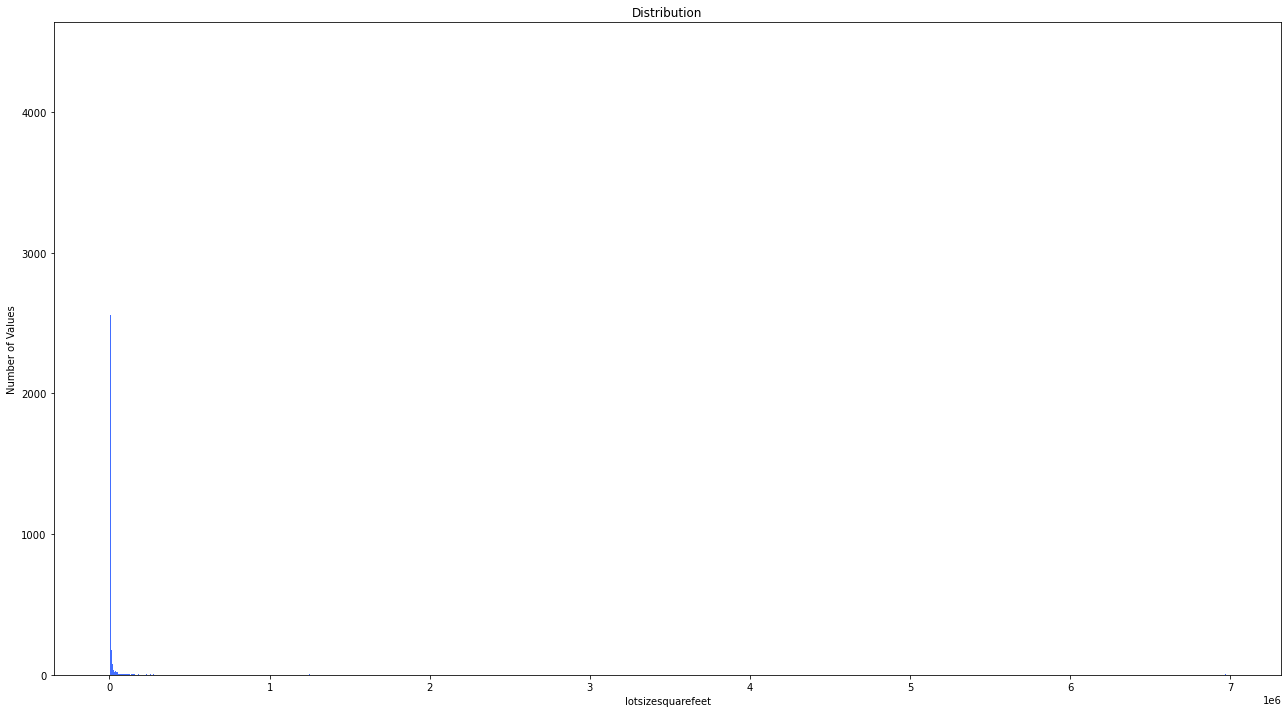

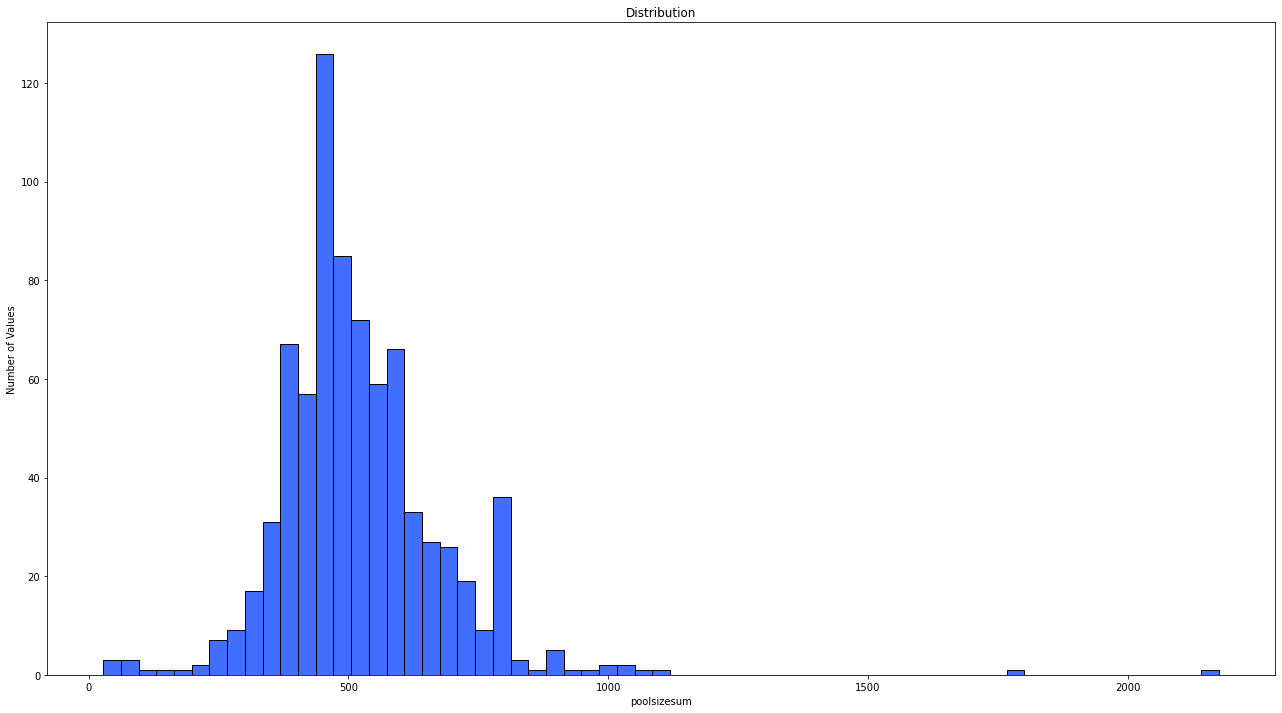

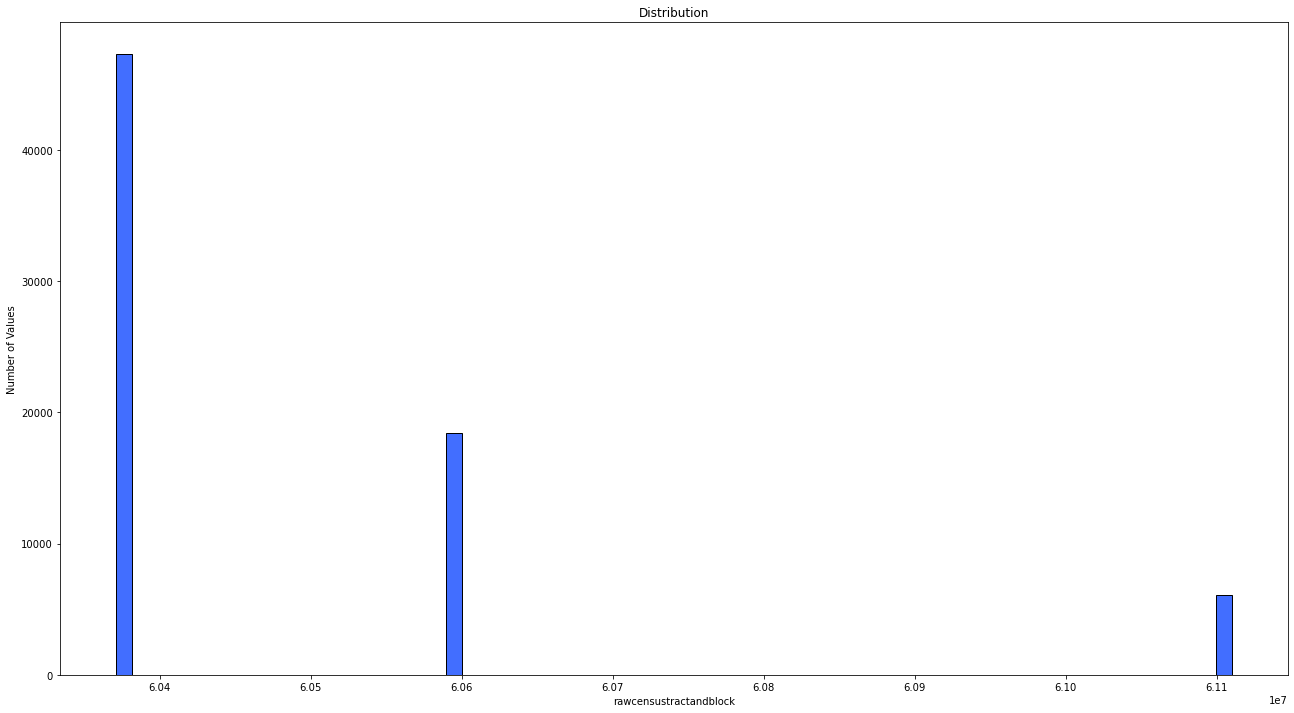

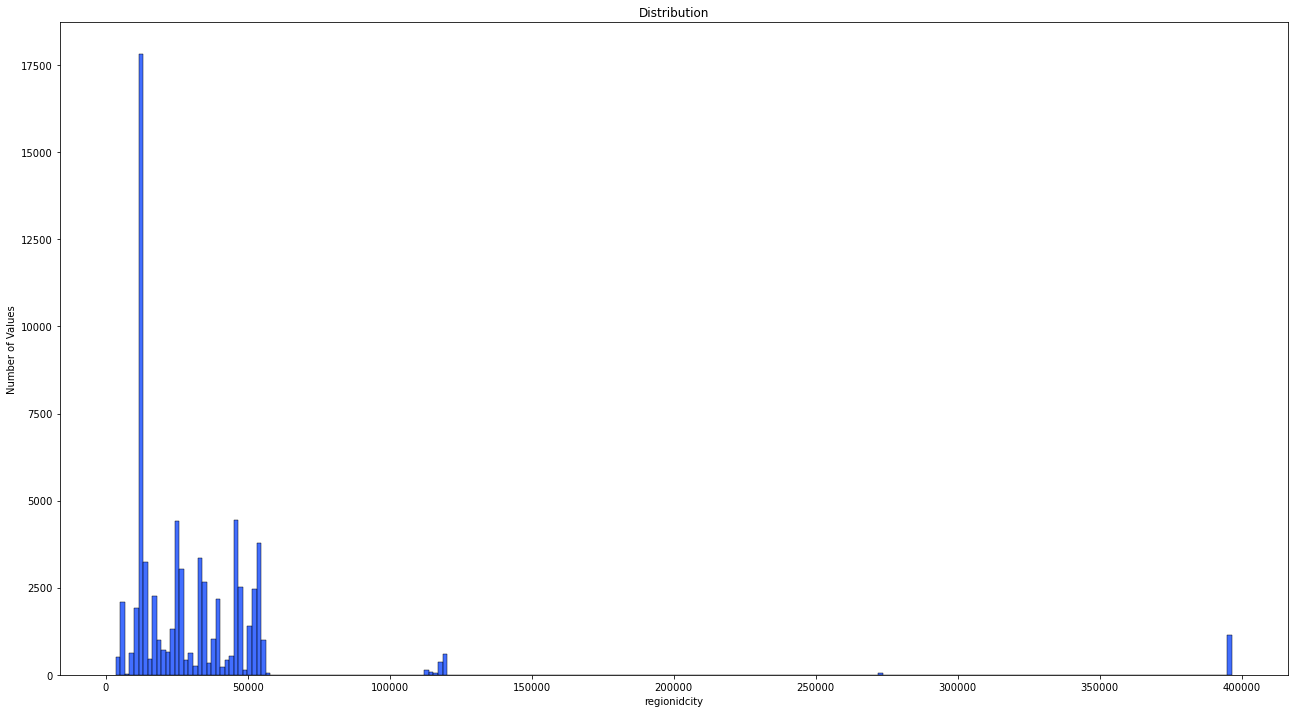

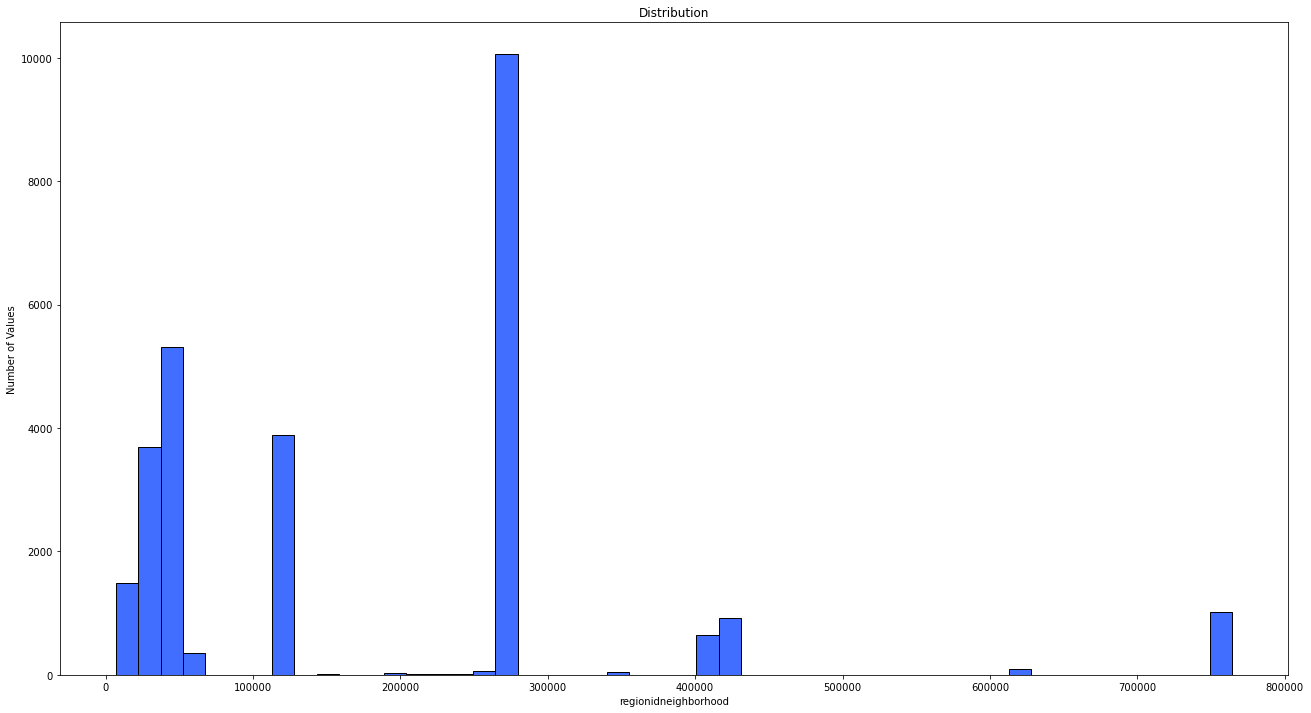

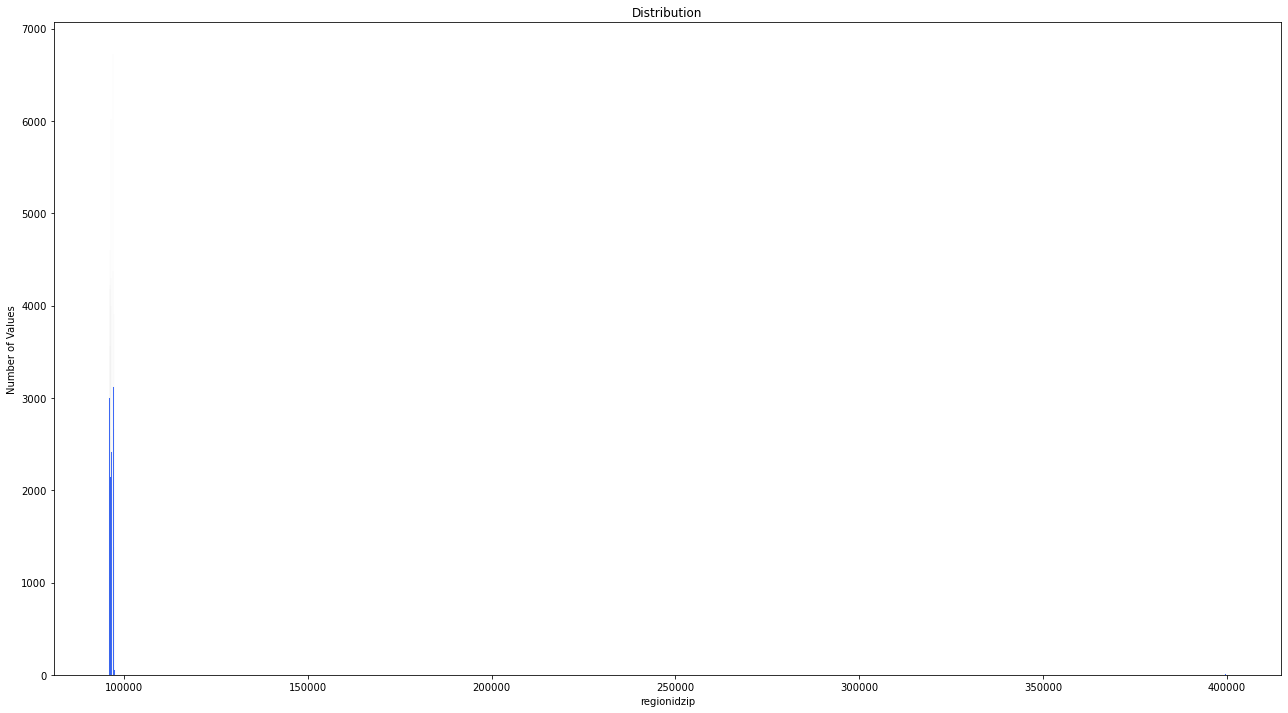

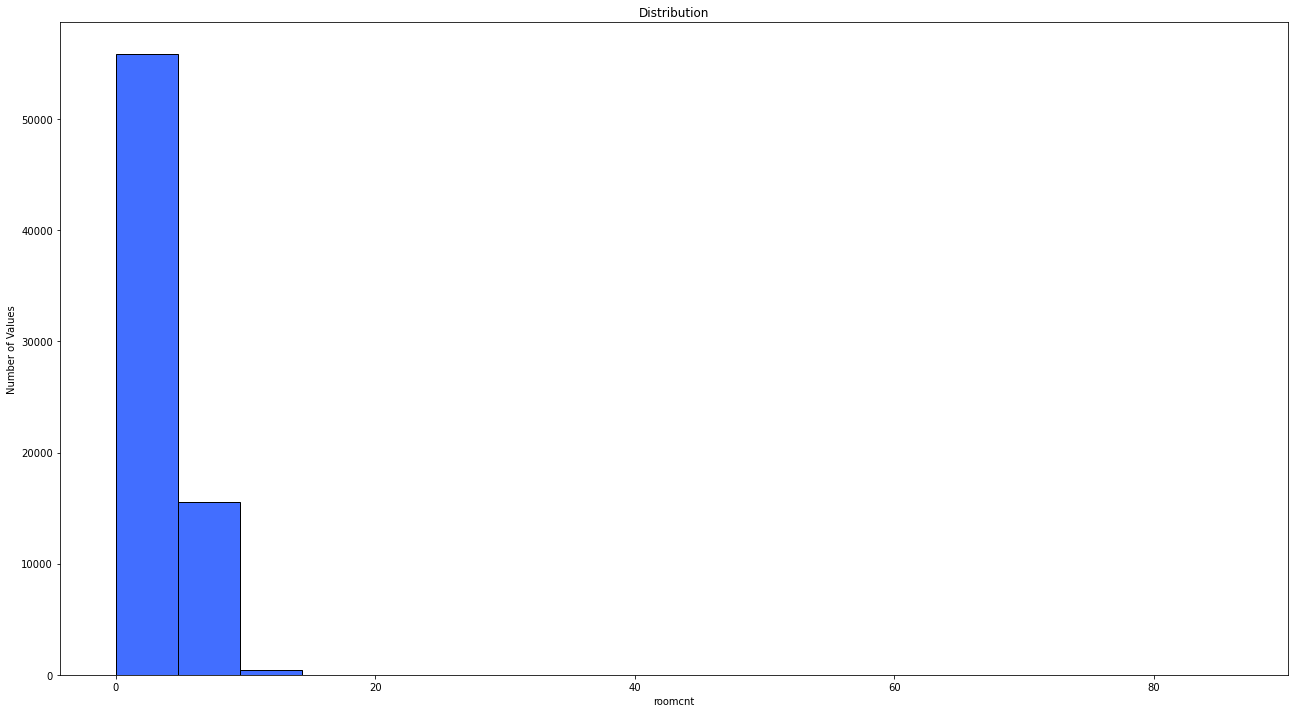

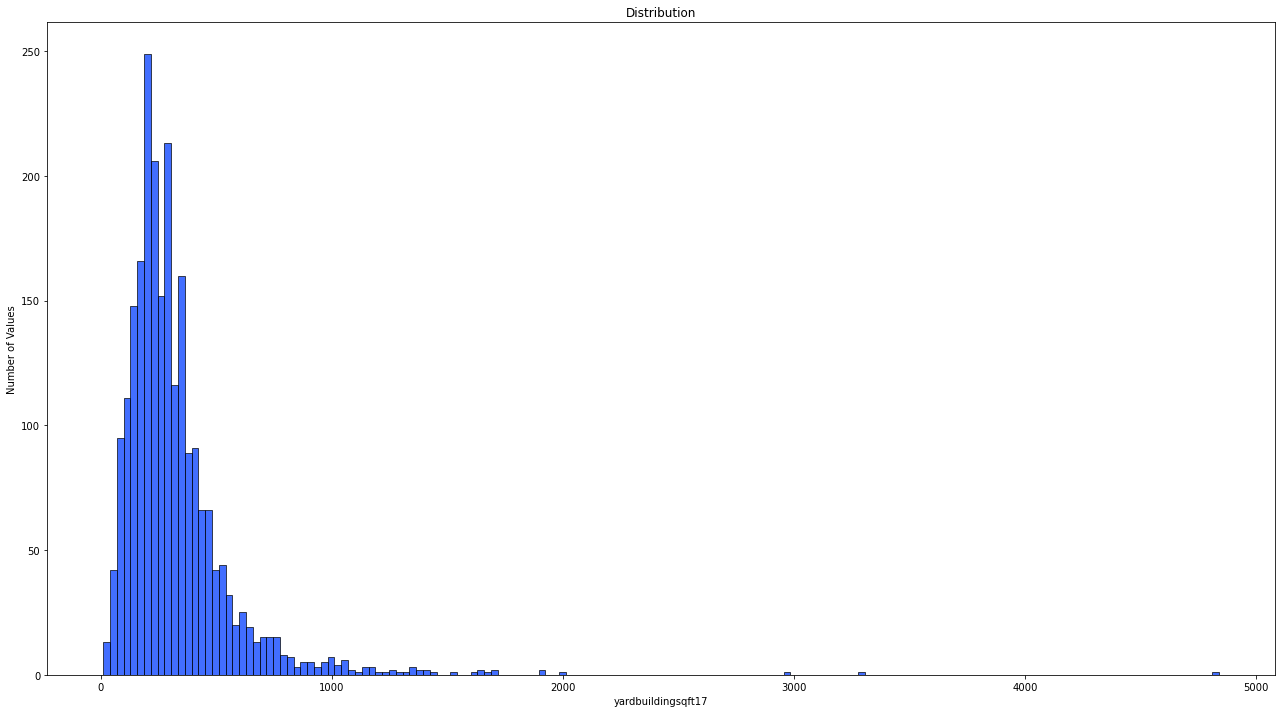

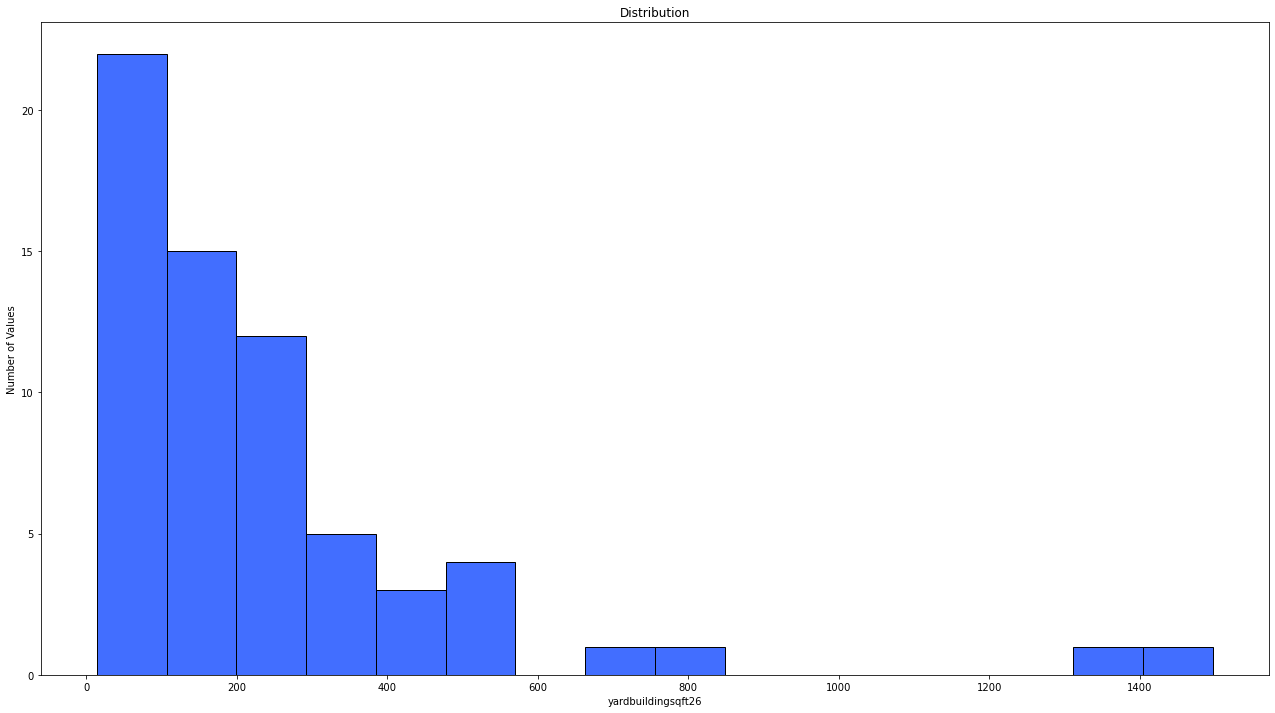

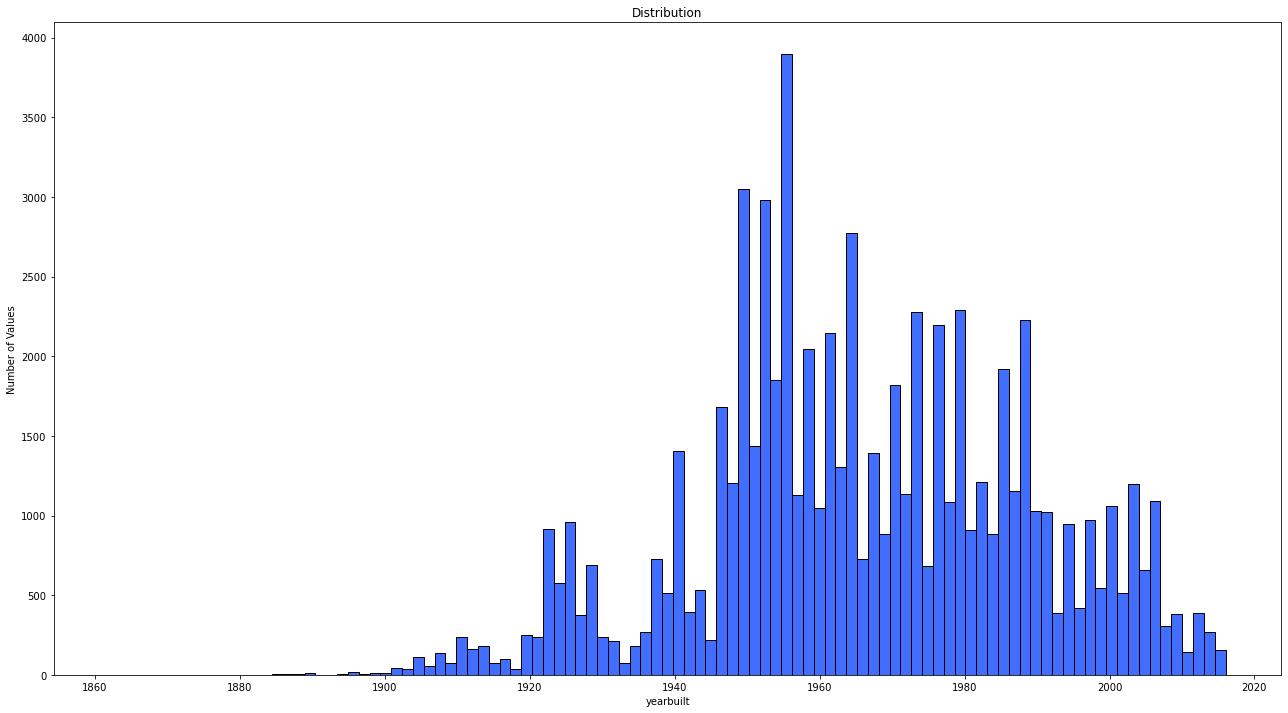

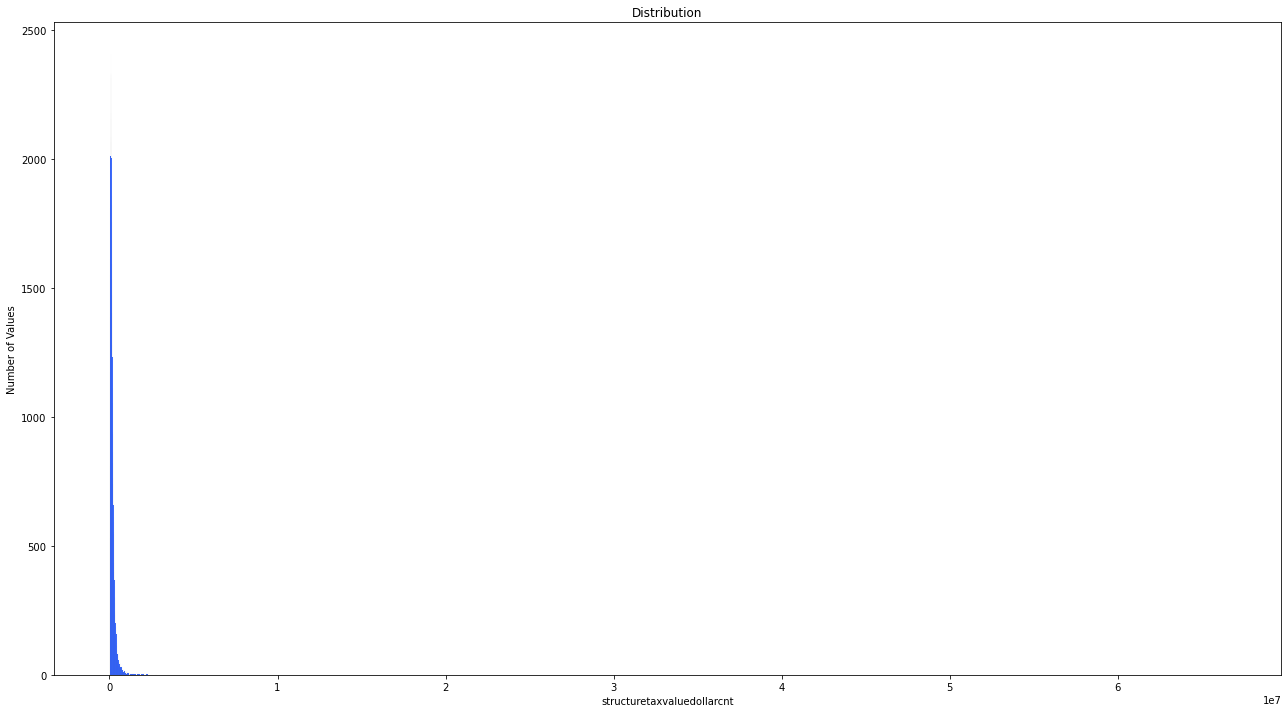

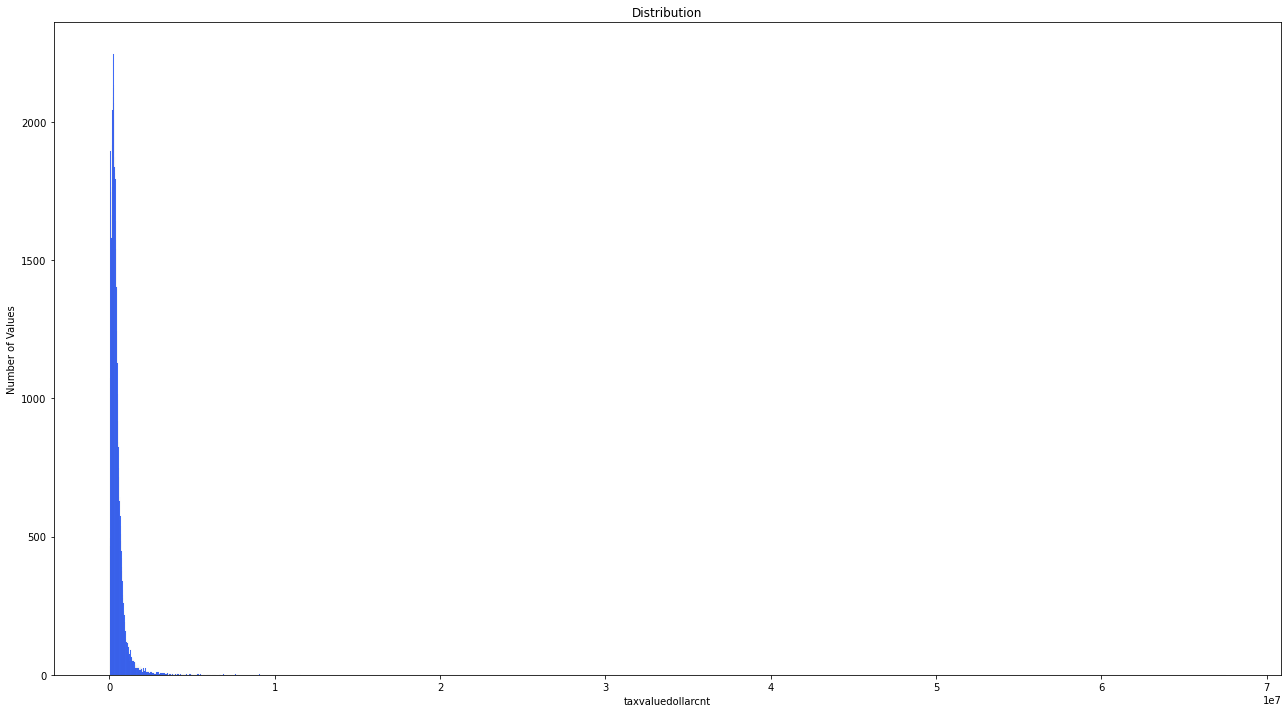

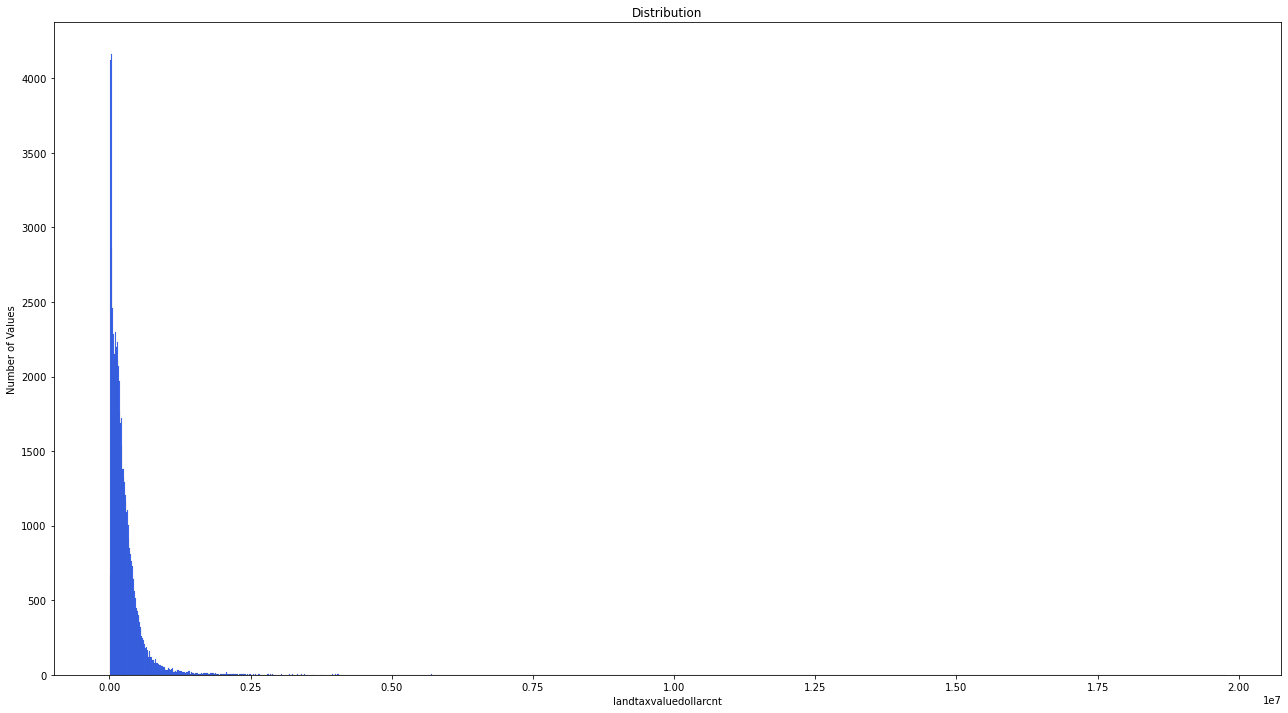

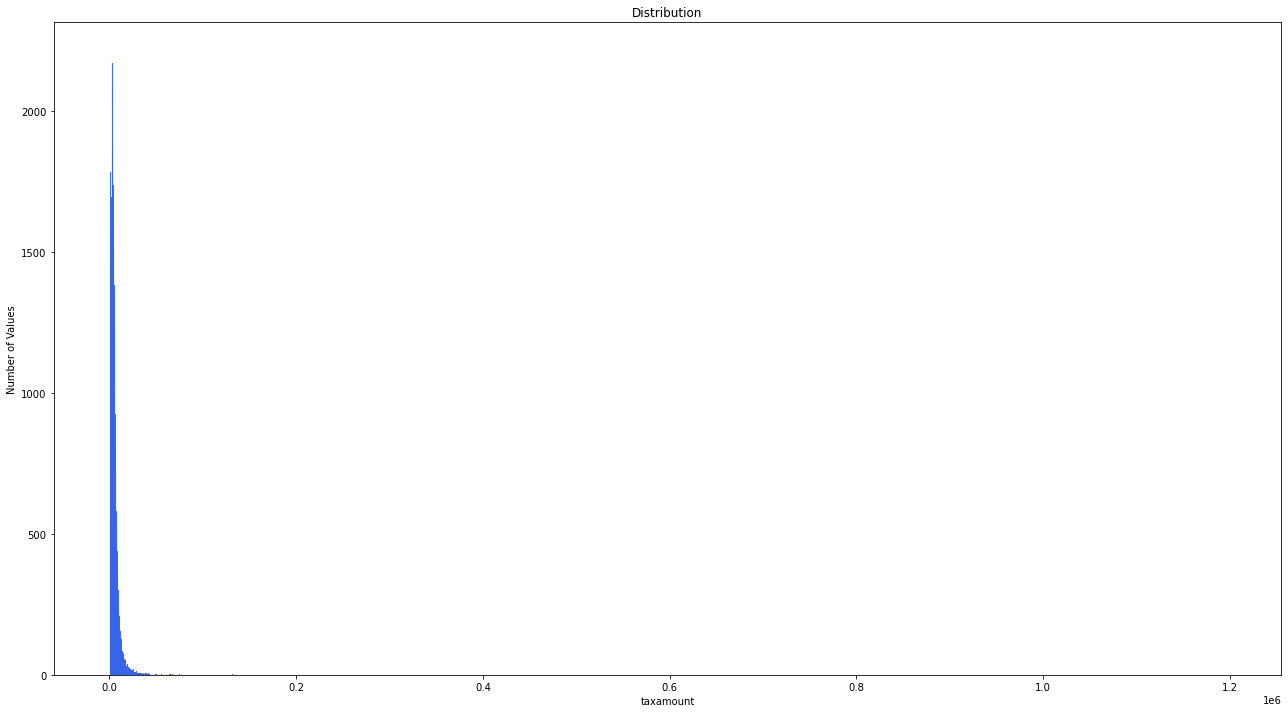

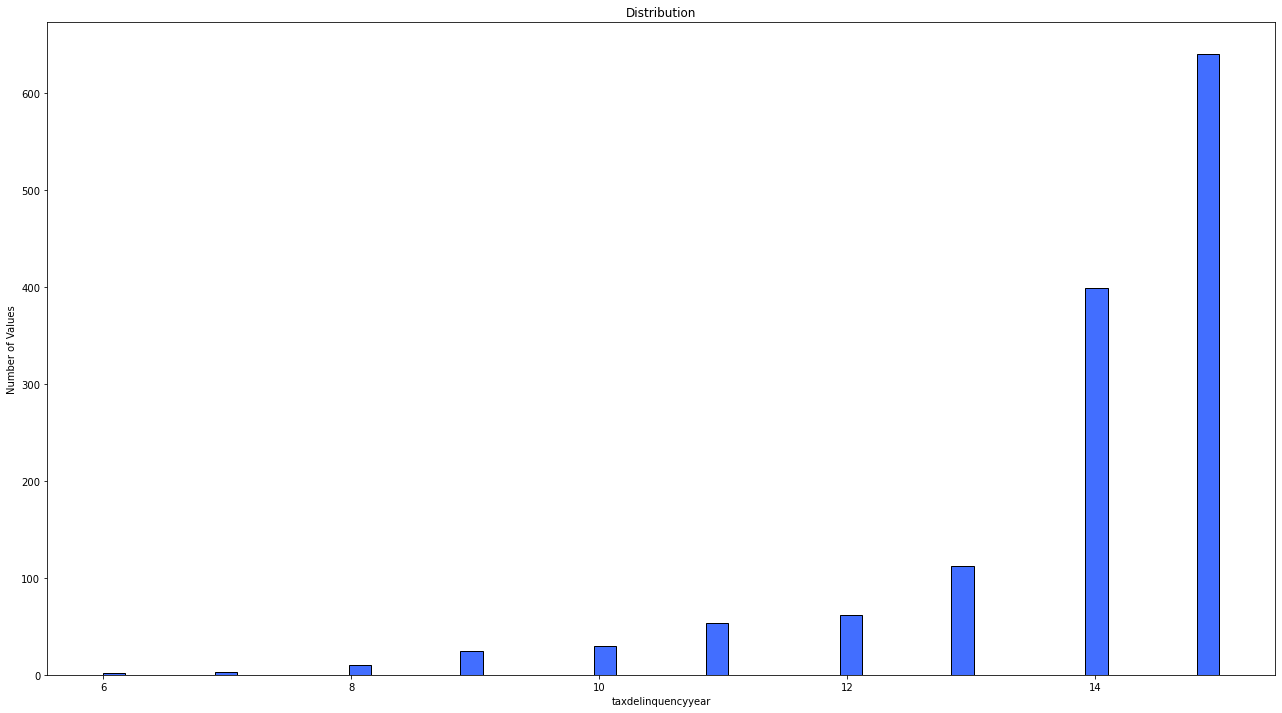

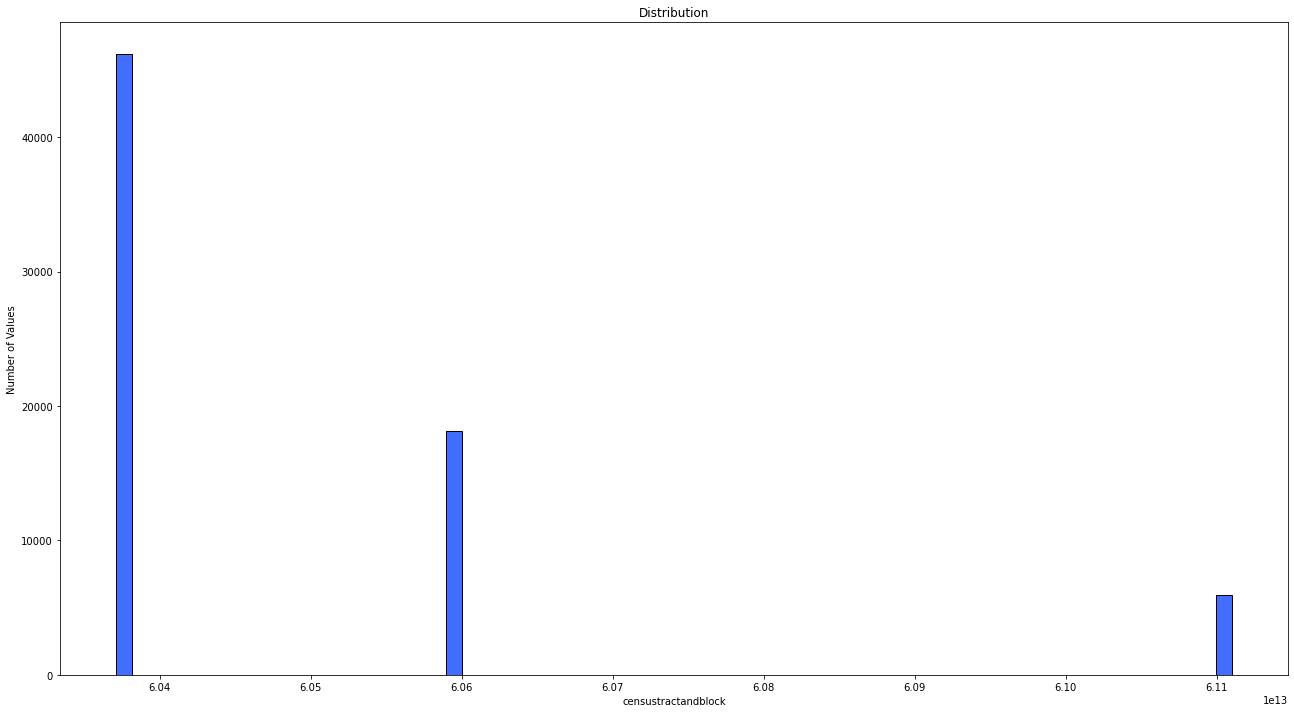

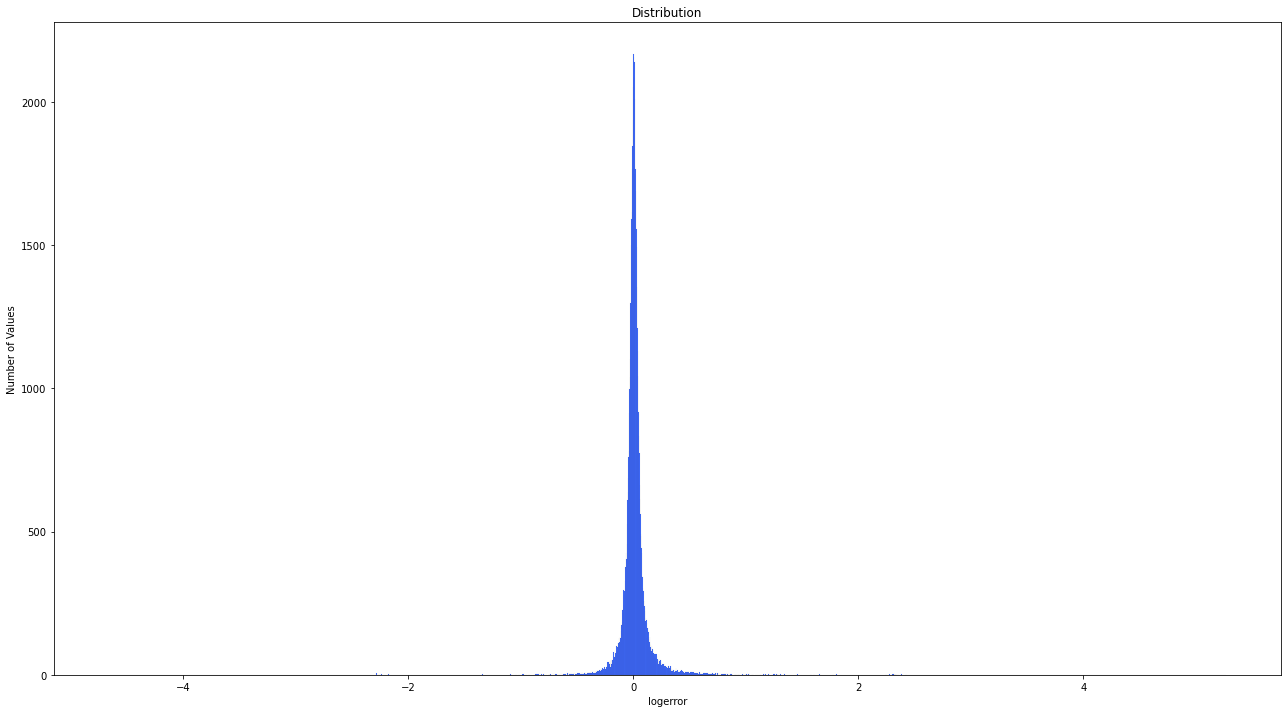

In [11]:
numeric_values_high_value_count(df)

<AxesSubplot:title={'center':'Value Counts'}, xlabel='typeconstructiondesc', ylabel='Number of Values'>

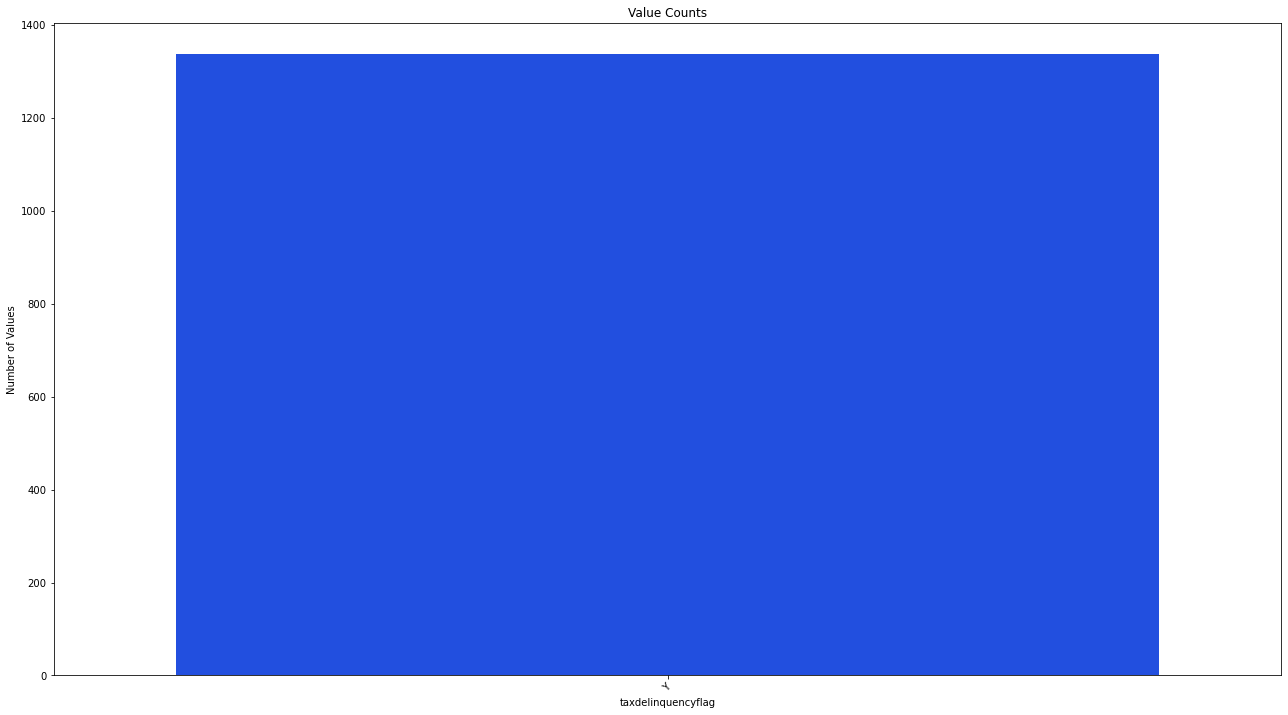

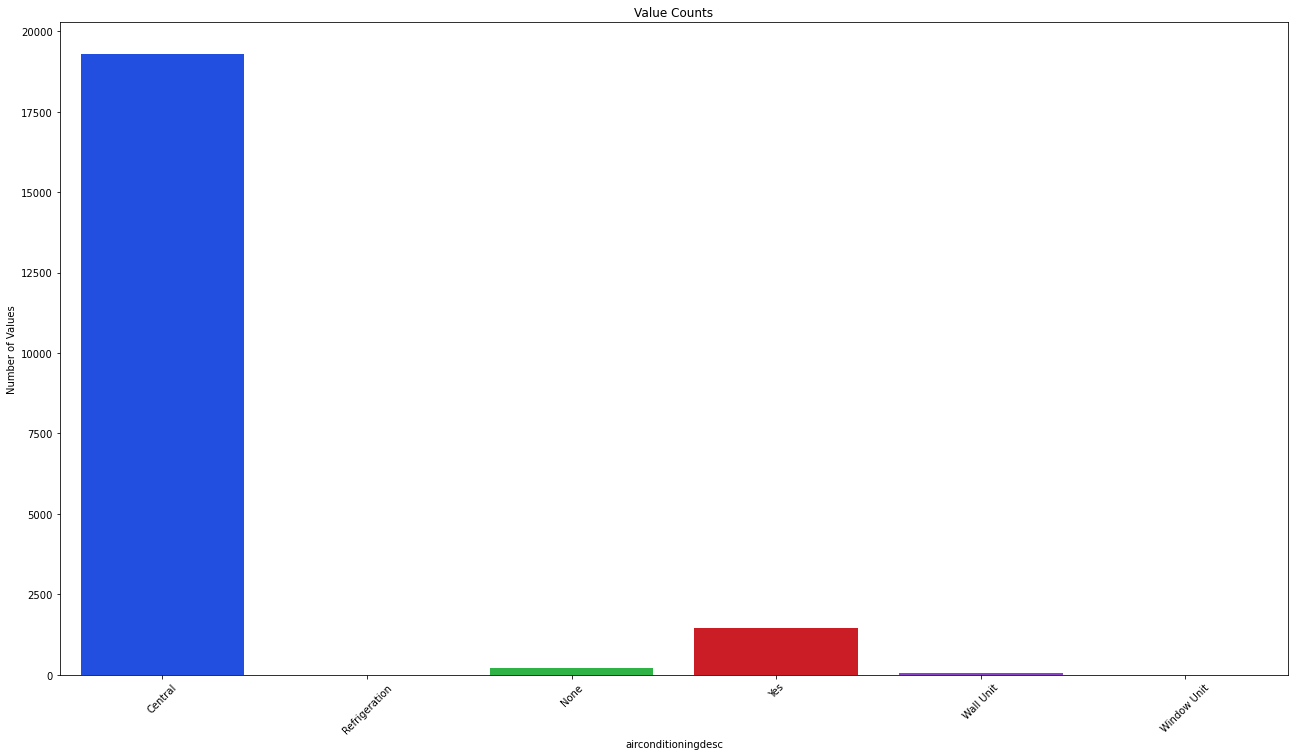

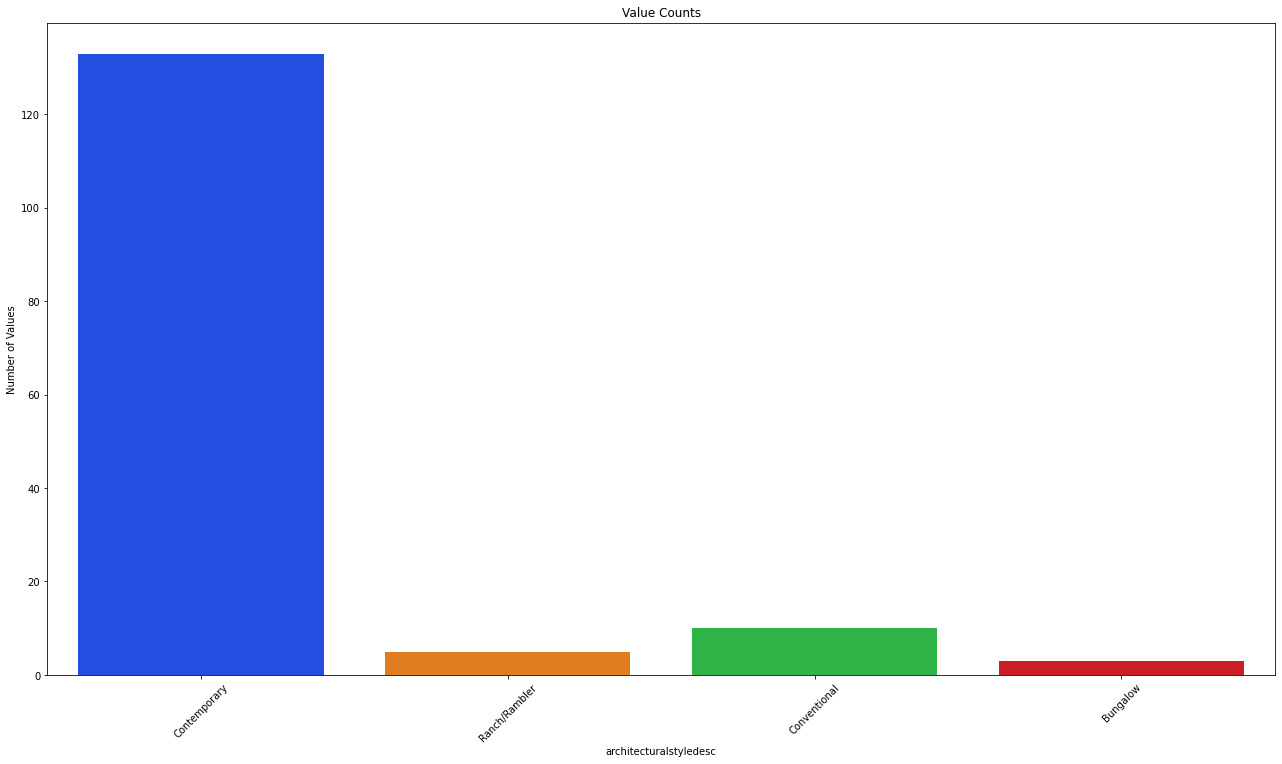

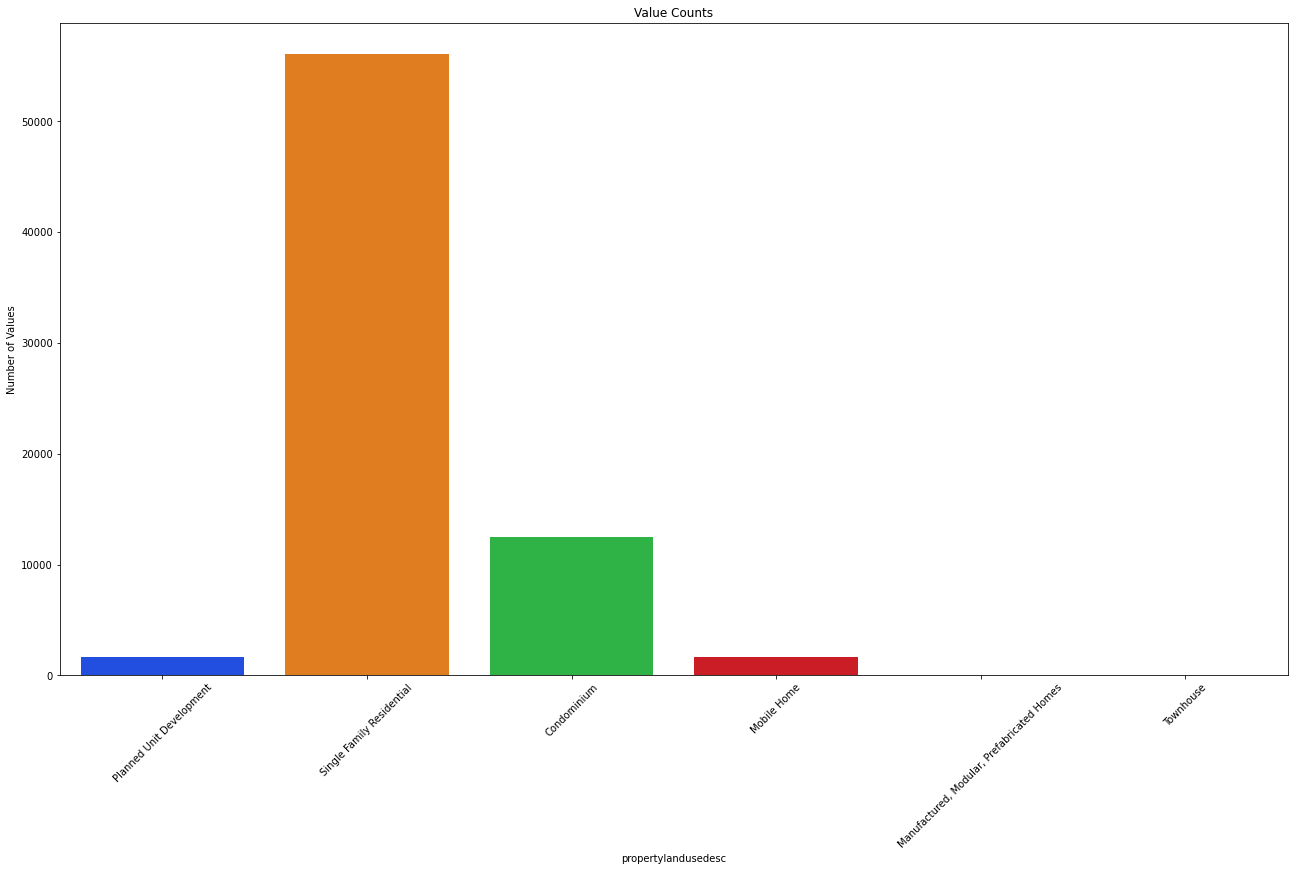

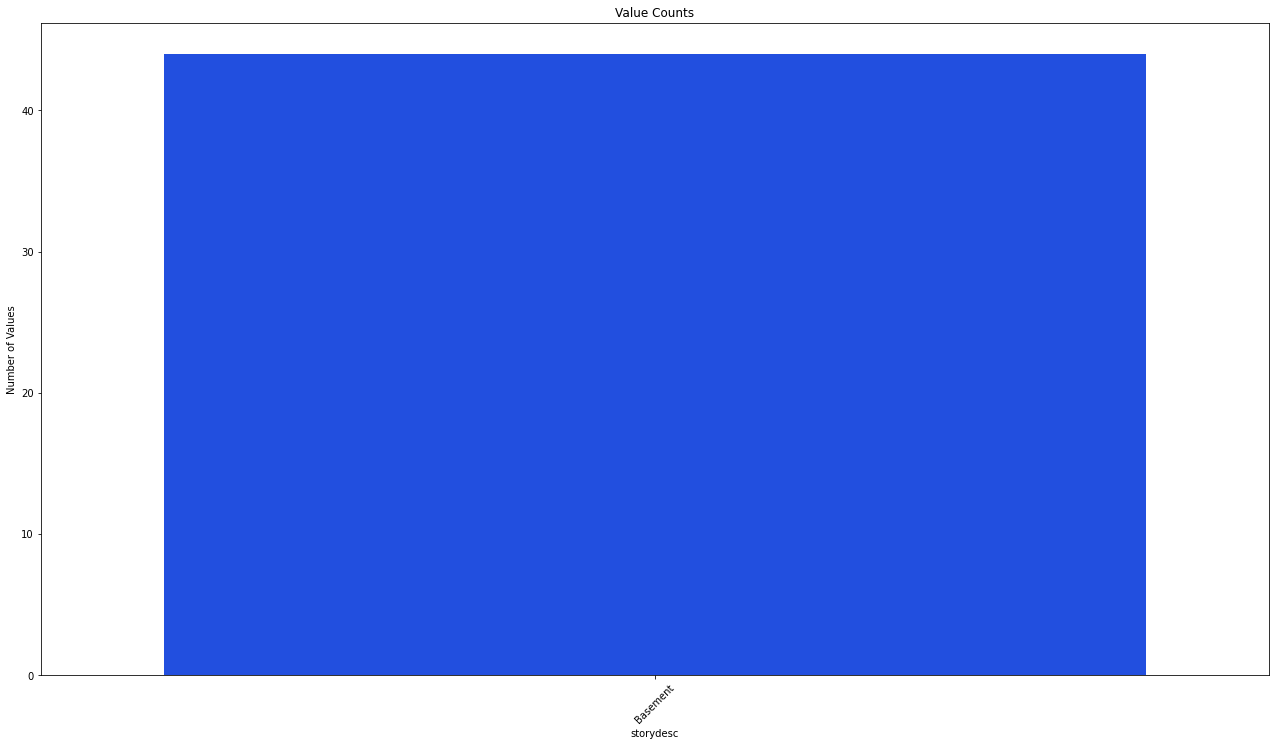

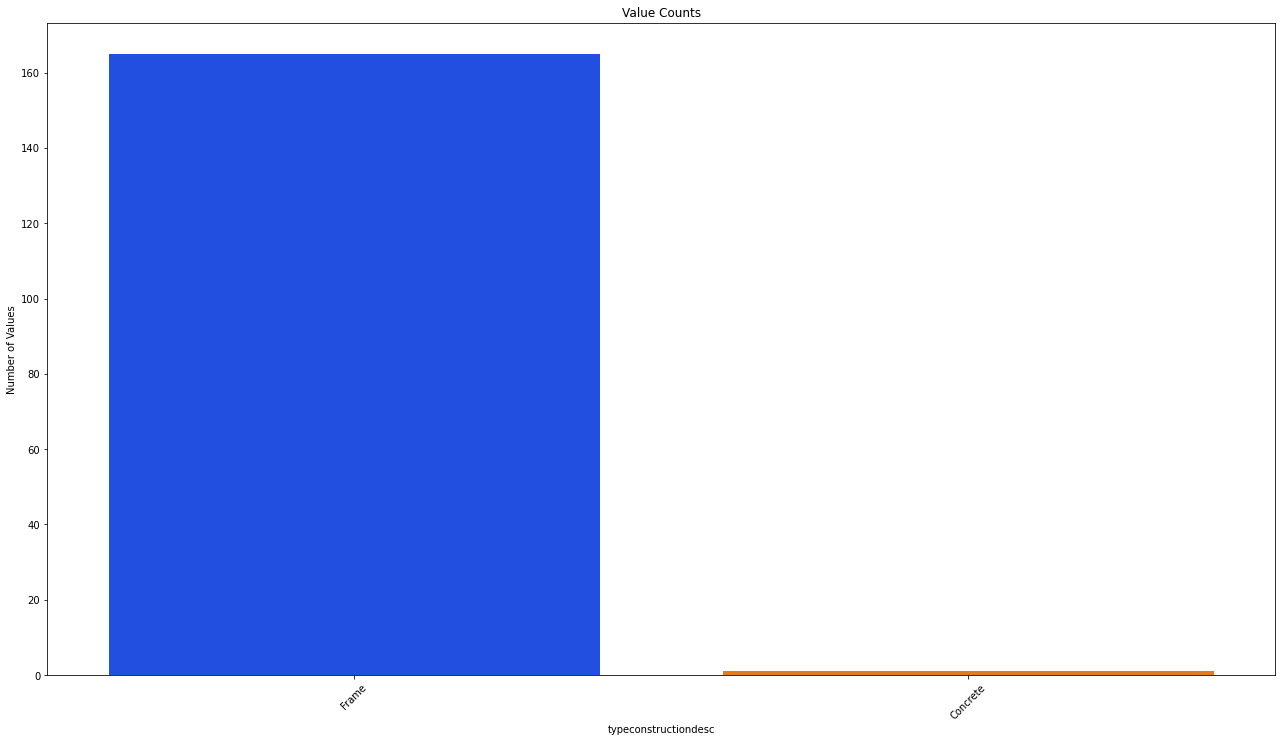

In [12]:
object_values_low_value_count(df)

In [6]:
for col in df.columns:
    if df[col].dtype == object and len(df[col].unique()) >= 10:
        print(col)

propertycountylandusecode
propertyzoningdesc
heatingorsystemdesc
transactiondate
last_trans_date


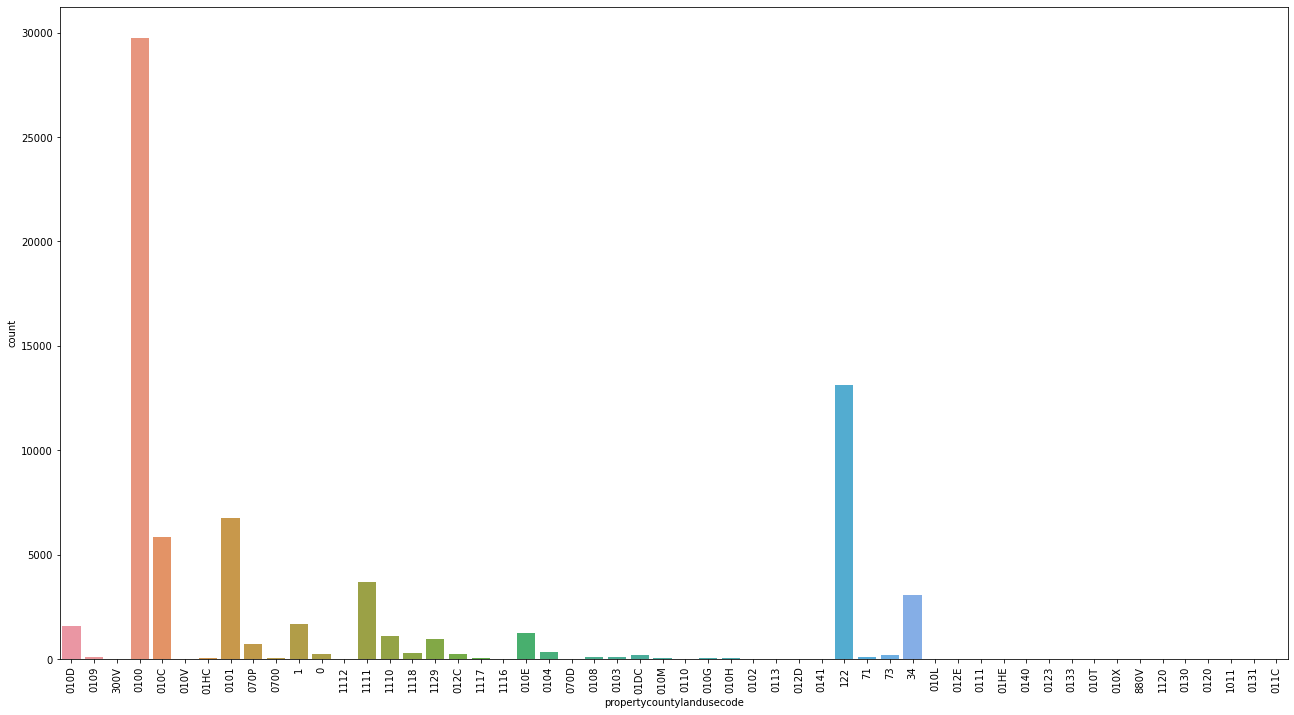

In [9]:
plt.figure(figsize=(22, 12))
landusecode = sns.countplot(x = df.propertycountylandusecode, data = df)
x_ticks = plt.xticks(rotation = 90)

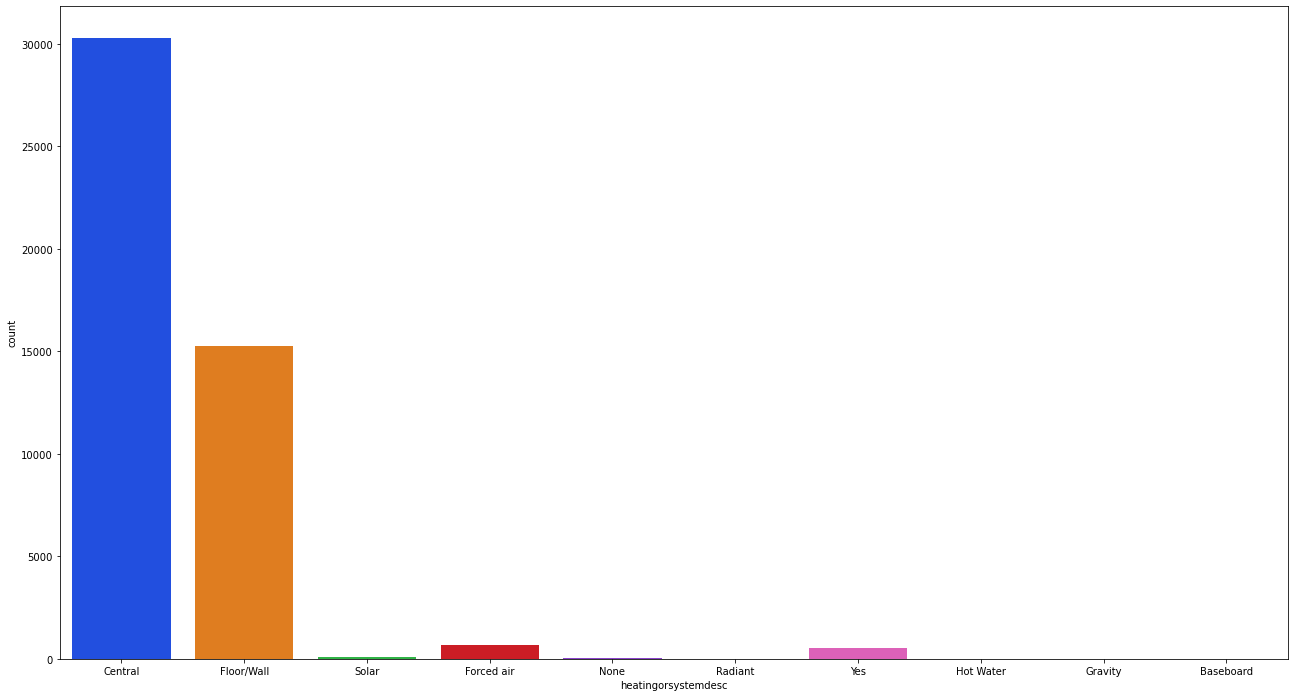

In [10]:
plt.figure(figsize=(22, 12))
heating = sns.countplot(x = df.heatingorsystemdesc, data = df)

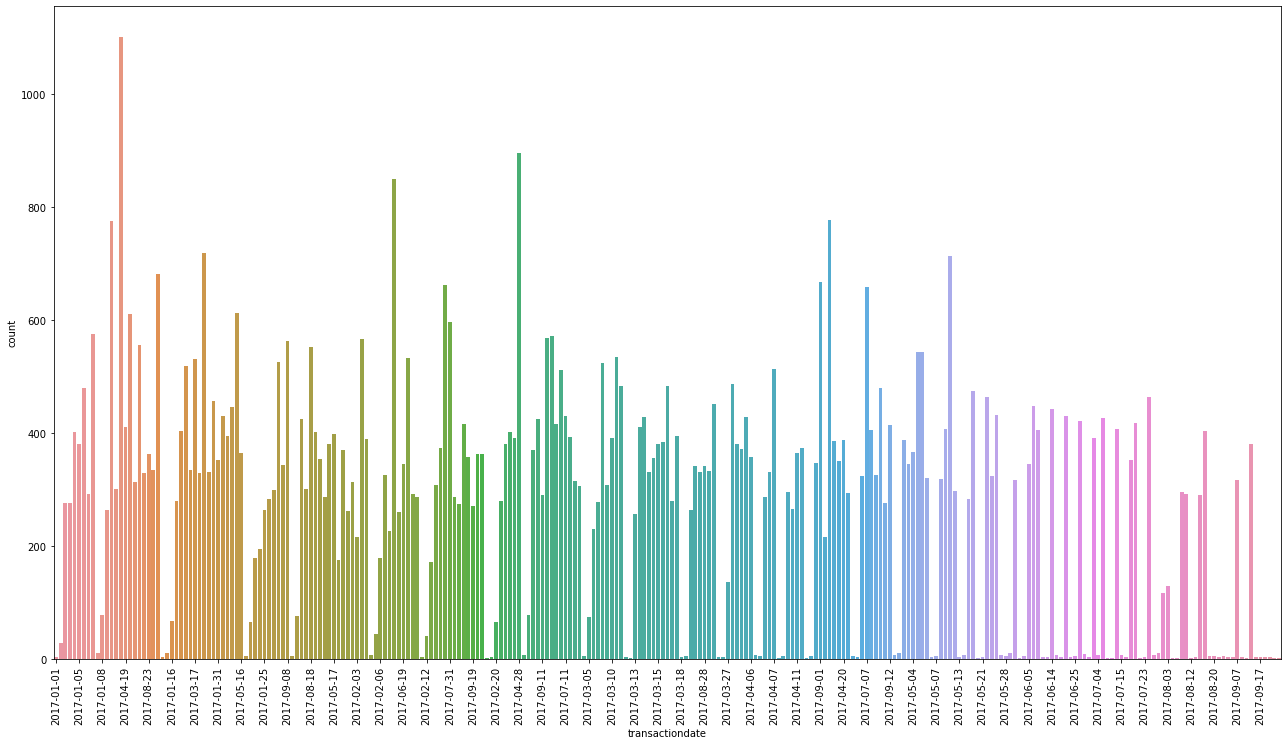

In [11]:
plt.figure(figsize=(22, 12))
transaction = sns.countplot(x = df.transactiondate, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 90)
labels = transaction.set_xticks(transaction.get_xticks()[::5])

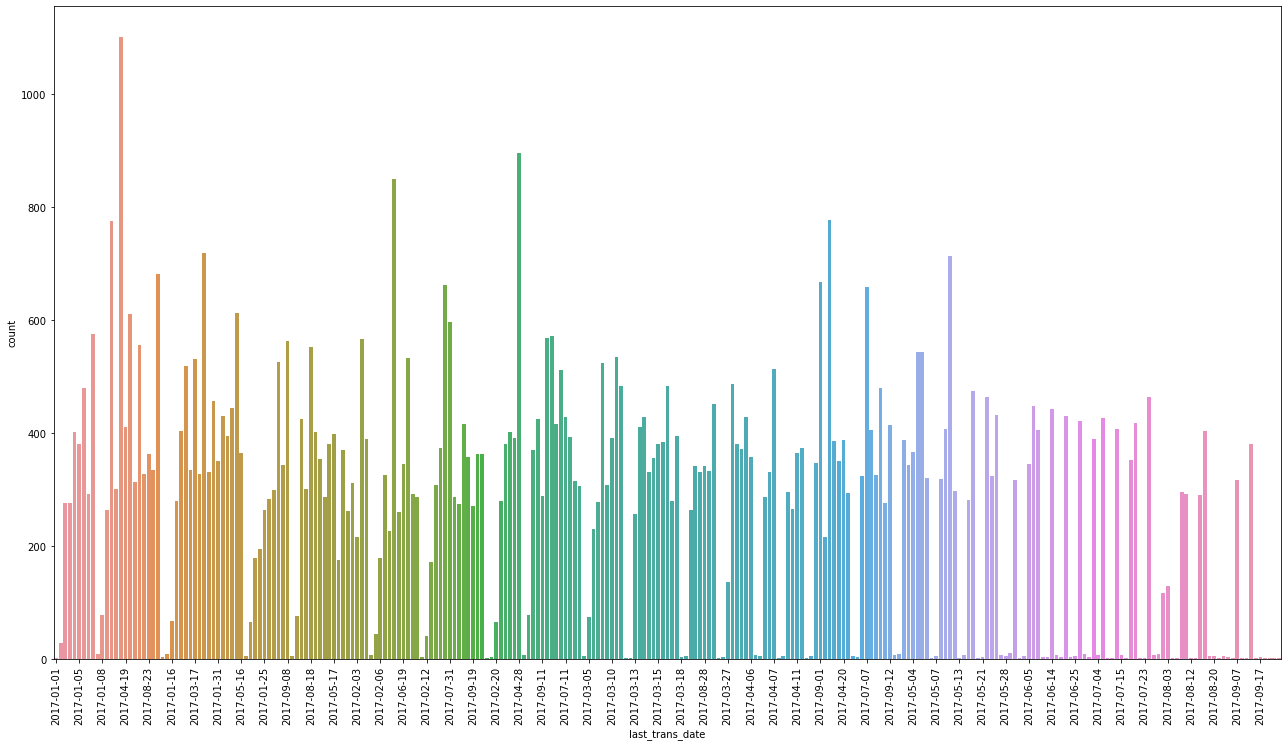

In [12]:
plt.figure(figsize=(22, 12))
last_transaction = sns.countplot(x = df.last_trans_date, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 90)
labels = last_transaction.set_xticks(last_transaction.get_xticks()[::5])

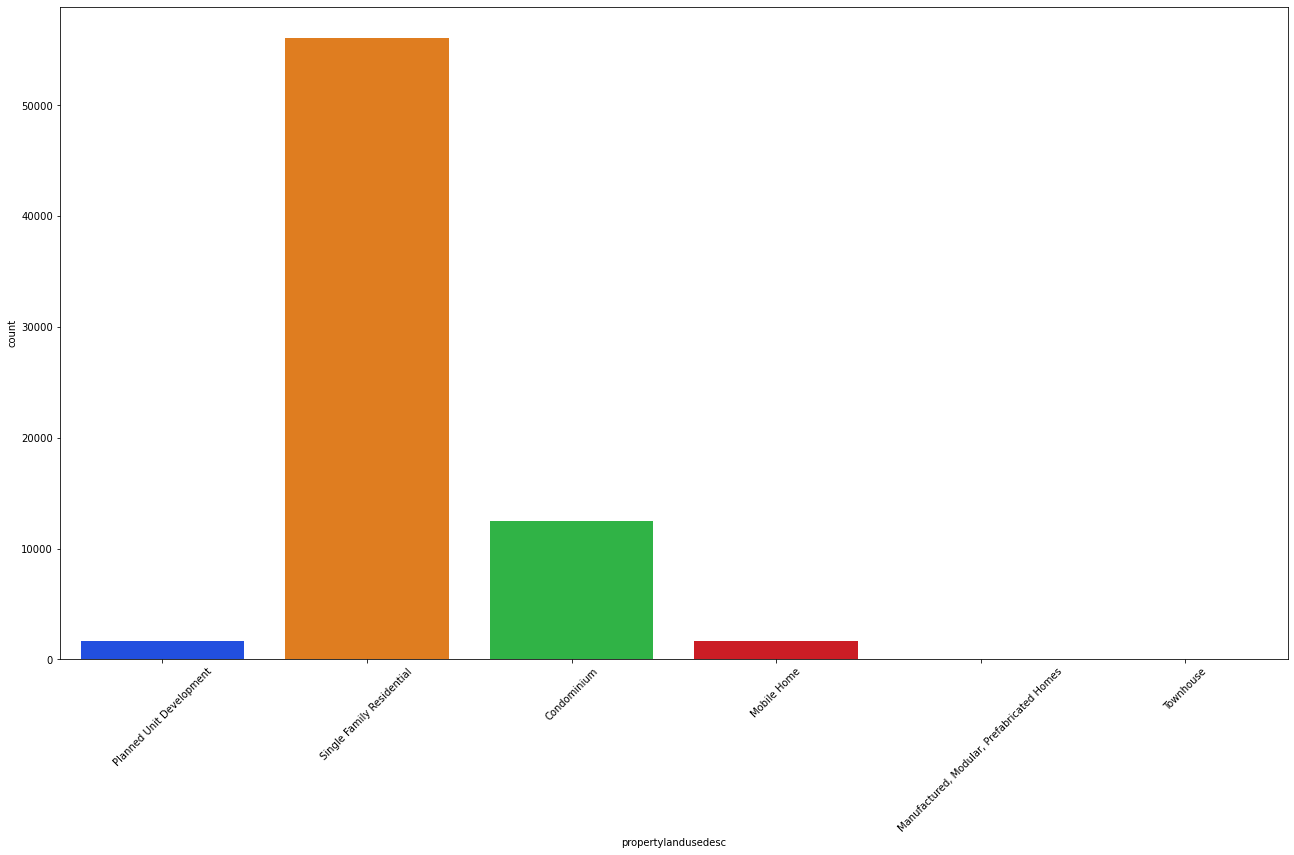

In [13]:
plt.figure(figsize=(22, 12))
land_use = sns.countplot(x = df.propertylandusedesc, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 45)

## Prepare Data

In [46]:
df = prepare_data(df)

In [6]:
df.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc
3,10,269.0,10,2.0,11070347,4.0,4.0,1.0,4.0,3095.0,...,192544.0,2016.0,53784.0,2460.72,6.037920e+13,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development
10,20,261.0,20,2.0,11324547,2.0,4.0,8.0,2.0,3633.0,...,296425.0,2016.0,74104.0,6941.39,6.037920e+13,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential
12,30,266.0,30,2.0,11524947,2.0,2.0,7.0,2.0,1090.0,...,357568.0,2016.0,124671.0,6165.36,6.037920e+13,Central,0.021853,2017-01-02,2017-01-02,Condominium
13,31,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,6.037920e+13,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential
14,33,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,6.037920e+13,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69957 entries, 3 to 71904
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         69957 non-null  int64  
 1   propertylandusetypeid         69957 non-null  float64
 2   id                            69957 non-null  int64  
 3   heatingorsystemtypeid         69957 non-null  float64
 4   parcelid                      69957 non-null  int64  
 5   bathroomcnt                   69957 non-null  float64
 6   bedroomcnt                    69957 non-null  float64
 7   buildingqualitytypeid         69957 non-null  float64
 8   calculatedbathnbr             69957 non-null  float64
 9   calculatedfinishedsquarefeet  69957 non-null  float64
 10  finishedsquarefeet12          69957 non-null  float64
 11  fips                          69957 non-null  float64
 12  fullbathcnt                   69957 non-null  float64
 13  l

In [8]:
df.describe()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
count,69957.000000,69957.000000,69957.000000,69957.000000,6.995700e+04,69957.000000,69957.000000,69957.000000,69957.000000,69957.000000,...,69957.000000,69957.000000,69957.000000,6.995700e+04,6.995700e+04,69957.000000,6.995700e+04,69957.000000,6.995700e+04,69957.000000
mean,38970.919765,262.073960,38970.919765,3.319353,1.319741e+07,2.254621,3.117143,6.288248,2.260467,1772.817745,...,1.633103,1.000743,1965.983947,1.772201e+05,4.404596e+05,2015.998971,2.633455e+05,5372.114817,6.048869e+13,0.016913
std,22371.976276,2.191955,22371.976276,2.810856,6.590401e+06,0.960319,0.997331,1.392869,0.952073,922.951517,...,2.966145,0.053996,22.729093,2.173833e+05,5.508348e+05,0.039640,3.863801e+05,6351.562847,2.071586e+11,0.170756
min,10.000000,261.000000,10.000000,1.000000,1.071174e+07,0.000000,0.000000,1.000000,1.000000,20.000000,...,0.000000,1.000000,1862.000000,5.000000e+00,9.000000e+00,2014.000000,4.000000e+00,13.490000,6.037101e+13,-4.655420
25%,19470.000000,261.000000,19470.000000,2.000000,1.153516e+07,2.000000,2.000000,6.000000,2.000000,1203.000000,...,0.000000,1.000000,1952.000000,7.984400e+04,1.915770e+05,2016.000000,7.838900e+04,2518.600000,6.037400e+13,-0.024284
50%,39097.000000,261.000000,39097.000000,2.000000,1.255946e+07,2.000000,3.000000,6.000000,2.000000,1551.000000,...,0.000000,1.000000,1964.000000,1.289440e+05,3.248790e+05,2016.000000,1.762330e+05,4044.470000,6.037574e+13,0.006736
75%,58166.000000,261.000000,58166.000000,2.000000,1.412515e+07,3.000000,4.000000,7.000000,3.000000,2091.000000,...,0.000000,1.000000,1983.000000,2.065120e+05,5.178840e+05,2016.000000,3.268410e+05,6236.870000,6.059042e+13,0.039340
max,77613.000000,275.000000,77613.000000,24.000000,1.696019e+08,20.000000,25.000000,12.000000,20.000000,26345.000000,...,86.000000,13.000000,2016.000000,1.087622e+07,3.016684e+07,2016.000000,1.976448e+07,342940.380000,6.111009e+13,5.262999


### Remove outliers

In [47]:
df_no_outliers = data_no_outliers(df)

In [6]:
df.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc
3,10,269.0,10,2.0,11070347,4.0,4.0,1.0,4.0,3095.0,...,192544.0,2016.0,53784.0,2460.72,6.037920e+13,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development
10,20,261.0,20,2.0,11324547,2.0,4.0,8.0,2.0,3633.0,...,296425.0,2016.0,74104.0,6941.39,6.037920e+13,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential
13,31,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,6.037920e+13,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential
14,33,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,6.037920e+13,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential
18,46,266.0,46,2.0,11780147,1.0,0.0,6.0,1.0,700.0,...,387288.0,2016.0,115979.0,4920.64,6.037920e+13,None,0.054203,2017-01-02,2017-01-02,Condominium


In [50]:
df_no_outliers.shape

(58997, 36)

### Train, validate, test split

In [48]:
train, validate, test = split_data(df)

In [66]:
train2, validate2, test2 = split_data(df_no_outliers)

## Exploration

### Feature Engineering

We will use feature engineering to determine which continuous variables are most predictive of logerror.

In [140]:
continuous = ['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fullbathcnt',
 'lotsizesquarefeet',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

In [141]:
X_train = train[continuous]
y_train = train['logerror']
X_train2 = train2[continuous]
y_train2 = train2['logerror']

In [142]:
# Create model
kbest_3 = SelectKBest(f_regression, k=3)
#Fit the model
kbest_3.fit(X_train, y_train)
X_train.columns[kbest_3.get_support()]

Index(['calculatedbathnbr', 'fullbathcnt', 'roomcnt'], dtype='object')

In [143]:
rfe_3 = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe_3.fit(X_train, y_train)
X_train.columns[rfe_3.get_support()]

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr'], dtype='object')

In [144]:
continuous.remove("calculatedbathnbr")

In [145]:
continuous.remove("fullbathcnt")

In [146]:
X_train = train[continuous]
X_train2 = train2[continuous]

In [147]:
# Create model
kbest_3 = SelectKBest(f_regression, k=3)
#Fit the model
kbest_3.fit(X_train, y_train)
X_train.columns[kbest_3.get_support()]

Index(['bathroomcnt', 'bedroomcnt', 'roomcnt'], dtype='object')

In [149]:
# Create model
kbest_3 = SelectKBest(f_regression, k=3)
#Fit the model
kbest_3.fit(X_train2, y_train2)
X_train2.columns[kbest_3.get_support()]

Index(['bedroomcnt', 'taxvaluedollarcnt', 'taxamount'], dtype='object')

In [150]:
rfe_3 = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe_3.fit(X_train, y_train)
X_train.columns[rfe_3.get_support()]

Index(['bathroomcnt', 'bedroomcnt', 'roomcnt'], dtype='object')

In [151]:
rfe_3 = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe_3.fit(X_train2, y_train2)
X_train.columns[rfe_3.get_support()]

Index(['bathroomcnt', 'bedroomcnt', 'yearbuilt'], dtype='object')

## Does the logerror of a property differ by county?

### Value Counts

In [83]:
train.fips.value_counts()

6037.0    26042
6059.0     9903
6111.0     3230
Name: fips, dtype: int64

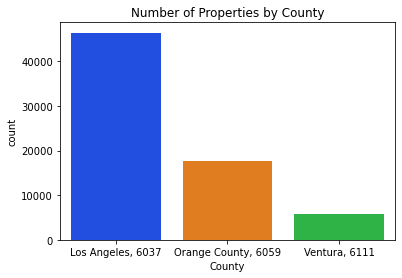

In [84]:
value_counts_by_county = sns.countplot(x = 'fips', data = df)
title = value_counts_by_county.set(title = "Number of Properties by County", xlabel = "County")
x_ticks = value_counts_by_county.set_xticklabels(['Los Angeles, 6037', 'Orange County, 6059', 'Ventura, 6111'])

### Average Logerror by County

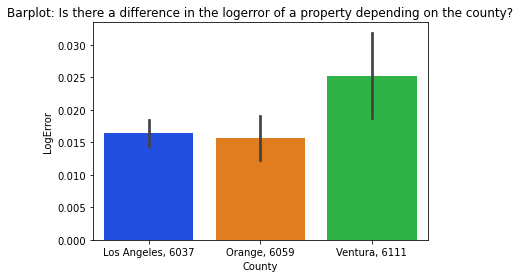

In [85]:
county_log_error = sns.barplot(data = train, y = 'logerror', x = 'fips')
title = plt.title("Barplot: Is there a difference in the logerror of a property depending on the county?")
xlabel = plt.xlabel("County")
ylabel = plt.ylabel("LogError")
xticks = county_log_error.set_xticklabels(["Los Angeles, 6037", "Orange, 6059", "Ventura, 6111"])

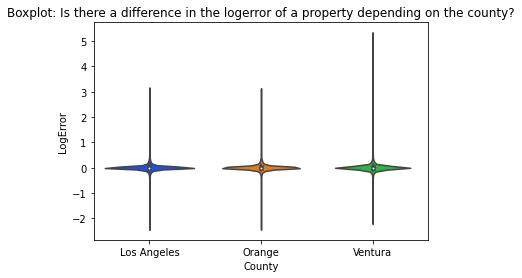

In [86]:
county_log_error = sns.violinplot(data = train, y = 'logerror', x = 'fips')
title = plt.title("Boxplot: Is there a difference in the logerror of a property depending on the county?")
xlabel = plt.xlabel("County")
ylabel = plt.ylabel("LogError")
xticks = county_log_error.set_xticklabels(["Los Angeles", "Orange", "Ventura"])

### Statistical Testing

For the following statistical tests, we set our alpha value to $0.05$. 

#### Leven's Test

$H_0:$ There is no difference in log error variance between Los Angeles and Orange County. 

$H_a:$ There is a significant difference in log error between Los Angeles and Orange County.

In [87]:
stats.levene(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6059.0').logerror,
)

LeveneResult(statistic=0.2922519988069781, pvalue=0.5887843475165777)

In [88]:
stats.levene(
    train2.query('fips == 6037.0').logerror,
    train2.query('fips == 6059.0').logerror,
)

LeveneResult(statistic=0.44395331555594153, pvalue=0.5052256164396443)

**Conclusion** 

Because or pvalue is high, we fail to reject the null hypothesis.

$H_0:$ There is no difference in log error variance between Ventura and Orange County. 

$H_a:$ There is a significant difference in log error between Ventura and Orange County.

In [26]:
stats.levene(
    train.query('fips == 6059.0').logerror,
    train.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=1.6939265199617572, pvalue=0.19310858118009097)

In [89]:
stats.levene(
    train2.query('fips == 6059.0').logerror,
    train2.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=1.6939265199617572, pvalue=0.19310858118009097)

**Conclusion**

Because our pvalue is high, we fail to reject the null hypothesis.

$H_0:$ There is no difference in log error variance between Ventura and Los Angeles. 

$H_a:$ There is a significant difference in log error between Ventura and Los Angeles.

In [28]:
stats.levene(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=1.0128293040183882, pvalue=0.31423624596283434)

In [90]:
stats.levene(
    train2.query('fips == 6059.0').logerror,
    train2.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=1.6939265199617572, pvalue=0.19310858118009097)

**Conclusion**

Because our pvalue is high, we fail to reject the null hypothesis.

#### T test

$H_0$: There is no difference in log error for Orange and Ventura County.

$H_a$: There is a significant different in log error for Orange and Ventura County.

In [92]:
stats.ttest_ind(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6059.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=0.3744968199332362, pvalue=0.7080369314010183)

In [91]:
stats.ttest_ind(
    train2.query('fips == 6037.0').logerror,
    train2.query('fips == 6059.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=0.7186035337629928, pvalue=0.4723908195769544)

$H_0$: There is no difference in log error for Los Angeles and Ventura County.

$H_a$: There is a significant different in log error for Los Angeles and Ventura County.

In [93]:
stats.ttest_ind(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6111.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=-2.7295762208762, pvalue=0.006345368610063448)

In [95]:
stats.ttest_ind(
    train2.query('fips == 6037.0').logerror,
    train2.query('fips == 6111.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=-1.2688776133139703, pvalue=0.2044971712000932)

$H_0$: There is no difference in log error for Orange and Los Angeles County.

$H_a$: There is a significant different in log error for Orange and Los Angeles County.

In [96]:
stats.ttest_ind(
    train.query('fips == 6111.0').logerror,
    train.query('fips == 6059.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=2.658837258745088, pvalue=0.007850591636554086)

In [97]:
stats.ttest_ind(
    train2.query('fips == 6111.0').logerror,
    train2.query('fips == 6059.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=1.5777637205426889, pvalue=0.11464564863902561)

Without outliers, there is no significant different in log error between the counties.

With outliers, there is a significant difference in log error for properties in Los Angeles county and properties not in Los Angeles County.

#### Map

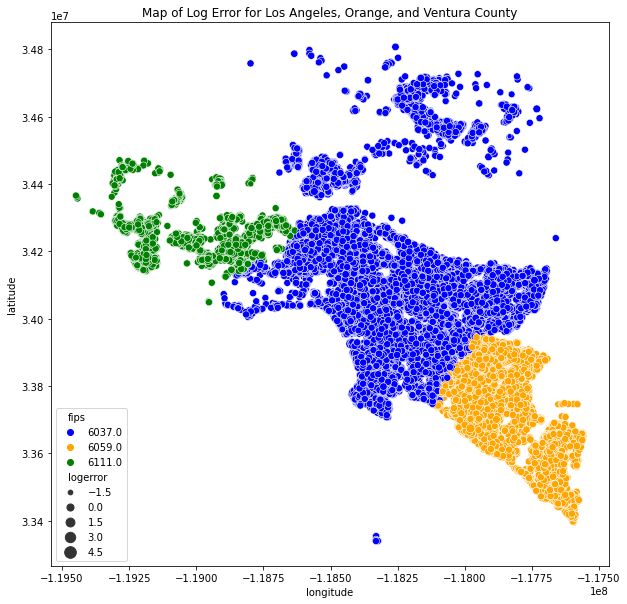

In [98]:
plt.figure(figsize=(10, 10))
county_map = sns.scatterplot(data = train, x = 'longitude', y='latitude', hue = 'fips', palette = ['blue', 'orange', 'green'], size = 'logerror', sizes=(5, 150))
tilte = county_map.set(Title = "Map of Log Error for Los Angeles, Orange, and Ventura County")

### Does the Log Error Differ Significantly by Bathroom Count?

#### Value Counts

In [99]:
train.bathroomcnt.value_counts().sort_index()

0.0       112
1.0      7053
1.5       616
2.0     16710
2.5      2983
3.0      8693
3.5       485
4.0      1372
4.5       271
5.0       487
5.5        96
6.0       161
6.5        15
7.0        65
7.5         6
8.0        21
8.5         3
9.0        17
10.0        6
11.0        1
13.0        1
19.5        1
Name: bathroomcnt, dtype: int64

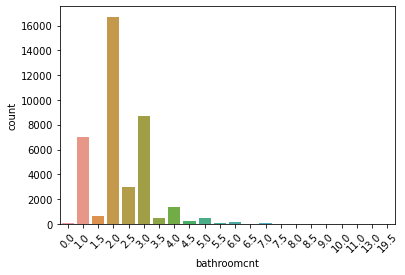

In [104]:
number_of_bathrooms = sns.countplot(data = train, x = train.bathroomcnt)
rotation = plt.xticks(rotation = 45)

In [105]:
train2.bathroomcnt.value_counts().sort_index()

0.0       93
1.0     6392
1.5      624
2.0    14799
2.5     2888
3.0     6772
3.5      324
4.0      864
4.5      110
5.0      145
5.5        9
6.0       14
7.0        3
Name: bathroomcnt, dtype: int64

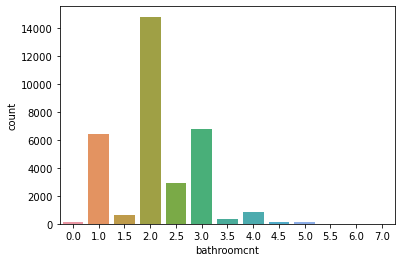

In [102]:
number_of_bathrooms = sns.countplot(data = train2, x = train2.bathroomcnt)

#### Log Error by Bathroom Count

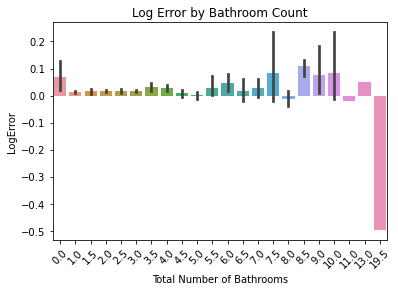

In [106]:
bathroomcnt_logerror = sns.barplot(x = train.bathroomcnt, y = train.logerror)
rotation = plt.xticks(rotation = 45)
labels = bathroomcnt_logerror.set(Title = "Log Error by Bathroom Count", xlabel = "Total Number of Bathrooms", ylabel = "LogError")

In [116]:
stats.ttest_ind(
    train[train.bathroomcnt < 3.5].logerror,
    train[train.bathroomcnt >= 3.5].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-2.1467275845759373, pvalue=0.031821096233265074)

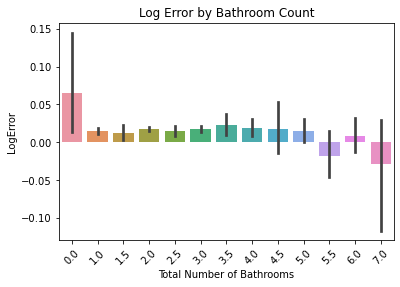

In [117]:
bathroomcnt_logerror = sns.barplot(x = train2.bathroomcnt, y = train2.logerror)
rotation = plt.xticks(rotation = 45)
labels = bathroomcnt_logerror.set(Title = "Log Error by Bathroom Count", xlabel = "Total Number of Bathrooms", ylabel = "LogError")

In [124]:
stats.ttest_ind(
    train2[train2.bathroomcnt < 3.5].logerror,
    train2[train2.bathroomcnt >= 3.5].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-0.4404085717998519, pvalue=0.6596440993101702)

### Does Log Error Differ Significantly by Bedroom Count?

#### Value Counts

In [125]:
train.bedroomcnt.value_counts().sort_index()

0.0       175
1.0      1194
2.0      8547
3.0     16556
4.0      9952
5.0      2305
6.0       355
7.0        66
8.0        18
9.0         6
10.0        1
Name: bedroomcnt, dtype: int64

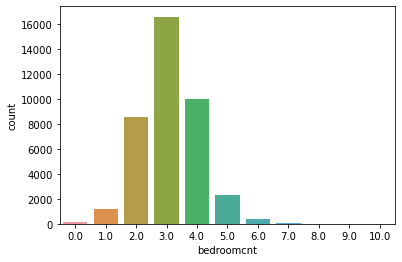

In [126]:
bedroom_value_counts = sns.countplot(data = train, x = train.bedroomcnt)

In [127]:
train2.bedroomcnt.value_counts().sort_index()

0.0      110
1.0      698
2.0     6853
3.0    14759
4.0     8682
5.0     1691
6.0      206
7.0       33
8.0        3
9.0        2
Name: bedroomcnt, dtype: int64

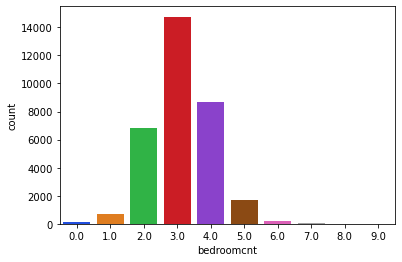

In [128]:
bedroom_value_counts = sns.countplot(data = train2, x = train2.bedroomcnt)

#### Log Error by Bedroom Count

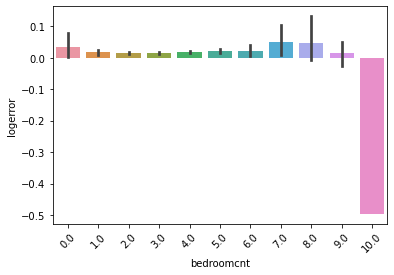

In [129]:
bedroomcnt_logerror = sns.barplot(x = train.bedroomcnt, y = train.logerror)
rotation = plt.xticks(rotation = 45)
labels = bathroomcnt_logerror.set(Title = "Log Error by Bedroom Count", xlabel = "Total Number of Bedrooms", ylabel = "LogError")

In [294]:
stats.ttest_ind(
    train[train.bedroomcnt < 4].logerror,
    train[train.bedroomcnt >= 4].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-1.9467335277685935, pvalue=0.0515738278860477)

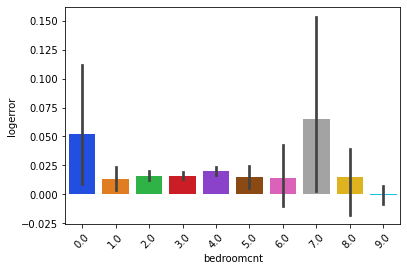

In [131]:
bedroomcnt_logerror = sns.barplot(x = train2.bedroomcnt, y = train2.logerror)
rotation = plt.xticks(rotation = 45)
labels = bathroomcnt_logerror.set(Title = "Log Error by Bedroom Count", xlabel = "Total Number of Bedrooms", ylabel = "LogError")

In [139]:
stats.ttest_ind(
    train2[train2.bedroomcnt < 3.5].logerror,
    train2[train2.bedroomcnt >= 3.5].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-1.5276481182114305, pvalue=0.12660950200360852)

#### Log Error by Tax Value

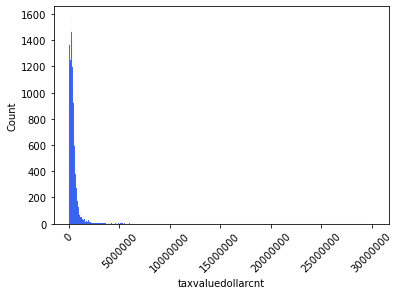

In [171]:
tax_value = sns.histplot(data = train, x = "taxvaluedollarcnt")
rotation = plt.xticks(rotation = 45)
tax_value.ticklabel_format(useOffset=False, style = "plain")

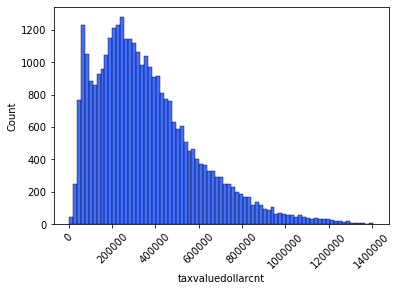

In [170]:
tax_value = sns.histplot(data = train2, x = "taxvaluedollarcnt")
tax_value.ticklabel_format(useOffset=False, style = "plain")
rotation = plt.xticks(rotation = 45)

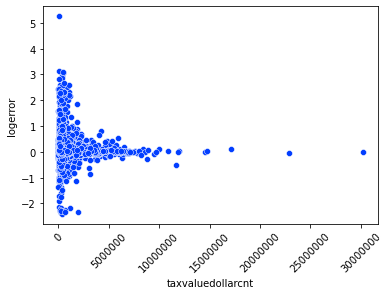

In [163]:
bedroomcnt_logerror = sns.scatterplot(x = train.taxvaluedollarcnt, y = train.logerror)
rotation = plt.xticks(rotation = 45)
labels = bathroomcnt_logerror.set(Title = "Log Error by Bedroom Count", xlabel = "Total Number of Bedrooms", ylabel = "LogError")
bedroomcnt_logerror.ticklabel_format(useOffset=False, style = "plain")

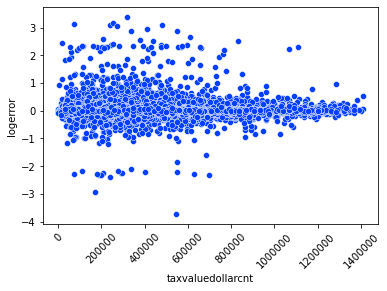

In [164]:
bedroomcnt_logerror = sns.scatterplot(x = train2.taxvaluedollarcnt, y = train2.logerror)
rotation = plt.xticks(rotation = 45)
labels = bathroomcnt_logerror.set(Title = "Log Error by Bedroom Count", xlabel = "Total Number of Bedrooms", ylabel = "LogError")
bedroomcnt_logerror.ticklabel_format(useOffset=False, style = "plain")

In [165]:
stats.ttest_ind(
    train[train.taxvaluedollarcnt < 800000].logerror,
    train[train.taxvaluedollarcnt >= 800000].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-0.6199022831460878, pvalue=0.535325728257313)

In [166]:
stats.ttest_ind(
    train2[train2.taxvaluedollarcnt < 800000].logerror,
    train2[train2.taxvaluedollarcnt >= 800000].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-0.11200184870171058, pvalue=0.9108226212299388)

In [167]:
stats.ttest_ind(
    train[train.taxvaluedollarcnt < 1000000].logerror,
    train[train.taxvaluedollarcnt >= 1000000].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-0.3198197227561783, pvalue=0.7491067012624505)

In [168]:
stats.ttest_ind(
    train2[train2.taxvaluedollarcnt < 1000000].logerror,
    train2[train2.taxvaluedollarcnt >= 1000000].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-1.1611138881379581, pvalue=0.2456039774140013)

#### Log Error by Yearbuilt

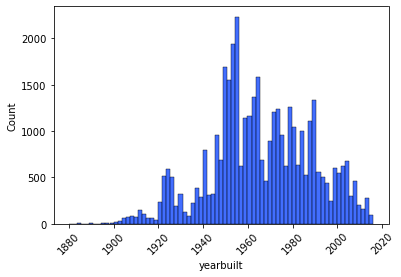

In [172]:
tax_value = sns.histplot(data = train, x = "yearbuilt")
rotation = plt.xticks(rotation = 45)

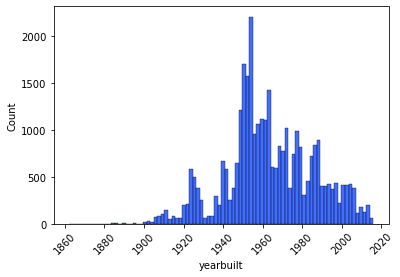

In [173]:
tax_value = sns.histplot(data = train2, x = "yearbuilt")
rotation = plt.xticks(rotation = 45)

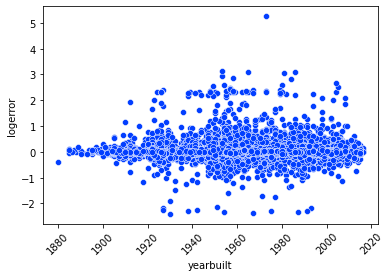

In [175]:
yearbuilt_logerror = sns.scatterplot(x = train.yearbuilt, y = train.logerror)
rotation = plt.xticks(rotation = 45)
yearbuilt_logerror.ticklabel_format(useOffset=False, style = "plain")

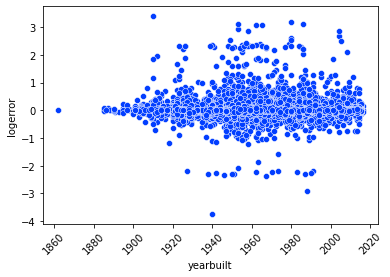

In [176]:
yearbuilt_logerror = sns.scatterplot(x = train2.yearbuilt, y = train2.logerror)
rotation = plt.xticks(rotation = 45)
yearbuilt_logerror.ticklabel_format(useOffset=False, style = "plain")

In [177]:
stats.ttest_ind(
    train[train.yearbuilt < 1940].logerror,
    train[train.yearbuilt >= 1940].logerror,
    equal_var=True
)

Ttest_indResult(statistic=0.13907063937615685, pvalue=0.8893950440212239)

In [178]:
stats.ttest_ind(
    train2[train2.taxvaluedollarcnt < 1940].logerror,
    train2[train2.taxvaluedollarcnt >= 1940].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-0.6717490818168933, pvalue=0.5017481466370459)

## Clustering

In [241]:
X = train[['bathroomcnt', 'bedroomcnt']]
X.head()

,bathroomcnt,bedroomcnt
2269,2.0,3.0
68766,2.0,4.0
43833,3.0,4.0
30161,2.0,3.0
47670,1.0,3.0


In [242]:
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns).set_index([X.index.values])

In [243]:
X_scaled

,bathroomcnt,bedroomcnt
2269,0.102564,0.3
68766,0.102564,0.4
43833,0.153846,0.4
30161,0.102564,0.3
47670,0.051282,0.3
...,...,...
27259,0.179487,0.5
22903,0.102564,0.4
23838,0.102564,0.3
37335,0.153846,0.5


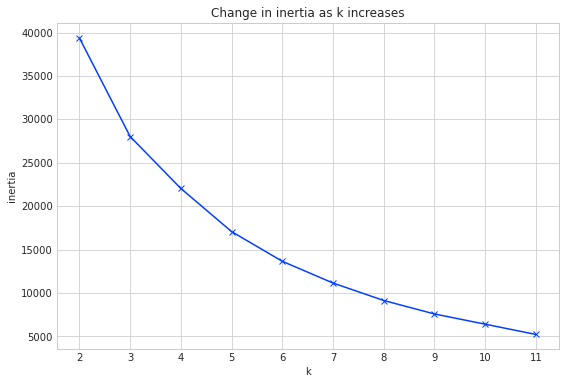

In [214]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Five cluster groups is optimal.

In [244]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

kmeans.cluster_centers_

array([[2.09544525, 3.14867114],
       [3.38367884, 4.3165515 ],
       [1.48393352, 1.82925208]])

In [255]:
kmeans2 = KMeans(n_clusters=3)
kmeans2.fit(X_scaled)

kmeans2.predict(X_scaled)

kmeans2.cluster_centers_

array([[0.08324024, 0.18442921],
       [0.10906571, 0.30003019],
       [0.14941617, 0.42614379]])

In [270]:
train = train.drop("cluster", axis = 1)
X_scaled = X_scaled.drop("cluster", axis = 1)


In [271]:
train['cluster'] = kmeans.predict(X)
X_scaled['cluster'] = kmeans2.predict(X_scaled)

In [272]:
centroids = train.groupby('cluster')['bathroomcnt', 'bedroomcnt'].mean()
centroids

,bathroomcnt,bedroomcnt
cluster,,
0,2.095445,3.148671
1,3.383679,4.316551
2,1.483934,1.829252


In [273]:
centroids_scaled = X_scaled.groupby('cluster')['bathroomcnt', 'bedroomcnt'].mean()
centroids_scaled

,bathroomcnt,bedroomcnt
cluster,,
0,0.083240,0.184429
1,0.109066,0.300030
2,0.149416,0.426144


Text(0.5, 1.0, 'Visualizing Cluster Centers')

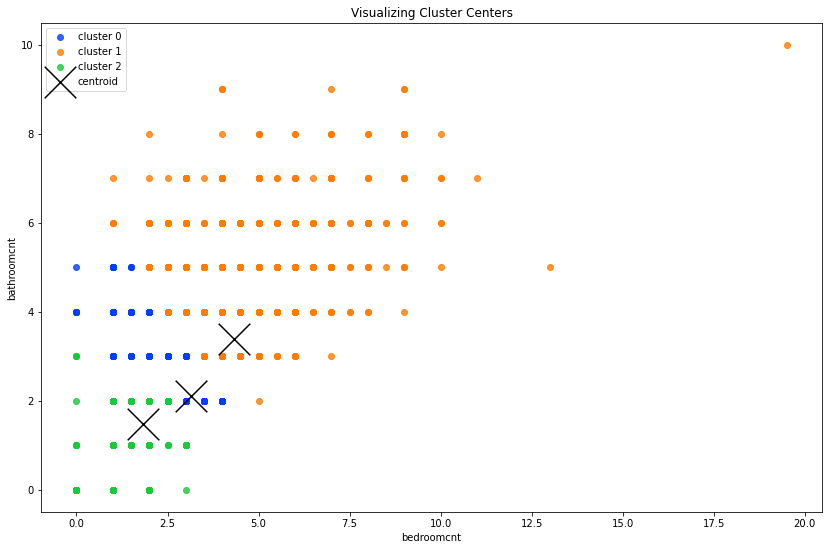

In [274]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.bathroomcnt, subset.bedroomcnt, label='cluster ' + str(cluster), alpha=.8)

centroids.plot.scatter(y='bathroomcnt', x='bedroomcnt', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('bedroomcnt')
plt.ylabel('bathroomcnt')
plt.title('Visualizing Cluster Centers')

Text(0.5, 1.0, 'Visualizing Cluster Centers')

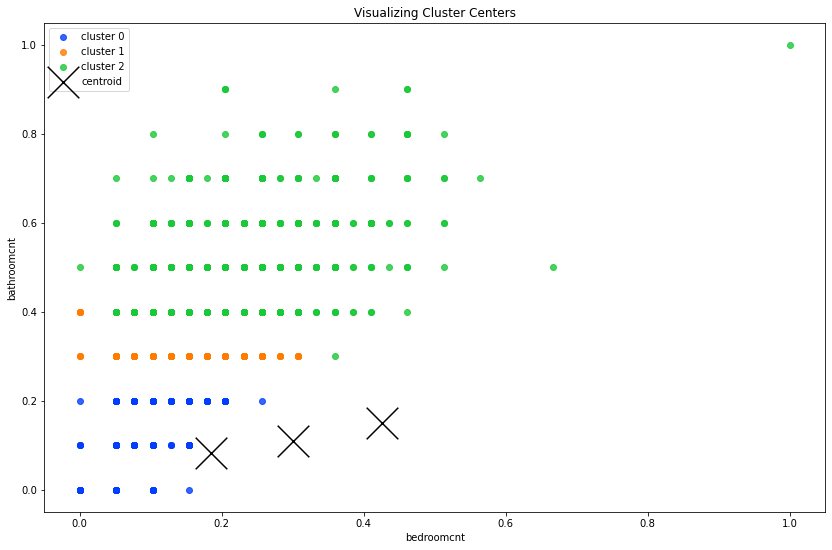

In [277]:
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('cluster'):
    plt.scatter(subset.bathroomcnt, subset.bedroomcnt, label='cluster ' + str(cluster), alpha=.8)

centroids_scaled.plot.scatter(y='bathroomcnt', x='bedroomcnt', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('bedroomcnt')
plt.ylabel('bathroomcnt')
plt.title('Visualizing Cluster Centers')

## Modeling 

In [281]:
cluster_1 = train[train.cluster == 0]
cluster_2 = train[train.cluster == 1]
cluster_3 = train[train.cluster == 2]

In [287]:
X_train_1 = cluster_1.drop(columns = "logerror", axis = 1)
X_train_2 = cluster_2.drop(columns = "logerror", axis = 1)
X_train_3 = cluster_3.drop(columns = "logerror", axis = 1)

In [286]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_model)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_model)
X_test_degree3 =  pf.transform(X_test_model)

NameError: name 'X_train_model' is not defined

### 